In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import animation
from mpl_toolkits.basemap import Basemap
import contextily as cx  
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial import cKDTree
from datetime import datetime
from matplotlib import gridspec
import scipy.stats as stats
import wavespectra
import netCDF4 as nc
import h5py
import numbers
import copy
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import pymannkendall as mk
import calendar
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
import re
from scipy.stats import norm


#import 
%matplotlib inline

In [2]:
ds = xr.open_dataset('/gpfs/home4/dvdhoorn/DanielData/ERA_5_data_for_hurrywave/Test.nc')

In [3]:
# Find the closest point in ds to the given lon/lat
target_lon = 3.275037
target_lat = 51.997799

# Get the arrays of latitudes and longitudes
lats = ds.latitude.values
lons = ds.longitude.values

# Find the index of the closest latitude and longitude
lat_idx = np.abs(lats - target_lat).argmin()
lon_idx = np.abs(lons - target_lon).argmin()

closest_lat = lats[lat_idx]
closest_lon = lons[lon_idx]

print(f"Closest point: lon = {closest_lon}, lat = {closest_lat}")

Closest point: lon = 3.5, lat = 52.0


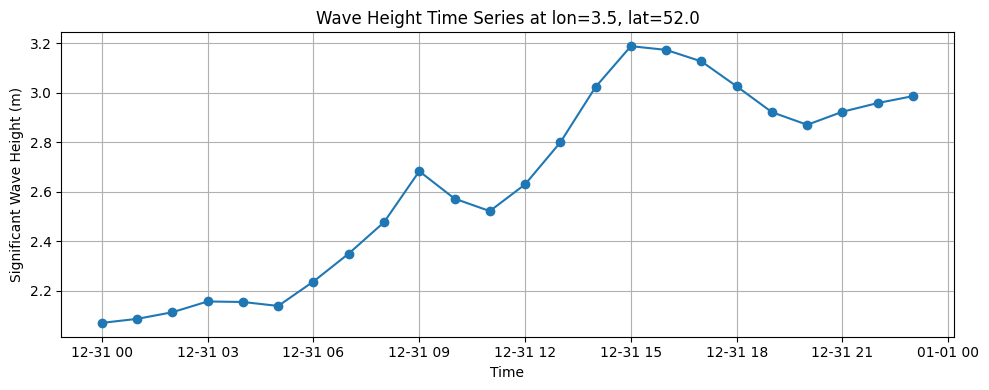

In [4]:
# Extract the significant wave height (swh) time series at the closest lat/lon
swh_timeseries = ds['swh'][:, lat_idx, lon_idx]
time = ds['valid_time']

plt.figure(figsize=(10, 4))
plt.plot(time, swh_timeseries, marker='o')
plt.title(f"Wave Height Time Series at lon={closest_lon}, lat={closest_lat}")
plt.xlabel("Time")
plt.ylabel("Significant Wave Height (m)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
print(ds['valid_time'][-15:].values)
print(swh_timeseries.values[-15:])

['2023-12-31T09:00:00.000000000' '2023-12-31T10:00:00.000000000'
 '2023-12-31T11:00:00.000000000' '2023-12-31T12:00:00.000000000'
 '2023-12-31T13:00:00.000000000' '2023-12-31T14:00:00.000000000'
 '2023-12-31T15:00:00.000000000' '2023-12-31T16:00:00.000000000'
 '2023-12-31T17:00:00.000000000' '2023-12-31T18:00:00.000000000'
 '2023-12-31T19:00:00.000000000' '2023-12-31T20:00:00.000000000'
 '2023-12-31T21:00:00.000000000' '2023-12-31T22:00:00.000000000'
 '2023-12-31T23:00:00.000000000']
[2.6838427 2.573113  2.5227664 2.6306608 2.8004324 3.0243297 3.189059
 3.1739883 3.1275208 3.0267282 2.9223025 2.8714206 2.9241207 2.959313
 2.9872584]


In [1]:
# Open the NetCDF file
import xarray as xr
file_path = '/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/04_modelruns/Test_larger_domain_Sinterklaas/hurrywave_his.nc'
ds_his = xr.open_dataset(file_path)
# Inspect the dataset
print(ds_his)

<xarray.Dataset> Size: 219kB
Dimensions:         (stations: 8, time: 936, runtime: 1)
Coordinates:
  * time            (time) datetime64[ns] 7kB 2013-10-31 ... 2013-12-08T23:00:00
Dimensions without coordinates: stations, runtime
Data variables: (12/16)
    inp             int32 4B ...
    station_id      (stations) float32 32B ...
    station_name    (stations) |S256 2kB ...
    station_x       (stations) float32 32B ...
    station_y       (stations) float32 32B ...
    station_z       (stations) float32 32B ...
    ...              ...
    point_dirspr    (time, stations) float32 30kB ...
    point_depth     (time, stations) float32 30kB ...
    wind_speed      (time, stations) float32 30kB ...
    wind_direction  (time, stations) float32 30kB ...
    total_runtime   (runtime) float32 4B ...
    average_dt      (runtime) float32 4B ...
Attributes:
    Conventions:                         Conventions = 'CF-1.6, SGRID-0.3
    Build-Revision-Date-Netcdf-library:  4.9.2 of Jun 17 2024 1

In [3]:
print(ds_his.keys())

KeysView(<xarray.Dataset> Size: 219kB
Dimensions:         (stations: 8, time: 936, runtime: 1)
Coordinates:
  * time            (time) datetime64[ns] 7kB 2013-10-31 ... 2013-12-08T23:00:00
Dimensions without coordinates: stations, runtime
Data variables: (12/16)
    inp             int32 4B ...
    station_id      (stations) float32 32B ...
    station_name    (stations) |S256 2kB ...
    station_x       (stations) float32 32B ...
    station_y       (stations) float32 32B ...
    station_z       (stations) float32 32B ...
    ...              ...
    point_dirspr    (time, stations) float32 30kB ...
    point_depth     (time, stations) float32 30kB ...
    wind_speed      (time, stations) float32 30kB ...
    wind_direction  (time, stations) float32 30kB ...
    total_runtime   (runtime) float32 4B ...
    average_dt      (runtime) float32 4B ...
Attributes:
    Conventions:                         Conventions = 'CF-1.6, SGRID-0.3
    Build-Revision-Date-Netcdf-library:  4.9.2 of Jun 

In [8]:
print(ds_his['station_x'].values)

[3.275037 2.93575  4.150286 1.166099 3.218932 4.012222 4.056983 3.817   ]


In [7]:
print(ds_his2.keys())

KeysView(<xarray.Dataset> Size: 348kB
Dimensions:         (stations: 8, time: 1489, runtime: 1)
Coordinates:
  * time            (time) datetime64[ns] 12kB 2023-10-31 ... 2024-01-01
Dimensions without coordinates: stations, runtime
Data variables: (12/16)
    inp             int32 4B ...
    station_id      (stations) float32 32B ...
    station_name    (stations) |S256 2kB ...
    station_x       (stations) float32 32B ...
    station_y       (stations) float32 32B ...
    station_z       (stations) float32 32B ...
    ...              ...
    point_dirspr    (time, stations) float32 48kB ...
    point_depth     (time, stations) float32 48kB ...
    wind_speed      (time, stations) float32 48kB ...
    wind_direction  (time, stations) float32 48kB ...
    total_runtime   (runtime) float32 4B ...
    average_dt      (runtime) float32 4B ...
Attributes:
    Conventions:                         Conventions = 'CF-1.6, SGRID-0.3
    Build-Revision-Date-Netcdf-library:  4.9.2 of Jun 17 2024

In [8]:
station_index = 3  # Station 2 corresponds to index 1 (0-based indexing)
point_hm0_station2 = ds_his['point_hm0'][:, station_index].values
print(point_hm0_station2)

[0. 0. 0. ... 0. 0. 0.]


In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import animation
from mpl_toolkits.basemap import Basemap
import contextily as cx 
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial import cKDTree
from datetime import datetime
from matplotlib import gridspec
import scipy.stats as stats
import wavespectra
import netCDF4 as nc
import h5py
import numbers
import copy
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import pymannkendall as mk
import calendar
from sklearn.linear_model import LinearRegression
import re
import gc

base_path = "/gpfs/work3/0/ai4nbs/hurry_wave/north_sea"
output_dir = os.path.join(base_path, "04_modelruns" , "Test_larger_domain_Sinterklaas", "1_postprocess")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# parser = argparse.ArgumentParser(description="Postprocess Hurrywave output.")
# parser.add_argument("--model_name", type=str, required=True, help="Name of the model run")
# parser.add_argument("--data_name", type=str, required=True, help="Name of the data set")
# args = parser.parse_args()

# model_name = args.model_name
# data_name = args.data_name

year_start = 2013 # Latest year
year_end = 2013 # Earliest year

month_start = 12 # Latest month
month_end = 12 # Earliest month

day_start = 8 # Latest day
day_end = 1 # Earliest day

hour_start = 23 # Latest hour
hour_end = 0 # Earliest hour

years  = np.arange(year_start, year_end - 1, -1)
months = np.arange(month_start, month_end - 1, -1)
days   = np.arange(day_start, day_end - 1, -1)
hours  = np.arange(hour_start, hour_end - 1, -1)

run_tests = False

area = [80, -25, 45, 10] # DCSM area in the North Sea (degrees): North, West, South, East

# model_path = os.path.join(base_path, '04_modelruns', 'YearSims',model_name)

model_path = os.path.join(base_path, '04_modelruns', 'Test_larger_domain_Sinterklaas')
small_model_path = os.path.join(base_path, '04_modelruns', 'YearSims', '2013')
model_path_start = os.path.join(model_path) 



postprocess_path = os.path.join(base_path, '05_postprocessing', 'his_files_per_station')
spectral_data_path = os.path.join(base_path, '01_data', 'spectral_buoy_data')
ERA5_data_path = '/gpfs/work3/0/ai4nbs/ERA5_data/NorthSea_waves'


inp_file = os.path.join(model_path_start, 'hurrywave.inp')
tstart = f"{year_end}{month_end}{day_end} {hour_end}0000" # earliest time
tstop = f"{year_start}{month_start}{day_start} {hour_start}0000" # latest time

# DCSM bounding box: [North, West, South, East]
area = area  # (N, W, S, E)

# Find the start and stop times from the input file
with open(inp_file, 'r') as f:
    for line in f:
        if line.strip().startswith('tspinup'):
            tspinup = line.split('=')[1].strip()


# Ensure time is in "yyyymmdd hhmmss" format
def parse_time(s):
    parts = s.strip().split()
    if len(parts) == 2:
        date, time = parts
    elif len(parts) == 1:
        date = parts[0][:8]
        time = parts[0][8:] if len(parts[0]) > 8 else "000000"
    else:
        date, time = "00000000", "000000"  # fallback
    return f"{date} {time}"


tstart_str = parse_time(tstart)
tstop_str = parse_time(tstop)

tstart_dt = datetime.strptime(tstart_str, "%Y%m%d %H%M%S")
tstop_dt = datetime.strptime(tstop_str, "%Y%m%d %H%M%S")

def read_stations_from_obs(file_path):
    """
    Reads station coordinates and names from a .obs file.

    Returns:
        xs (list[float]): x coordinates
        ys (list[float]): y coordinates
        names (list[str]): station names
    """
    xs, ys, names = [], [], []
    with open(file_path, 'r') as f:
        for line in f:
            if '#' in line:
                parts = line.strip().split()
                x = float(parts[0])
                y = float(parts[1])
                name = " ".join(parts[3:])  # everything after "#"
                xs.append(x)
                ys.append(y)
                names.append(name)
    return xs, ys, names

# Example usage
obs_file_path = os.path.join(model_path_start, 'hurrywave.obs')
xs, ys, station_names = read_stations_from_obs(obs_file_path)


# In[4]:


def his_remove_spinup(year, model_base_path, his):
    # Find the start and stop times from the input file
    inp_file = os.path.join(model_base_path, 'hurrywave.inp')
    with open(inp_file, 'r') as f:
        for line in f:
            if line.strip().startswith('tspinup'):
                tspinup = line.split('=')[1].strip()

    tspinup_sec = int(tspinup)
    his_time_vals = his["time"].values
    spinup_end_time = his_time_vals[0] + np.timedelta64(tspinup_sec, 's')
    his_spinup_mask = his_time_vals >= spinup_end_time
    his = his.sel(time=his_spinup_mask)
    return his


# In[5]:


def read_stations_from_obs(file_path):
    xs, ys, names = [], [], []
    with open(file_path, 'r') as f:
        for line in f:
            if '#' in line:
                parts = line.strip().split()
                x = float(parts[0])
                y = float(parts[1])
                name = " ".join(parts[3:])
                xs.append(x)
                ys.append(y)
                names.append(name)
    return xs, ys, names


def process_station_data(model_base_path, outdir, y0, y1, save=True):
    print('Starting Hurrywave station extraction...')

    years = np.arange(y0, y1 + 1)
    data_per_station = {}

    for y in years:
        print(f'Processing year: {y}')
        # Read station coordinates from obs file
        obs_file_path = os.path.join(model_base_path, 'hurrywave.obs')
        xs, ys, station_names_obs = read_stations_from_obs(obs_file_path)
        station_coord_map = {name: (x, y) for name, x, y in zip(station_names_obs, xs, ys)}
        fname = os.path.join(model_base_path, 'hurrywave_his.nc')
        ds = xr.open_dataset(fname)

        ds = his_remove_spinup(y, model_base_path, ds)

        nstations = ds.dims['stations']
        station_names = ds['station_name'].astype(str).values

        # Select only point variables with dims (time, stations)
        data_vars = [v for v in ds.data_vars if ds[v].dims == ('time', 'stations')]
        time = ds['time'].values

        for i in range(nstations):
            station = station_names[i].strip()
            print(f'  - Extracting {station}')

            if station not in data_per_station:
                data_per_station[station] = {var: [] for var in data_vars}
                data_per_station[station]['time'] = []

                # Add station coordinates
                data_per_station[station]['station_x'] = station_coord_map[station_names_obs[i]][0]
                data_per_station[station]['station_y'] = station_coord_map[station_names_obs[i]][1]

            # Append year’s data for each variable
            for var in data_vars:
                data_per_station[station][var].append(ds[var].isel(stations=i).values)
            data_per_station[station]['time'].append(time)

        ds.close()

    # Concatenate lists into arrays per station
    for station in data_per_station.keys():
        for key in data_per_station[station]:
            if isinstance(data_per_station[station][key], list) and key not in ('station_x', 'station_y'):
                data_per_station[station][key] = np.concatenate(data_per_station[station][key])

    if save:
        print('All years loaded. Starting export...')
        os.makedirs(outdir, exist_ok=True)

        for station, data in data_per_station.items():
            outpath = os.path.join(outdir, f'{station}.npz')
            np.savez(outpath, **data)
            print(f'  ✓ Saved {station}.npz with {len(data["time"])} timesteps.')

        print(f'Extraction finished. Data saved to: {outdir}')
    else:
        print(f'Extraction complete. Data not saved (save=False).')

    return data_per_station, station_names_obs


# In[6]:


data_per_station, station_names = process_station_data(
    model_base_path=model_path,
    outdir=postprocess_path,
    y0=year_end,
    y1=year_start,
    save=False
)

small_data_per_station, small_station_names = process_station_data(
    model_base_path=small_model_path,
    outdir=postprocess_path,
    y0=year_end,
    y1=year_start,
    save=False
)


# Map station IDs to station names using the station_names list
station_ids = list(data_per_station.keys())
if len(station_ids) != len(station_names):
    raise ValueError(f"Number of station IDs ({len(station_ids)}) and station names ({len(station_names)}) do not match.")

else:
    data_per_station_named = {}
    for sid, sname in zip(station_ids, station_names):
        data_per_station_named[sname] = data_per_station[sid]
    data_per_station = data_per_station_named

# Map station IDs to station names using the station_names list
small_station_ids = list(small_data_per_station.keys())
if len(small_station_ids) != len(small_station_names):
    raise ValueError(f"Number of station IDs ({len(small_station_ids)}) and station names ({len(small_station_names)}) do not match.")

else:
    small_data_per_station_named = {}
    for sid, sname in zip(small_station_ids, small_station_names):
        small_data_per_station_named[sname] = small_data_per_station[sid]
    small_data_per_station = small_data_per_station_named


Starting Hurrywave station extraction...
Processing year: 2013


/scratch-local/72649/ipykernel_1370442/2196669129.py:189: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']
/scratch-local/72649/ipykernel_1370442/2196669129.py:189: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']


  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008
Extraction complete. Data not saved (save=False).
Starting Hurrywave station extraction...
Processing year: 2013
  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008
Extraction complete. Data not saved (save=False).


In [2]:
print(small_data_per_station['Euro platform']['time'].shape)
print(data_per_station['Euro platform']['time'].shape)

(8761,)
(192,)


In [3]:
# In[8]:




# Create a dictionary mapping station names to their depth value
depths = {station: float(data_per_station[station]['point_depth'][0]) for station in station_names}


# In[9]:


for station in station_names:
    depth = data_per_station[station]['point_depth'][0]
    print(f"{station}: {depth}")


# In[10]:


model_var_names = list(data_per_station['Euro platform'].keys())
model_var_names.remove('time')
model_var_names.remove('station_x')
model_var_names.remove('station_y')

def remove_concatenation_outliers(time_array, *data_arrays,year_start=year_start, year_end=year_end):
    """
    Remove entries where two consecutive times are both midnight (00:00:00).
    If this occurs, remove the entry of the first midnight.

    Args:
        time_array (np.ndarray or pd.Series): Array of datetime64 or pandas Timestamps.
        *data_arrays: Any number of arrays (same length as time_array) to filter in sync.

    Returns:
        filtered_time, filtered_data_arrays...
    """

    # Convert to pandas DatetimeIndex for easy hour extraction
    time_pd = pd.to_datetime(time_array)
    # For DatetimeIndex, use .hour, .minute, .second directly (no .dt needed)
    is_midnight = (time_pd.hour == 0) & (time_pd.minute == 0) & (time_pd.second == 0)
    # Find consecutive midnights
    consecutive_midnight = is_midnight[:-1] & is_midnight[1:]
    # Indices to remove: the first of each consecutive midnight pair
    remove_idx = np.where(consecutive_midnight)[0]
    # Build mask: True = keep, False = remove
    mask = np.ones(len(time_array), dtype=bool)
    mask[remove_idx] = False
    mask[-1] = False  # Always remove the last entry
    
    filtered_time = time_array[mask]
    filtered_data_arrays = [arr[mask] for arr in data_arrays]
    if filtered_data_arrays:
        return (filtered_time, *filtered_data_arrays)
    else:
        return filtered_time
    
# Apply to each station and all model variables (except time/station_x/station_y)
for station in station_names:
    time = data_per_station[station]['time']
    data_arrays = [data_per_station[station][var] for var in model_var_names if var in data_per_station[station]]
    filtered_results = remove_concatenation_outliers(time, *data_arrays)
    if len(filtered_results) == len(data_arrays) + 1:
        filtered_time = filtered_results[0]
        filtered_data_arrays = filtered_results[1:]
        data_per_station[station]['time'] = filtered_time
        for var, arr in zip(model_var_names, filtered_data_arrays):
            data_per_station[station][var] = arr
    else:
        print(f"Warning: No data arrays returned for station {station}.")


# Apply to each station and all model variables (except time/station_x/station_y)
for station in station_names:
    time = small_data_per_station[station]['time']
    data_arrays = [small_data_per_station[station][var] for var in model_var_names if var in small_data_per_station[station]]
    small_filtered_results = remove_concatenation_outliers(time, *data_arrays)
    if len(small_filtered_results) == len(data_arrays) + 1:
        small_filtered_time = small_filtered_results[0]
        small_filtered_data_arrays = small_filtered_results[1:]
        small_data_per_station[station]['time'] = small_filtered_time
        for var, arr in zip(model_var_names, small_filtered_data_arrays):
            small_data_per_station[station][var] = arr
    else:
        print(f"Warning: No data arrays returned for station {station}.")
# ## ERA 5 extraction

# In[13]:


variables_era5 = {
    'swh': 'significant_height_of_combined_wind_waves_and_swell',
    'pp1d': 'peak_wave_period',
    'mwd': 'mean_wave_direction'
}

def ensure_datetime64(ds, time_name="valid_time"):
    if not np.issubdtype(ds[time_name].dtype, np.datetime64):
        try:
            ds = xr.decode_cf(ds)
        except Exception:
            ds[time_name] = xr.conventions.times.decode_cf_datetime(
                ds[time_name], units="seconds since 1970-01-01"
            )
    return ds

def process_era5_station_data(ERA5_data_path, variables, years, station_names, xs, ys,
                              tstart_dt, tstop_dt, area, save=False, outdir=None):

    ERA5_data_per_station = {}

    print('Starting ERA5 station extraction...')
    for y in years:
        print(f'Processing year: {y}')
        year_datasets = {}

        # Load all variables for this year
        for varname, subdir in variables.items():
            fname = os.path.join(ERA5_data_path, subdir, f'node_{subdir}_{y}.nc')
            ds = xr.open_dataset(fname)

            # Standardize time
            if 'valid_time' not in ds.coords:
                if 'time' in ds.coords:
                    ds = ds.rename({'time': 'valid_time'})
                else:
                    raise ValueError(f"No valid time in {fname}")

            ds = ensure_datetime64(ds, 'valid_time')
            ds = ds.sel(valid_time=slice(tstart_dt, tstop_dt))

            # Normalize longitudes
            lon_name = [c for c in ds.coords if "lon" in c.lower()][0]
            if ds[lon_name].max() > 180:
                ds[lon_name] = ((ds[lon_name]+180)%360)-180
                ds = ds.sortby(lon_name)

            # Crop space if gridded
            lat_name = [c for c in ds.coords if "lat" in c.lower()][0]
            if 'station' not in ds.dims:
                ds = ds.sel({lat_name: slice(area[0], area[2]),
                             lon_name: slice(area[1], area[3])})

            year_datasets[varname] = ds

        # Time array
        time = year_datasets[list(year_datasets.keys())[0]]['valid_time'].values

        # Loop over stations
        for i, (station, lon, lat) in enumerate(zip(station_names, xs, ys)):
            if station not in ERA5_data_per_station:
                ERA5_data_per_station[station] = {v: [] for v in variables.keys()}
                ERA5_data_per_station[station]['time'] = []
                ERA5_data_per_station[station]['station_x'] = lon
                ERA5_data_per_station[station]['station_y'] = lat

            for varname, ds in year_datasets.items():
                da = ds[varname]

                # Station dataset: select closest station
                if 'station' in da.dims:
                    lat_vals = ds['latitude'].values
                    lon_vals = ds['longitude'].values
                    idx = int(np.argmin((lat_vals-lat)**2 + (lon_vals-lon)**2))
                    point = da.isel(station=idx)
                else:
                    # Gridded dataset: select nearest lat/lon
                    lat_name = [c for c in da.coords if 'lat' in c.lower()][0]
                    lon_name = [c for c in da.coords if 'lon' in c.lower()][0]
                    point = da.sel({lat_name: lat, lon_name: lon}, method='nearest')

                point = point.squeeze(drop=True)
                ERA5_data_per_station[station][varname].append(point.values)

            ERA5_data_per_station[station]['time'].append(time)
        print(f'→ Extracted year: {y}')

        # Close datasets
        for ds in year_datasets.values():
            ds.close()
        


    print('ERA5 station extraction complete.')
    print('Starting concatenation and sorting...')

    # Concatenate per station
    for station in ERA5_data_per_station:
        for key in ERA5_data_per_station[station]:
            if isinstance(ERA5_data_per_station[station][key], list) and key not in ('station_x','station_y'):
                ERA5_data_per_station[station][key] = np.concatenate(ERA5_data_per_station[station][key])

        # Sort by time
        sort_idx = np.argsort(ERA5_data_per_station[station]['time'])
        for key in ERA5_data_per_station[station]:
            if isinstance(ERA5_data_per_station[station][key], np.ndarray) and ERA5_data_per_station[station][key].shape == sort_idx.shape:
                ERA5_data_per_station[station][key] = ERA5_data_per_station[station][key][sort_idx]

    print('Concatenation and sorting complete.')
    return ERA5_data_per_station

ERA5_data_per_station = process_era5_station_data(ERA5_data_path, variables_era5, years, station_names, xs, ys, tstart_dt, tstop_dt, area, save=False, outdir=None)



# ## Waterinfo extraction

# In[14]:


# Path to Waterinfo_RWS data
waterinfo_base = os.path.join(base_path, "01_data", "Waterinfo_RWS")

# Collect all years available in Waterinfo_RWS
obs_years = sorted([d for d in os.listdir(waterinfo_base) if d.isdigit()])
# Only keep years from year_start down to year_end (inclusive)
obs_years = [year for year in obs_years if int(year) <= year_start and int(year) >= year_end]
obs_years = sorted(obs_years, reverse=True)  # Descending order: year_start to year_end


# Dictionary to hold all observational data per station
obs_data_per_station = {}

for year in obs_years:
    print(f"Loading observational data for year: {year}")
    year_dir = os.path.join(waterinfo_base, year)
    for fname in os.listdir(year_dir):
        if fname.endswith('.csv'):
            station = fname.replace('.csv', '')
            fpath = os.path.join(year_dir, fname)
            if not os.path.exists(fpath):
                print(f"File not found: {fpath}, skipping.")
                continue

            # Check if file is empty or contains no columns
            with open(fpath, 'r') as checkfile:
                first_line = checkfile.readline()
                if not first_line or len(first_line.strip().split(',')) < 2:
                    print(f"File {fpath} contains no columns, skipping.")
                    continue
            df = pd.read_csv(fpath, parse_dates=True)
            if df.empty:
                print(f"Skipping {fpath} as it contains no data records.")
                continue  # Skip file if no data record
            if df.empty or len(df) < 10:
                print(f"Skipping {fpath} as it contains no data records or less than 10 records.")
                continue  # Skip file if no data record or too few records
            df['year'] = int(year)
            if station not in obs_data_per_station:
                obs_data_per_station[station] = [df]
            else:
                obs_data_per_station[station].append(df)

    print(f"Finished loading observational data from Waterinfo_RWS for {len(obs_data_per_station)} stations.")

# Concatenate yearly dataframes for each station
for station in obs_data_per_station:
    obs_data_per_station[station] = pd.concat(obs_data_per_station[station], ignore_index=True)
    #divide all values of hm0 by 100 as they are in cm
    if 'hm0' in obs_data_per_station[station]:
        obs_data_per_station[station]['hm0'] = obs_data_per_station[station]['hm0'] / 100

    # t13 is divided by 0.95 to move to Tp
    if 't13' in obs_data_per_station[station]:
        obs_data_per_station[station]['t13'] = obs_data_per_station[station]['t13'] / 0.95

    # If the dataframe has
    # 'Unnamed: 0' as a column, rename it to 'time'
    for station in obs_data_per_station:
        if isinstance(obs_data_per_station[station], pd.DataFrame):
            if 'Unnamed: 0' in obs_data_per_station[station]:
                # Convert to pandas datetime first, then to numpy.datetime64 array
                time_pd = pd.to_datetime(obs_data_per_station[station].pop('Unnamed: 0'))
                obs_data_per_station[station]['time'] = time_pd.values.astype('datetime64[ns]')


# Now obs_data_per_station[station_name] contains all years of data for each station as a single DataFrame


# In[15]:


def get_data_availability(data_dict, variable_pairs=[('hm0', 't13')], time_key='time'):
    """
    For each station, check where both variables (e.g., hm0 and t13) are available (not NaN).
    Returns a dictionary with start date, end date, and count of valid points for each station.

    Args:
        data_dict (dict): Dictionary of station data (dict-of-arrays or dict-of-Series).
        variable_pairs (list of tuple): List of variable pairs to check (default: [('hm0', 't13')]).
        time_key (str): Key for the time array.

    Returns:
        dict: {station: {var1_var2: {'start': ..., 'end': ..., 'count': ...}, ...}, ...}
    """
    results = {}
    for station, dset in data_dict.items():
        results[station] = {}
        for var1, var2 in variable_pairs:
            v1 = dset.get(var1)
            v2 = dset.get(var2)
            t = dset.get(time_key)
            if v1 is None or v2 is None or t is None:
                results[station][f"{var1}_{var2}"] = {'start': None, 'end': None, 'count': 0}
                continue
            v1 = np.asarray(v1)
            v2 = np.asarray(v2)
            t = np.asarray(t)
            # Handle both numpy arrays and pandas Series (which may have object dtype)
            if hasattr(v1, "values"):
                v1 = v1.values
            if hasattr(v2, "values"):
                v2 = v2.values
            # Convert to float arrays if possible, else fallback to object dtype
            v1 = np.asarray(v1)
            v2 = np.asarray(v2)
            # Use pandas isna for object dtype, else np.isnan
            if np.issubdtype(v1.dtype, np.number) and np.issubdtype(v2.dtype, np.number):
                mask = (~np.isnan(v1)) & (~np.isnan(v2))
            else:
                mask = (~pd.isna(v1)) & (~pd.isna(v2))
            if np.any(mask):
                valid_times = t[mask]
                results[station][f"{var1}_{var2}"] = {
                    'start': valid_times[0],
                    'end': valid_times[-1],
                    'count': np.sum(mask)
                }
            else:
                results[station][f"{var1}_{var2}"] = {'start': None, 'end': None, 'count': 0}
    return results

# Example usage:
print("Observational data availability before removing outliers:")
availability = get_data_availability(obs_data_per_station, variable_pairs=[('hm0', 't13')])
for station, info in availability.items():
    print(f"{station}: {info}")




# Convert time strings to datetime, skip invalid formats
def safe_to_datetime(val):
    try:
        return pd.to_datetime(val)
    except Exception:
        return pd.NaT

obs_times = obs_data_per_station['Euro platform']['time']
# Convert to pandas datetime with timezone awareness, coerce errors
obs_times_dt = pd.to_datetime(obs_times, errors='coerce', utc=False)
# If some times are still not in the correct format, try parsing with exact format
if obs_times_dt.isnull().any():
    obs_times_dt = pd.to_datetime(obs_times, format='%Y-%m-%d %H:%M:%S%z', errors='coerce')

obs_data_per_station['Euro platform']['time'] = obs_times_dt





# In[20]:


def synchronize_station_keys(model_dict, meas_dict):
    # 1. Merge "K13a platform" into "K13 Alpha" in meas_dict
    k13a_key = None
    for key in meas_dict.keys():
        if "k13a" in key.lower():
            k13a_key = key
            break

    if k13a_key is not None:
        target_key = "K13 Alpha"
        k13a_data = meas_dict.get(k13a_key)
        target_data = meas_dict.get(target_key)

        if isinstance(k13a_data, pd.DataFrame) and isinstance(target_data, pd.DataFrame):
            merged = pd.concat([k13a_data, target_data]).drop_duplicates()
        else:
            merged = target_data if target_data is not None else k13a_data

        meas_dict[target_key] = merged

        if k13a_key != target_key:
            del meas_dict[k13a_key]

    # 2. Determine reference columns from meas_dict (use first DataFrame found)
    ref_columns = None
    for data in meas_dict.values():
        if isinstance(data, pd.DataFrame):
            ref_columns = data.columns
            break

    if ref_columns is None:
        raise ValueError("No DataFrame found in meas_dict to use as reference for columns.")

    # 3. Add missing stations from model_dict into meas_dict with empty DataFrame
    for station in model_dict.keys():
        if station not in meas_dict:
            meas_dict[station] = pd.DataFrame(columns=ref_columns)

    # 4. Ensure all existing DataFrames have the same columns
    for station, data in meas_dict.items():
        if isinstance(data, pd.DataFrame):
            for col in ref_columns:
                if col not in data.columns:
                    data[col] = np.nan
            meas_dict[station] = data[ref_columns]  # reorder

    return model_dict, meas_dict

data_per_station, obs_data_per_station = synchronize_station_keys(data_per_station, obs_data_per_station)

small_data_per_station, obs_data_per_station = synchronize_station_keys(small_data_per_station, obs_data_per_station)
# In[26]:


def wave_length_iterative(Hs, Tp, depth=None, g=9.81, tol=1e-6, max_iter=100):
    """
    Iteratively calculate wave length based on significant wave height and peak wave period.
    
    Parameters
    ----------
    Hs : float
        Significant wave height [m] (not directly used in deep-water wavelength, 
        but can be useful for shallow-water corrections later).
    Tp : float
        Peak wave period [s].
    depth : float or None
        Water depth [m]. If None, deep water assumption is used.
    g : float
        Gravitational acceleration [m/s²].
    tol : float
        Convergence tolerance.
    max_iter : int
        Maximum number of iterations.

    Returns
    -------
    L : float
        Calculated wave length [m].
    """

    # Deep-water initial guess
    L = g * Tp**2 / (2 * np.pi)
    
    if depth is None:
        return L  # Deep-water wavelength is direct from the formula

    # Iterative solution for finite depth using dispersion relation
    for i in range(max_iter):
        L_old = L
        k = 2 * np.pi / L_old  # wave number
        # New estimate from dispersion relation
        L = (g * Tp**2 / (2 * np.pi)) * np.tanh(k * depth)
        if abs(L - L_old) < tol:
            break

        if i == max_iter - 1:
            print("Warning: Maximum number of iterations reached in wave_length_iterative, solution may not have converged.")


    return L

def peak_period_from_length(L, depth=None, g=9.81):
    """
    Calculate peak wave period based on wave length.

    Parameters
    ----------
    L : float or array-like
        Wave length [m].
    depth : float or None
        Water depth [m]. If None, assumes deep water.
    g : float
        Gravitational acceleration [m/s²].

    Returns
    -------
    Tp : float or array-like
        Peak wave period [s].
    """
    k = 2 * np.pi / L

    if depth is None:
        # Deep-water approximation
        omega = np.sqrt(g * k)
    else:
        # Finite depth using dispersion relation
        omega = np.sqrt(g * k * np.tanh(k * depth))

    Tp = 2 * np.pi / omega
    return Tp


# In[27]:


def filter_obs_t13(obs_data_per_station, station_names):
    for station in station_names:
        df = obs_data_per_station.get(station)
        if df is not None and not df.empty and 't13' in df and 'tmax' in df:
            mask = (df['t13'] < df['tmax']) | df['t13'].isna() | df['tmax'].isna()
            obs_data_per_station[station] = df.loc[mask].reset_index(drop=True)




def remove_outliers(data_dict, varnames, threshold):
    """
    Remove all entries where the target variable exceeds the threshold.
    Works for both dict-of-DataFrame (obs) and dict-of-dicts (model).

    Args:
        data_dict (dict): Dictionary of station datasets.
        varnames (list of str): Possible keys for the variable (e.g. ["hm0", "point_hm0"]).
        threshold (float): Threshold value.
    """
    for station, dset in data_dict.items():
        # --- Case 1: whole dataset is a DataFrame ---
        if isinstance(dset, pd.DataFrame):
            for v in varnames:
                if v in dset:
                    # Only mask values where NOT NaN and > threshold; keep NaNs
                    if dset[v].empty:
                        print(f"Skipping {station} as {v} is empty.")
                        continue
                    size_before = len(dset)
                    mask = (dset[v].isna()) | (dset[v] <= threshold)
                    data_dict[station] = dset.loc[mask].copy()
                    size_after = len(data_dict[station])
                    print(f"{station}: {v} - size before: {size_before}, size after: {size_after}, outliers removed: {size_before - size_after}")
                    break
            continue

        # --- Case 2: dataset is a dict of arrays/Series ---
        target = None
        for v in varnames:
            if v in dset:
                target = dset[v]
                break
        if target is None:
            continue  # no matching variable

        # Convert target to numpy array
        target_arr = target.values if hasattr(target, "values") else np.asarray(target)
        # Only mask values where NOT NaN and > threshold; keep NaNs
        if hasattr(target_arr, "size") and target_arr.size == 0:
            print(f"Skipping {station} as target array is empty.")
            continue
        size_before = len(target_arr)
        mask = np.isnan(target_arr) | (target_arr <= threshold)

        for key, arr in dset.items():
            if hasattr(arr, "__len__") and not isinstance(arr, (str, bytes)) and len(arr) == len(mask):
                if isinstance(arr, pd.Series):
                    dset[key] = arr.iloc[mask]
                elif isinstance(arr, pd.DataFrame):
                    dset[key] = arr.iloc[mask, :]
                else:
                    dset[key] = np.asarray(arr)[mask]
            else:
                # leave scalars / metadata untouched
                dset[key] = arr
        size_after = np.sum(mask)
        print(f"{station}: {v} - size before: {size_before}, size after: {size_after}, outliers removed: {size_before - size_after}")

threshold_hm0 = 20
threshold_tp = 25
threshold_dir = 360

# Remove outliers for significant wave height
# remove_outliers(data_per_station, ["hm0", "point_hm0", "swh"], threshold_hm0)
# remove_outliers(obs_data_per_station, ["hm0", "point_hm0", "swh"], threshold_hm0)
# remove_outliers(ERA5_data_per_station, ["hm0", "point_hm0", "swh"], threshold_hm0)

# # Remove outliers for peak period
# remove_outliers(data_per_station, ["point_tp", "t13", "pp1d"], threshold_tp)
remove_outliers(obs_data_per_station, ["point_tp", "t13", "pp1d"], threshold_tp)
# remove_outliers(ERA5_data_per_station, ["point_tp", "t13", "pp1d"], threshold_tp)

# # Remove outliers for direction
# remove_outliers(data_per_station, ["point_wavdir", "th0", "mwd"], threshold_dir)
remove_outliers(obs_data_per_station, ["point_wavdir", "th0", "mwd"], threshold_dir)
# remove_outliers(ERA5_data_per_station, ["point_wavdir", "th0", "mwd"], threshold_dir)

filter_obs_t13(obs_data_per_station, station_names)

# Example usage:
print("Observational data availability after outlier removal:")
availability_after_outlier = get_data_availability(obs_data_per_station, variable_pairs=[('hm0', 't13')])
for station, info in availability_after_outlier.items():
    print(f"{station}: {info}")






# In[30]:


def sort_obs_data_per_station_by_time(obs_dict):
    """
    Sorts all entries of obs_data_per_station by the 'time' column/index.
    Handles both DataFrame and dict-of-Series structures.
    """
    for station, data in obs_dict.items():
        if isinstance(data, pd.DataFrame):
            if 'time' in data.columns:
                obs_dict[station] = data.sort_values('time').reset_index(drop=True)
        elif isinstance(data, dict) and 'time' in data:
            # Assume dict of Series, sort all Series by 'time'
            time_series = data['time']
            # Get sorted indices
            sorted_idx = np.argsort(time_series)
            for key in data:
                if hasattr(data[key], '__getitem__') and len(data[key]) == len(sorted_idx):
                    if isinstance(data[key], pd.Series):
                        data[key] = data[key].iloc[sorted_idx].reset_index(drop=True)
                    else:
                        data[key] = np.asarray(data[key])[sorted_idx]
    return obs_dict

obs_data_per_station = sort_obs_data_per_station_by_time(obs_data_per_station)
ERA5_data_per_station = sort_obs_data_per_station_by_time(ERA5_data_per_station)


# In[32]:


def convert_model_datetime(df_model):
    """
    Convert 'time' arrays in df_model dict to numpy datetime64[ns] using pandas for robustness.
    """
    for key in df_model.keys():
        if 'time' in df_model[key]:
            time_values = df_model[key]['time']
            
            # Convert pandas Series to numpy array if needed
            if isinstance(time_values, pd.Series):
                time_values = time_values.values
            
            # Wrap in pd.Series to ensure consistent behavior
            time_series = pd.Series(time_values)
            
            # Use pandas to_datetime to handle various formats, coerce errors to NaT
            time_pd = pd.to_datetime(time_series, errors='coerce')
            
            # Check for NaT values safely
            if time_pd.isna().any():
                print(f"Warning: Found invalid/missing times in station '{key}', these will become NaT.")
            
            # Convert to numpy datetime64[ns], keep NaT as numpy.datetime64('NaT')
            time_datetime = time_pd.values

            df_model[key]['time'] = time_datetime
            
    return df_model

data_per_station = convert_model_datetime(data_per_station)
small_data_per_station = convert_model_datetime(small_data_per_station)


# In[33]:


def filter_data_by_datetime_range(
    data,
    start_hour, start_day, start_month, start_year,
    end_hour, end_day, end_month, end_year,
    time_key="time"
):
    """
    Filter a dataset (dict or DataFrame) by a datetime range.

    Args:
        data: dict with a time array/Series at data[time_key], or a DataFrame with a time column.
        start_hour, start_day, start_month, start_year: int
        end_hour, end_day, end_month, end_year: int
        time_key: str, key or column name for time

    Returns:
        Filtered dataset (same type as input).
    """

    # Ensure start_day is valid for start_month/start_year
    last_day_start_month = calendar.monthrange(start_year, start_month)[1]
    if start_day > last_day_start_month:
        start_day = last_day_start_month

    # Ensure end_day is valid for end_month/end_year
    last_day_end_month = calendar.monthrange(end_year, end_month)[1]
    if end_day > last_day_end_month:
        end_day = last_day_end_month
    start = np.datetime64(f"{start_year:04d}-{start_month:02d}-{start_day:02d}T{start_hour:02d}:00:00")
    end = np.datetime64(f"{end_year:04d}-{end_month:02d}-{end_day:02d}T{end_hour:02d}:59:59")

    if isinstance(data, dict) and time_key in data:
        times = data[time_key]
        # Convert to numpy array if needed
        if isinstance(times, pd.Series):
            times = times.values
        mask = (times >= start) & (times <= end)
        filtered = {}
        for k, v in data.items():
            if hasattr(v, "__len__") and len(v) == len(times):
                filtered[k] = v[mask]
            else:
                filtered[k] = v
        return filtered
    elif isinstance(data, pd.DataFrame) and time_key in data.columns:
        mask = (data[time_key] >= start) & (data[time_key] <= end)
        return data.loc[mask].copy()
    else:
        raise ValueError("Input data must be a dict with a time array or a DataFrame with a time column.")

Euro platform: 31.250083923339844
Platform D15-A: 40.00022506713867
Platform Hoorn Q1-A: 23.25009536743164
North Cormorant: 155.75059509277344
K13 Alpha: 27.0
Platform F16-A: 46.50021743774414
IJmuiden munitiestortplaats: 24.749908447265625
A12 platform: 29.0
Starting ERA5 station extraction...
Processing year: 2013
→ Extracted year: 2013
ERA5 station extraction complete.
Starting concatenation and sorting...
Concatenation and sorting complete.
Loading observational data for year: 2013
Skipping /gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/Waterinfo_RWS/2013/K13 Alpha.csv as it contains no data records or less than 10 records.
Finished loading observational data from Waterinfo_RWS for 7 stations.
Observational data availability before removing outliers:
Platform Hoorn Q1-A: {'hm0_t13': {'start': np.datetime64('2013-01-01T00:00:00.000000000'), 'end': np.datetime64('2013-12-31T00:00:00.000000000'), 'count': np.int64(52417)}}
Platform F16-A: {'hm0_t13': {'start': np.datetime64('2013-0

In [4]:
def align_data_on_time(data_dict1, data_dict2):
    """
    Align two dictionaries of station data on the 'time' key.
    Ensures that all stations in both dictionaries have the same time range and shape.

    Args:
        data_dict1 (dict): First dictionary of station data.
        data_dict2 (dict): Second dictionary of station data.

    Returns:
        dict, dict: Aligned versions of data_dict1 and data_dict2.
    """
    aligned_data1 = {}
    aligned_data2 = {}

    for station in data_dict1.keys():
        if station in data_dict2:
            time1 = data_dict1[station]['time']
            time2 = data_dict2[station]['time']

            # Find the common time range
            common_time = np.intersect1d(time1, time2)

            # Filter data_dict1
            mask1 = np.isin(time1, common_time)
            aligned_data1[station] = {key: (val[mask1] if hasattr(val, '__len__') and len(val) == len(time1) else val)
                                      for key, val in data_dict1[station].items()}

            # Filter data_dict2
            mask2 = np.isin(time2, common_time)
            aligned_data2[station] = {key: (val[mask2] if hasattr(val, '__len__') and len(val) == len(time2) else val)
                                      for key, val in data_dict2[station].items()}

            # Ensure all variables have the same shape
            for key in aligned_data1[station]:
                if key in aligned_data2[station]:
                    len1 = len(aligned_data1[station][key]) if hasattr(aligned_data1[station][key], '__len__') else None
                    len2 = len(aligned_data2[station][key]) if hasattr(aligned_data2[station][key], '__len__') else None
                    if len1 != len2:
                        raise ValueError(f"Shape mismatch for station '{station}', key '{key}': {len1} != {len2}")

    return aligned_data1, aligned_data2

# Align data_per_station and small_data_per_station
data_per_station_aligned, small_data_per_station_aligned = align_data_on_time(data_per_station, small_data_per_station)

# Update the original dictionaries
data_per_station.clear()
data_per_station.update(data_per_station_aligned)

small_data_per_station.clear()
small_data_per_station.update(small_data_per_station_aligned)

In [5]:
# Initialize the filtered dictionary before the loop
data_per_station_filtered = {}
small_data_per_station_filtered = {}
obs_data_per_station_filtered = {}
for station in data_per_station.keys():
    data_per_station_filtered_key = filter_data_by_datetime_range(data_per_station[station], hours[-1], days[-1], months[-1], years[-1], hours[0], days[0], months[0], years[0])
    small_data_per_station_filtered_key = filter_data_by_datetime_range(small_data_per_station[station], hours[-1], days[-1], months[-1], years[-1], hours[0], days[0], months[0], years[0])
    obs_data_per_station_filtered_key = filter_data_by_datetime_range(obs_data_per_station[station], hours[-1], days[-1], months[-1], years[-1], hours[0], days[0], months[0], years[0])


    data_per_station_filtered[station] = data_per_station_filtered_key
    small_data_per_station_filtered[station] = small_data_per_station_filtered_key
    obs_data_per_station_filtered[station] = obs_data_per_station_filtered_key


# In[34]:


data_per_station = data_per_station_filtered
del data_per_station_filtered

small_data_per_station = small_data_per_station_filtered
del small_data_per_station_filtered

obs_data_per_station = obs_data_per_station_filtered
del obs_data_per_station_filtered


# In[35]:




# In[36]:


def common_times(arr1, arr2):
    """
    Return an array of common datetime64[ns] values between two arrays.

    Parameters:
    -----------
    arr1, arr2 : np.ndarray
        Arrays of dtype datetime64[ns]

    Returns:
    --------
    np.ndarray
        Sorted array containing common datetime64[ns] values.
    """
    return np.intersect1d(arr1, arr2)


# In[37]:


def find_unique_common_time_indexes(df_model, df_measurements, df_era5):
    common_indexes_dict = {}
    for station in df_model.keys():
        if station in df_measurements and station in df_era5:
            print(f"Processing {station}")

            model_times = df_model[station]['time']
            meas_times = df_measurements[station]['time']
            era5_times = df_era5[station]['time']

            # Normalize bad cases
            def safe_times(arr):
                if isinstance(arr, float) or arr is None:
                    return np.array([], dtype='datetime64[ns]')
                arr = np.array(arr)
                if arr.dtype == float:
                    return np.array([], dtype='datetime64[ns]')
                return arr.astype('datetime64[ns]')
            
            model_times = safe_times(model_times)
            meas_times  = safe_times(meas_times)
            era5_times  = safe_times(era5_times)

            # One common time axis across all three
            common = np.intersect1d(np.intersect1d(model_times, meas_times), era5_times)

            # Now build indexes relative to this single common array
            model_idx = np.array([np.where(model_times == t)[0][0] for t in common])
            meas_idx  = np.array([np.where(meas_times == t)[0][0] for t in common])
            era5_idx  = np.array([np.where(era5_times == t)[0][0] for t in common])

            common_indexes_dict[station] = {
                'common_times': common,
                'model_idx': model_idx,
                'meas_idx': meas_idx,
                'era5_idx': era5_idx
            }
    return common_indexes_dict

common_indexes_dict = find_unique_common_time_indexes(data_per_station, obs_data_per_station, ERA5_data_per_station)
small_common_indexes_dict = find_unique_common_time_indexes(small_data_per_station, obs_data_per_station, ERA5_data_per_station)




Processing Euro platform
Processing Platform D15-A
Processing Platform Hoorn Q1-A
Processing North Cormorant
Processing K13 Alpha
Processing Platform F16-A
Processing IJmuiden munitiestortplaats
Processing A12 platform
Processing Euro platform
Processing Platform D15-A
Processing Platform Hoorn Q1-A
Processing North Cormorant
Processing K13 Alpha
Processing Platform F16-A
Processing IJmuiden munitiestortplaats
Processing A12 platform


In [7]:
print(data_per_station['Euro platform']['time'].shape)
print(small_data_per_station['Euro platform']['time'].shape)
print(obs_data_per_station['Euro platform']['time'].shape)
print(common_indexes_dict['Euro platform']['common_times'].shape)
print(small_common_indexes_dict['Euro platform']['common_times'].shape)

(191,)
(191,)
(1152,)
(191,)
(191,)


In [8]:
# In[41]:


def filter_both_by_common_indexes(df_model, df_measurements, common_indexes_dict):
    """
    Make copies of model and measurement dictionaries and keep only the values
    at the indexes specified in common_indexes_dict for each station.
    """
    filtered_model = copy.deepcopy(df_model)
    filtered_measurements = {station: {k: v.copy(deep=True) if hasattr(v, 'copy') else copy.deepcopy(v)
                                   for k, v in inner.items()}
                         for station, inner in df_measurements.items()}

    for station, indexes in common_indexes_dict.items():
        model_idx = indexes.get('model_idx', [])
        meas_idx = indexes.get('meas_idx', [])

        print(f"\n--- Station: {station} ---")
        print(f"Model indexes count: {len(model_idx)}")
        print(f"Measurement indexes count: {len(meas_idx)}")

        # Convert indices to list of ints if they are numpy arrays or similar
        model_idx_list = list(model_idx) if len(model_idx) > 0 else []
        meas_idx_list = list(meas_idx) if len(meas_idx) > 0 else []

        # Model filtering
        for key, val in filtered_model[station].items():
            try:
                # Skip filtering if model_idx is empty or val is not indexable
                if not model_idx_list:
                    print(f"Model: Skipping key '{key}' because model_idx is empty")
                    continue

                # Check if val supports indexing by model_idx_list
                if hasattr(val, '__getitem__'):
                    filtered_val = val[model_idx_list]
                    filtered_model[station][key] = filtered_val
                    print(f"Model: Key '{key}' filtered shape: {getattr(filtered_val, 'shape', 'unknown')}")
                else:
                    print(f"Model: Key '{key}' is not indexable, skipping filtering")

            except Exception as e:
                print(f"Model: Error filtering key '{key}': {e}")

        # Measurement filtering
        for key, val in filtered_measurements[station].items():
            try:
                # Skip scalar values (e.g., float) that cannot be indexed
                if not hasattr(val, '__len__'):
                    print(f"Measurement: Key '{key}' is scalar or non-indexable, skipping filtering")
                    continue

                # Check if meas_idx is empty
                if not meas_idx_list:
                    print(f"Measurement: Skipping key '{key}' because meas_idx is empty")
                    model_len = len(filtered_model[station]['time'])
                    if isinstance(val, (pd.Series, pd.DataFrame)):
                        nan_val = np.full(model_len, np.nan)
                        if isinstance(val, pd.Series):
                            nan_val = pd.Series(nan_val, name=val.name)
                        else:
                            nan_val = pd.DataFrame({col: np.nan for col in val.columns}, index=range(model_len))
                        filtered_measurements[station][key] = nan_val
                    elif isinstance(val, np.ndarray):
                        filtered_measurements[station][key] = np.full(model_len, np.nan)
                    else:
                        filtered_measurements[station][key] = [np.nan] * model_len
                    continue

                val_type = type(val)
                val_len = len(val) if hasattr(val, '__len__') else 0
                print(f"Measurement before filtering: Key '{key}', type: {val_type}, length: {val_len}")

                # Validate indices are integers and in bounds (sample first 20)
                sample_idx = meas_idx_list[:20]
                idx_check = all(isinstance(idx, (int, np.integer)) and 0 <= idx < val_len for idx in sample_idx)
                print(f"Are all indices integer and within bounds? {idx_check}")
                if not idx_check:
                    print(f"Measurement: Invalid indices detected for key '{key}', skipping filtering")
                    continue

                # Filter according to type
                if isinstance(val, (pd.Series, pd.DataFrame)):
                    filtered_val = val.iloc[meas_idx_list].reset_index(drop=True)
                elif isinstance(val, np.ndarray):
                    filtered_val = val[meas_idx_list]
                else:
                    # Fallback for other iterable types like lists
                    filtered_val = [val[i] for i in meas_idx_list]

                filtered_measurements[station][key] = filtered_val

                filtered_type = type(filtered_val)
                filtered_shape = getattr(filtered_val, 'shape', 'unknown')
                print(f"Measurement: Key '{key}' filtered type: {filtered_type}, shape: {filtered_shape}")

                if isinstance(filtered_val, (pd.Series, pd.DataFrame)):
                    print(f"First 3 rows/values:\n{filtered_val.head(3)}")
                elif isinstance(filtered_val, (np.ndarray, list)):
                    print(f"First 3 values: {filtered_val[:3]}")

            except Exception as e:
                print(f"Measurement: Error filtering key '{key}': {e}")

    print("\n=== Summary of filtered results ===")
    for station in filtered_model.keys():
        print(f"Station: {station}")
        for key, val in filtered_model[station].items():
            print(f" Model key '{key}' shape: {getattr(val, 'shape', 'unknown')}")
        for key, val in filtered_measurements[station].items():
            print(f" Measurement key '{key}' shape: {getattr(val, 'shape', 'unknown')}")

    return filtered_model, filtered_measurements

def filter_both_by_common_indexes_ERA5(df_model, df_era5, common_indexes_dict):
    """
    Make copies of model and ERA5 dictionaries and keep only the values
    at the indexes specified in common_indexes_dict for each station.
    Uses 'model_idx' for model and 'era5_idx' for ERA5.
    """
    filtered_model = copy.deepcopy(df_model)
    filtered_era5 = copy.deepcopy(df_era5)

    for station, indexes in common_indexes_dict.items():
        model_idx = indexes.get('model_idx', [])
        era5_idx = indexes.get('era5_idx', [])

        print(f"\n--- Station: {station} ---")
        print(f"Model indexes count: {len(model_idx)}")
        print(f"ERA5 indexes count: {len(era5_idx)}")

        model_idx_list = list(model_idx) if len(model_idx) > 0 else []
        era5_idx_list = list(era5_idx) if len(era5_idx) > 0 else []

        # Model filtering
        for key, val in filtered_model[station].items():
            try:
                if not model_idx_list:
                    print(f"Model: Skipping key '{key}' because model_idx is empty")
                    continue
                if hasattr(val, '__getitem__'):
                    filtered_val = val[model_idx_list]
                    filtered_model[station][key] = filtered_val
                    print(f"Model: Key '{key}' filtered shape: {getattr(filtered_val, 'shape', 'unknown')}")
                else:
                    print(f"Model: Key '{key}' is not indexable, skipping filtering")
            except Exception as e:
                print(f"Model: Error filtering key '{key}': {e}")

        # ERA5 filtering
        for key, val in filtered_era5[station].items():
            try:
                if not hasattr(val, '__len__'):
                    print(f"ERA5: Key '{key}' is scalar or non-indexable, skipping filtering")
                    continue

                if not era5_idx_list:
                    print(f"ERA5: Skipping key '{key}' because era5_idx is empty")
                    model_len = len(filtered_model[station]['time'])
                    if isinstance(val, (pd.Series, pd.DataFrame)):
                        nan_val = np.full(model_len, np.nan)
                        if isinstance(val, pd.Series):
                            nan_val = pd.Series(nan_val, name=val.name)
                        else:
                            nan_val = pd.DataFrame({col: np.nan for col in val.columns}, index=range(model_len))
                        filtered_era5[station][key] = nan_val
                    elif isinstance(val, np.ndarray):
                        filtered_era5[station][key] = np.full(model_len, np.nan)
                    else:
                        filtered_era5[station][key] = [np.nan] * model_len
                    continue

                val_type = type(val)
                val_len = len(val) if hasattr(val, '__len__') else 0
                print(f"ERA5 before filtering: Key '{key}', type: {val_type}, length: {val_len}")

                sample_idx = era5_idx_list[:20]
                idx_check = all(isinstance(idx, (int, np.integer)) and 0 <= idx < val_len for idx in sample_idx)
                print(f"Are all indices integer and within bounds? {idx_check}")
                if not idx_check:
                    print(f"ERA5: Invalid indices detected for key '{key}', skipping filtering")
                    continue

                if isinstance(val, (pd.Series, pd.DataFrame)):
                    filtered_val = val.iloc[era5_idx_list].reset_index(drop=True)
                elif isinstance(val, np.ndarray):
                    filtered_val = val[era5_idx_list]
                else:
                    filtered_val = [val[i] for i in era5_idx_list]

                filtered_era5[station][key] = filtered_val

                filtered_type = type(filtered_val)
                filtered_shape = getattr(filtered_val, 'shape', 'unknown')
                print(f"ERA5: Key '{key}' filtered type: {filtered_type}, shape: {filtered_shape}")

                if isinstance(filtered_val, (pd.Series, pd.DataFrame)):
                    print(f"First 3 rows/values:\n{filtered_val.head(3)}")
                elif isinstance(filtered_val, (np.ndarray, list)):
                    print(f"First 3 values: {filtered_val[:3]}")

            except Exception as e:
                print(f"ERA5: Error filtering key '{key}': {e}")

    print("\n=== Summary of filtered results ===")
    for station in filtered_model.keys():
        print(f"Station: {station}")
        for key, val in filtered_model[station].items():
            print(f" Model key '{key}' shape: {getattr(val, 'shape', 'unknown')}")
        for key, val in filtered_era5[station].items():
            print(f" ERA5 key '{key}' shape: {getattr(val, 'shape', 'unknown')}")

    return filtered_model, filtered_era5

data_per_station_filtered, obs_data_per_station_filtered = filter_both_by_common_indexes(data_per_station, obs_data_per_station, common_indexes_dict)
data_per_station_filtered, ERA5_data_per_station_filtered = filter_both_by_common_indexes_ERA5(data_per_station, ERA5_data_per_station, common_indexes_dict)

small_data_per_station_filtered, obs_data_per_station_filtered = filter_both_by_common_indexes(small_data_per_station, obs_data_per_station, small_common_indexes_dict)
small_data_per_station_filtered, ERA5_data_per_station_filtered = filter_both_by_common_indexes_ERA5(small_data_per_station, ERA5_data_per_station, small_common_indexes_dict)


for station in station_names:
    model_shape = None
    obs_shape = None
    # Model shape
    if 'point_hm0' in data_per_station_filtered.get(station, {}):
        model_val = data_per_station_filtered[station]['point_hm0']
        model_shape = model_val.shape if hasattr(model_val, 'shape') else (len(model_val),)
    # Observation shape
    if 'hm0' in obs_data_per_station_filtered.get(station, {}):
        obs_val = obs_data_per_station_filtered[station]['hm0']
        obs_shape = obs_val.shape if hasattr(obs_val, 'shape') else (len(obs_val),)

    if 'swh' in ERA5_data_per_station_filtered.get(station, {}):
        ERA5_val = ERA5_data_per_station_filtered[station]['swh']
        ERA5_shape = ERA5_val.shape if hasattr(ERA5_val, 'shape') else (len(ERA5_val),)
    print(f"{station:30s} | model hm0: {model_shape} | obs hm0: {obs_shape} | ERA5 hm0: {ERA5_shape}" )


# In[45]:


data_per_station.clear()
small_data_per_station.clear()
obs_data_per_station.clear()
ERA5_data_per_station.clear()

data_per_station.update(data_per_station_filtered)
small_data_per_station.update(small_data_per_station_filtered)
obs_data_per_station.update(obs_data_per_station_filtered)
ERA5_data_per_station.update(ERA5_data_per_station_filtered)


--- Station: Euro platform ---
Model indexes count: 191
Measurement indexes count: 191
Model: Key 'point_hm0' filtered shape: (191,)
Model: Key 'point_tp' filtered shape: (191,)
Model: Key 'point_wavdir' filtered shape: (191,)
Model: Key 'point_dirspr' filtered shape: (191,)
Model: Key 'point_depth' filtered shape: (191,)
Model: Key 'wind_speed' filtered shape: (191,)
Model: Key 'wind_direction' filtered shape: (191,)
Model: Key 'time' filtered shape: (191,)
Model: Key 'station_x' is not indexable, skipping filtering
Model: Key 'station_y' is not indexable, skipping filtering
Measurement before filtering: Key 'hm0', type: <class 'pandas.core.series.Series'>, length: 1152
Are all indices integer and within bounds? True
Measurement: Key 'hm0' filtered type: <class 'pandas.core.series.Series'>, shape: (191,)
First 3 rows/values:
0    1.58
1    1.27
2    1.39
Name: hm0, dtype: float64
Measurement before filtering: Key 't13', type: <class 'pandas.core.series.Series'>, length: 1152
Are all 

In [9]:
for station in small_data_per_station:
    print(f"{station}: {small_data_per_station[station]['time'].shape}")
    print(f"{station}: {data_per_station[station]['time'].shape}")

Euro platform: (191,)
Euro platform: (191,)
Platform D15-A: (191,)
Platform D15-A: (191,)
Platform Hoorn Q1-A: (191,)
Platform Hoorn Q1-A: (191,)
North Cormorant: (191,)
North Cormorant: (191,)
K13 Alpha: (191,)
K13 Alpha: (191,)
Platform F16-A: (191,)
Platform F16-A: (191,)
IJmuiden munitiestortplaats: (191,)
IJmuiden munitiestortplaats: (191,)
A12 platform: (191,)
A12 platform: (191,)


In [10]:
print(data_per_station['Euro platform']['time'].shape)
print(small_data_per_station['Euro platform']['time'].shape)
print(obs_data_per_station['Euro platform']['time'].shape)

(191,)
(191,)
(191,)


In [11]:
print(obs_data_per_station['Euro platform']['time'])

0     2013-12-01 00:00:00
1     2013-12-01 01:00:00
2     2013-12-01 02:00:00
3     2013-12-01 03:00:00
4     2013-12-01 04:00:00
              ...        
186   2013-12-08 18:00:00
187   2013-12-08 19:00:00
188   2013-12-08 20:00:00
189   2013-12-08 21:00:00
190   2013-12-08 22:00:00
Name: time, Length: 191, dtype: datetime64[ns]


In [12]:
print(data_per_station['Euro platform']['time'])

['2013-12-01T00:00:00.000000000' '2013-12-01T01:00:00.000000000'
 '2013-12-01T02:00:00.000000000' '2013-12-01T03:00:00.000000000'
 '2013-12-01T04:00:00.000000000' '2013-12-01T05:00:00.000000000'
 '2013-12-01T06:00:00.000000000' '2013-12-01T07:00:00.000000000'
 '2013-12-01T08:00:00.000000000' '2013-12-01T09:00:00.000000000'
 '2013-12-01T10:00:00.000000000' '2013-12-01T11:00:00.000000000'
 '2013-12-01T12:00:00.000000000' '2013-12-01T13:00:00.000000000'
 '2013-12-01T14:00:00.000000000' '2013-12-01T15:00:00.000000000'
 '2013-12-01T16:00:00.000000000' '2013-12-01T17:00:00.000000000'
 '2013-12-01T18:00:00.000000000' '2013-12-01T19:00:00.000000000'
 '2013-12-01T20:00:00.000000000' '2013-12-01T21:00:00.000000000'
 '2013-12-01T22:00:00.000000000' '2013-12-01T23:00:00.000000000'
 '2013-12-02T00:00:00.000000000' '2013-12-02T01:00:00.000000000'
 '2013-12-02T02:00:00.000000000' '2013-12-02T03:00:00.000000000'
 '2013-12-02T04:00:00.000000000' '2013-12-02T05:00:00.000000000'
 '2013-12-02T06:00:00.000

Observation record counts per station (BEFORE Goda removal):
Euro platform                 : 192
Platform D15-A                : 192
Platform Hoorn Q1-A           : 192
North Cormorant               : 192
K13 Alpha                     : 192
Platform F16-A                : 192
IJmuiden munitiestortplaats   : 192
A12 platform                  : 191
Not enough valid data for North Cormorant, skipping.
Not enough valid data for A12 platform, skipping.
Observation record counts per station (AFTER Goda removal):
Euro platform                 : 192
Platform D15-A                : 192
Platform Hoorn Q1-A           : 192
North Cormorant               : 192
K13 Alpha                     : 192
Platform F16-A                : 192
IJmuiden munitiestortplaats   : 192
A12 platform                  : 191


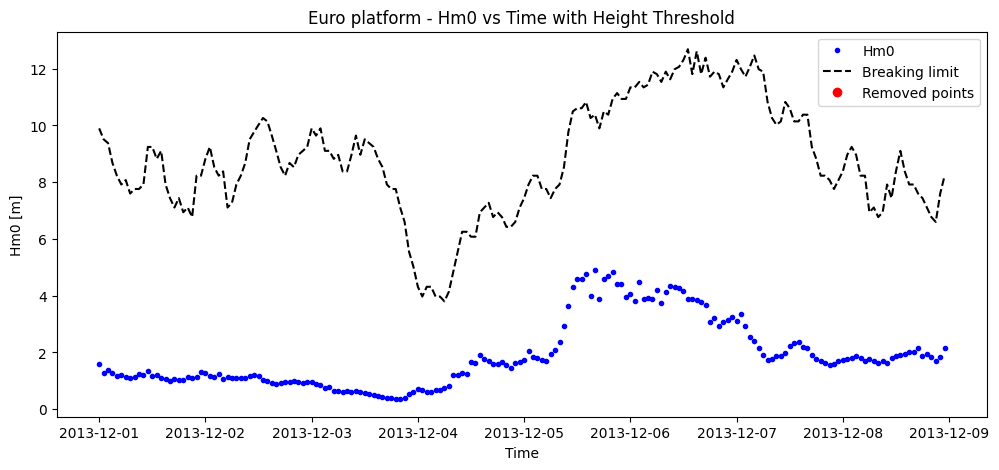

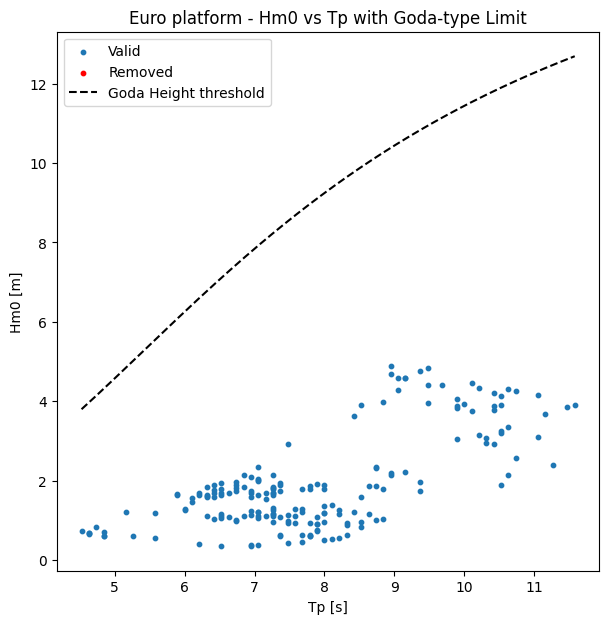

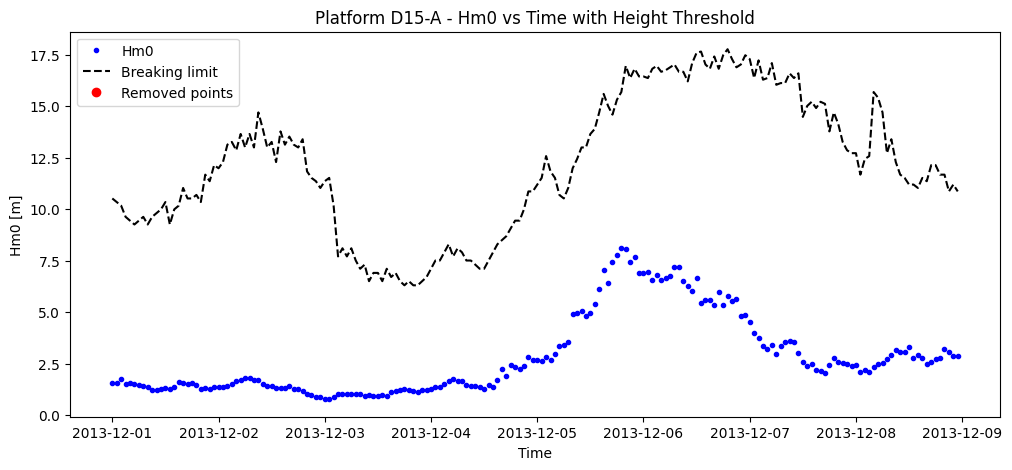

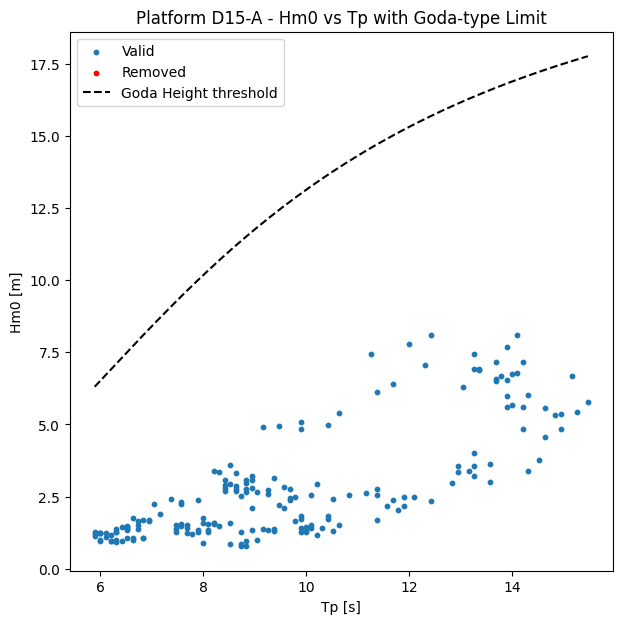

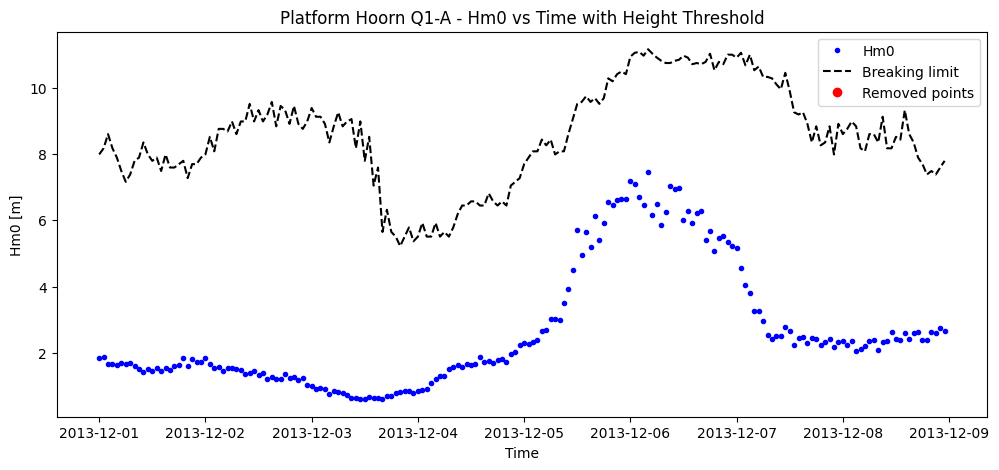

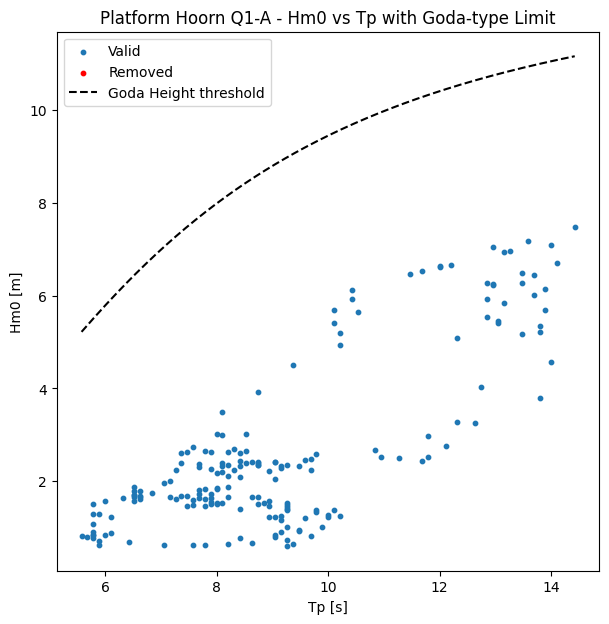

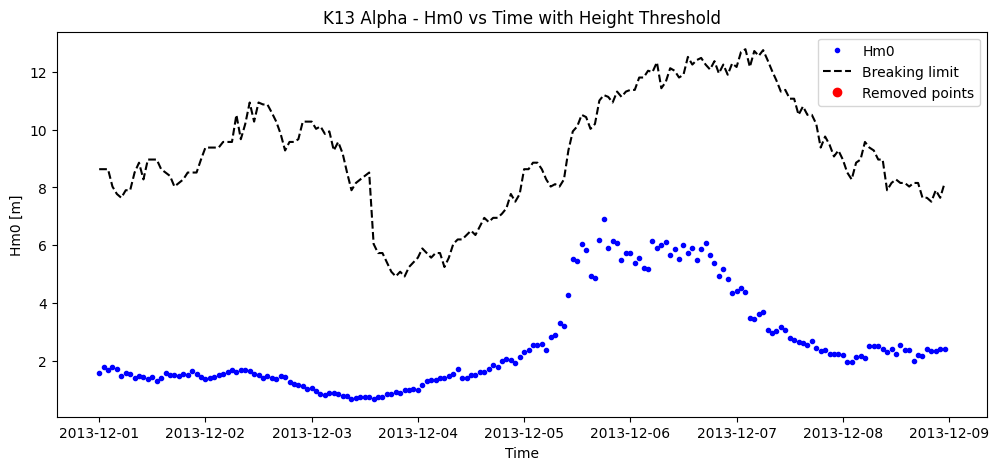

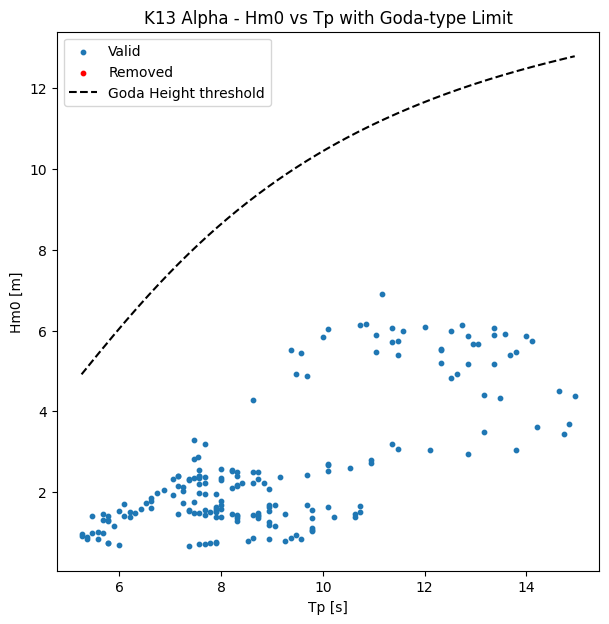

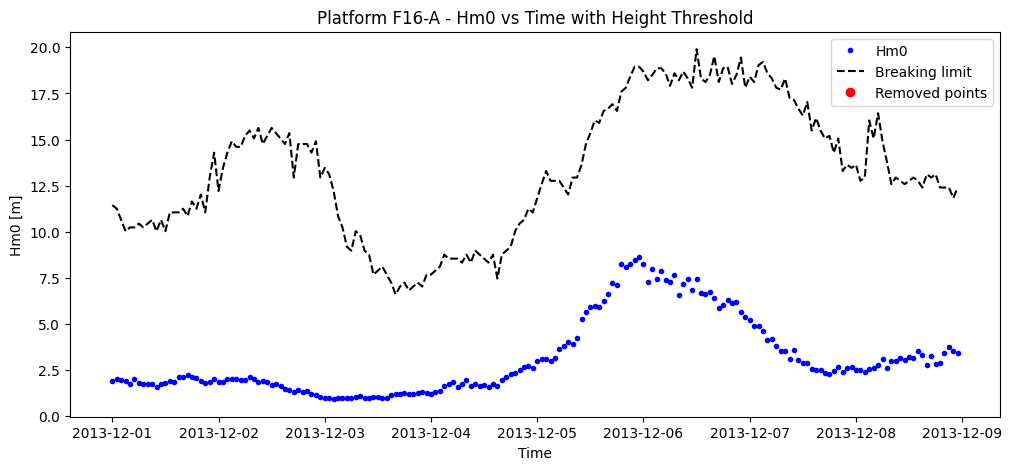

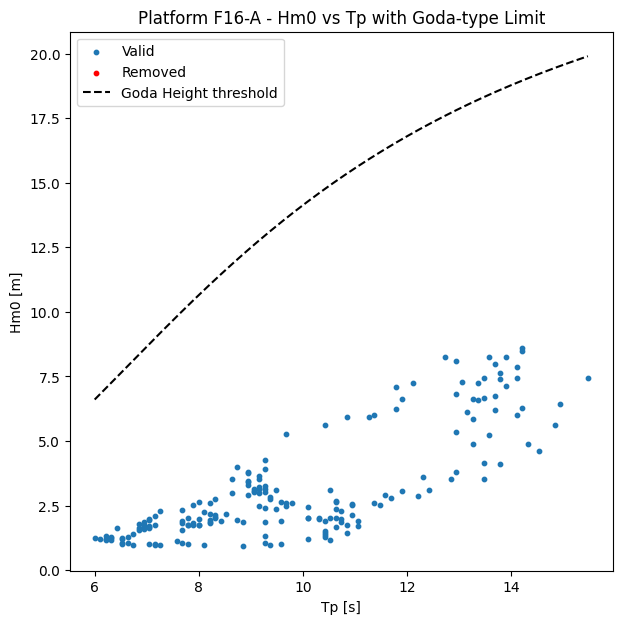

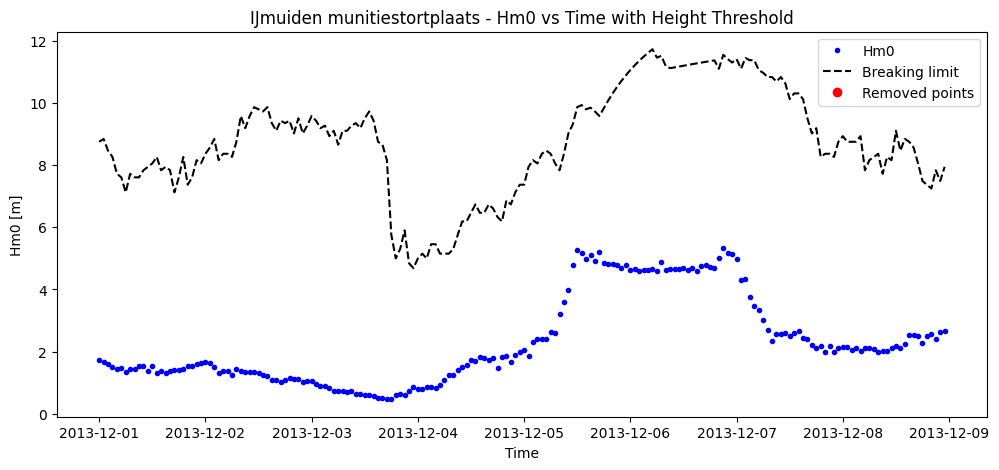

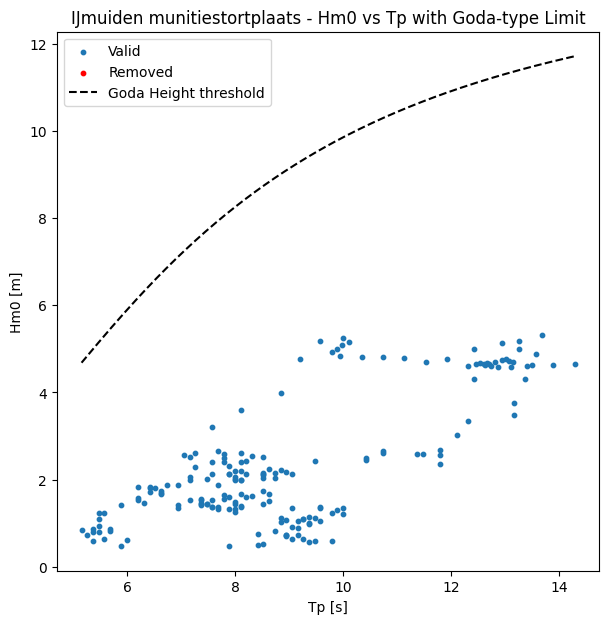

In [10]:

def remove_height_outliers(dict_used,  outdir, other_dict1, other_dict2, other_dict3, plot=False, station_for_plot=None, A=0.12, data_type="model"):
    """
    Remove outliers for Hm0 based on Miche-type breaking limit (height threshold).
    The threshold is applied only where BOTH Hm0 and Tp are non-NaN.

    Args:
        dict_used (dict): Dictionary of station datasets.
        other_dict1 (dict): Another dictionary to keep in sync with dict_used.
        other_dict2 (dict): Another dictionary to keep in sync with dict_used.
        plot (bool): Whether to plot time series and Hm0 vs Tp scatter.
        station_for_plot (str): If given, only plot for this station.
        A (float): Empirical constant in Miche-type formula (default ~0.88).
    """
    for station, dset in dict_used.items():
        # --- Pick Hm0, Tp, time ---
        def pick_first_available(dset, keys):
            for k in keys:
                if k in dset:
                    return dset[k]
            return None

        if isinstance(dset, pd.DataFrame):
            Hm0 = pick_first_available(dset, ["hm0", "point_hm0", "swh"])
            Tp  = pick_first_available(dset, ["t13", "point_tp", "pp1d"])
            time = dset.get("time", None)
        else:
            Hm0 = pick_first_available(dset, ["hm0", "point_hm0", "swh"])
            Tp  = pick_first_available(dset, ["t13", "point_tp", "pp1d"])
            time = dset.get("time", None)

        if Hm0 is None or Tp is None:
            print(f"Skipping {station} as Hm0 or Tp missing.")
            continue

        Hm0 = np.asarray(Hm0)
        Tp  = np.asarray(Tp)

        # Mask valid values
        valid_idx = ~np.isnan(Hm0) & ~np.isnan(Tp)
        if valid_idx.sum() < 2:
            print(f"Not enough valid data for {station}, skipping.")
            continue

        # Compute deep-water wavelength
        L0 = 9.81 * Tp[valid_idx]**2 / (2 * np.pi)

        # Assume depth hb is available or fixed (here using deep-water approx hb = L0/2 as example)
        hb = other_dict2[station]['point_depth'][0]

        # Miche-type breaking height limit
        Hb_limit = (A / (hb / L0)) * (1 - np.exp(-1.5 * np.pi * hb / L0)) * hb

        # Mask: keep rows below threshold
        mask = np.full_like(Hm0, True, dtype=bool)
        mask[valid_idx] = Hm0[valid_idx] <= Hb_limit

        # --- Apply mask helper ---
        def apply_mask(dataset, mask):
            if isinstance(dataset, pd.DataFrame):
                return dataset.loc[mask].copy()
            else:
                for key, arr in dataset.items():
                    if hasattr(arr, "__len__") and not isinstance(arr, (str, bytes)) and len(arr) == len(mask):
                        dataset[key] = np.asarray(arr)[mask]
                return dataset

        dict_used[station] = apply_mask(dset, mask)
        if station in other_dict1:
            other_dict1[station] = apply_mask(other_dict1[station], mask)
        if station in other_dict2:
            other_dict2[station] = apply_mask(other_dict2[station], mask)

        if station in other_dict3:
            other_dict3[station] = apply_mask(other_dict3[station], mask)

        # --- Optional plotting ---
        if plot and (station_for_plot is None or station == station_for_plot):
            outdir_plots = os.path.join(outdir, "Goda_plots")
            os.makedirs(outdir_plots, exist_ok=True)
            outpath = os.path.join(outdir_plots, f"{station}_Goda_timeseries.png")
            plt.figure(figsize=(12,5))
            plt.plot(time, Hm0, 'b.', label="Hm0")
            plt.plot(time[valid_idx], Hb_limit, 'k--', label="Breaking limit")
            plt.plot(time[~mask], Hm0[~mask], 'ro', label="Removed points")
            plt.ylabel("Hm0 [m]")
            plt.xlabel("Time")
            plt.legend()
            plt.title(f"{station} - Hm0 vs Time with Height Threshold")
            plt.savefig(outpath, dpi=300)

            

            # Scatter Hm0 vs Tp with steepness line
            outpath = os.path.join(outdir_plots, f"{station}_Goda_scatter.png")
            Tp_range = np.linspace(np.nanmin(Tp[mask]), np.nanmax(Tp[mask]), 200)
            L_range  = 9.81 * Tp_range**2 / (2 * np.pi)
            hb_range = hb  # constant depth for the plot
            Hb_limit_curve = (A / (hb_range / L_range)) * (1 - np.exp(-1.5 * np.pi * hb_range / L_range)) * hb_range

            plt.figure(figsize=(7,7))
            plt.scatter(Tp[mask], Hm0[mask], s=10, label="Valid")
            plt.scatter(Tp[~mask], Hm0[~mask], s=10, color="red", label="Removed")
            plt.plot(Tp_range, Hb_limit_curve, 'k--', label="Goda Height threshold")
            plt.xlabel("Tp [s]")
            plt.ylabel("Hm0 [m]")
            plt.legend()
            plt.title(f"{station} - Hm0 vs Tp with Goda-type Limit")
            plt.savefig(outpath, dpi=300)


# In[ ]:


def obs_length(d):
    # DataFrame
    if isinstance(d, pd.DataFrame):
        return len(d)
    # dict-of-arrays / dict-of-series
    if isinstance(d, dict):
        if 'time' in d and d['time'] is not None:
            try:
                return len(d['time'])
            except Exception:
                pass
        # fallback: pick first array-like value
        for v in d.values():
            if v is None:
                continue
            if isinstance(v, (str, bytes)):
                continue
            try:
                return len(v)
            except Exception:
                continue
        return 0
    # Series / ndarray / list
    try:
        return len(d)
    except Exception:
        return 0

print("Observation record counts per station (BEFORE Goda removal):")
for station in station_names:
    d = obs_data_per_station.get(station)
    n = obs_length(d)
    print(f"{station:30s}: {n}")

# --- Apply steepness-based filtering for Hm0 & Tp ---
remove_height_outliers(obs_data_per_station, output_dir, other_dict1=ERA5_data_per_station, other_dict2=data_per_station, other_dict3=small_data_per_station, plot=True)


# Print number of observation records per station (before Goda outlier removal)
def obs_length(d):
    # DataFrame
    if isinstance(d, pd.DataFrame):
        return len(d)
    # dict-of-arrays / dict-of-series
    if isinstance(d, dict):
        if 'time' in d and d['time'] is not None:
            try:
                return len(d['time'])
            except Exception:
                pass
        # fallback: pick first array-like value
        for v in d.values():
            if v is None:
                continue
            if isinstance(v, (str, bytes)):
                continue
            try:
                return len(v)
            except Exception:
                continue
        return 0
    # Series / ndarray / list
    try:
        return len(d)
    except Exception:
        return 0

print("Observation record counts per station (AFTER Goda removal):")
for station in station_names:
    d = obs_data_per_station.get(station)
    n = obs_length(d)
    print(f"{station:30s}: {n}")
variable_list_model = ['point_hm0', 'point_tp', 'point_wavdir']
variable_list_buoy = ['hm0', 't13', 'wavdir']
variable_list_era5 = ['swh', 'pp1d', 'mwd']

save_path_model = os.path.join(output_dir, "model_plots")
if not os.path.exists(save_path_model):
    os.makedirs(save_path_model)
save_path_buoy = os.path.join(output_dir, "buoy_plots")
if not os.path.exists(save_path_buoy):
    os.makedirs(save_path_buoy)

save_path_era5 = os.path.join(output_dir, "era5_plots")
if not os.path.exists(save_path_era5):
    os.makedirs(save_path_era5)




In [15]:
print(data_per_station['Euro platform']['point_tp'].shape)
print(small_data_per_station['Euro platform']['point_tp'].shape)
print(obs_data_per_station['Euro platform']['t13'].shape)

(191,)
(191,)
(192,)


In [ ]:
def plot_timeseries(data,station_names,variable_list,save_path,data_type):
                    
    # Plot model time series for all stations and variables
    for station in station_names:
        for var in variable_list:
            if var in data[station]:
                plt.figure(figsize=(10, 8))

                if data_type == "model":
                    plt.plot(data[station]['time'], data[station][var], label=var,color = 'blue')
                    plt.title(f"Model Time Series for variable {var} at {station}")
                    outpath = os.path.join(save_path, f"model_timeseries_{station}_{var}.png")
                elif data_type == "buoy":
                    plt.plot(data[station]['time'], data[station][var], label=var,color = 'orange')
                    plt.title(f"Buoy Time Series for variable {var} at {station}")
                    outpath = os.path.join(save_path, f"buoy_timeseries_{station}_{var}.png")
                elif data_type == "era5":
                    plt.plot(data[station]['time'], data[station][var], label=var,color = 'green')
                    plt.title(f"ERA5 Time Series for variable {var} at {station}")
                    outpath = os.path.join(save_path, f"era5_timeseries_{station}_{var}.png")
                plt.xlabel("Time")
                if var == 'point_hm0' or var == 'hm0' or var == 'swh':
                    plt.ylabel("Significant Wave Height (m)")
                elif var == 'point_tp' or var == 't13' or var == 'pp1d':
                    plt.ylabel("Peak Wave Period (s)")
                elif var == 'point_wavdir' or var == 'th0':
                    plt.ylabel("Wave Direction (°)")
                plt.legend()
                plt.tight_layout()
                plt.savefig(outpath, dpi=300)
                plt.close()

def scatter_plot_variable_variable(data_dict, variable1, variable2, unit_variable_1, unit_variable_2, station_names, data_type, save_path, plot_square=False):
    """
    For each station in station_names, plot a scatter plot of variable1 vs variable2.
    data_dict: dict of station_name -> dict or DataFrame with variables.
    variable1, variable2: str, variable names to plot.
    station_names: list of station names.
    save_path: directory to save plots.
    """
    for station in station_names:
        dset = data_dict.get(station)
        if dset is None:
            print(f"Station {station} not found in data_dict, skipping.")
            continue
        # Support both dict-of-arrays and dict-of-Series/DataFrame
        if isinstance(dset, dict):
            x = dset.get(variable1)
            y = dset.get(variable2)
        elif hasattr(dset, '__getitem__'):
            x = dset[variable1] if variable1 in dset else None
            y = dset[variable2] if variable2 in dset else None
        else:
            print(f"Data for station {station} is not in the expected format, skipping.")
            continue
        if x is None or y is None:
            print(f"Variables {variable1} or {variable2} not found for station {station}, skipping.")
            continue
        # Convert to numpy arrays for masking
        x_arr = x.values if hasattr(x, "values") else np.asarray(x)
        y_arr = y.values if hasattr(y, "values") else np.asarray(y)
        if x_arr.size == 0 or y_arr.size == 0:
            print(f"Variables {variable1} or {variable2} for station {station} are empty, skipping.")
            continue
        mask = np.isfinite(x_arr) & np.isfinite(y_arr)
        if not np.any(mask):
            continue

        plt.figure(figsize=(7, 7))
        if variable1 == 't13':
            title_variable1 = 'Tp'
        else:
            title_variable1 = variable1
        if variable2 == 't13':
            title_variable2 = 'Tp'
        else:
            title_variable2 = variable2

        if plot_square:
            plt.axis('square')
        if data_type == "model":
            plt.scatter(x_arr[mask], y_arr[mask], s=10, alpha=0.5, color='blue')
            plt.title(f"Model {title_variable2} vs {title_variable1} at {station}")
            outpath = os.path.join(save_path, f"scatter_{station.replace(' ', '_')}_{title_variable2}_vs_{title_variable1}.png")
        elif data_type == "buoy":
            plt.scatter(x_arr[mask], y_arr[mask], s=10, alpha=0.5, color='orange')
            plt.title(f"Buoy {title_variable2} vs {title_variable1} at {station}")
            outpath = os.path.join(save_path, f"scatter_{station.replace(' ', '_')}_{title_variable2}_vs_{title_variable1}.png")

        elif data_type == "era5":
            plt.scatter(x_arr[mask], y_arr[mask], s=10, alpha=0.5, color='green')
            plt.title(f"ERA5 {title_variable2} vs {title_variable1} at {station}")
            outpath = os.path.join(save_path, f"scatter_{station.replace(' ', '_')}_{title_variable2}_vs_{title_variable1}.png")

        plt.xlabel(f"{title_variable1} ({unit_variable_1})")
        plt.ylabel(f"{title_variable2} ({unit_variable_2})")
        
        plt.grid(True)
        plt.tight_layout()
        
        plt.savefig(outpath, dpi=200)
        plt.close()

def plot_hs_polar(data, station_names, save_path, data_type):
    """
    Create a polar plot with direction (deg) as angle, frequency (Hz) as radius (log scale), and wave height as color.
    Frequency ticks: 0.05, 0.1, 0.2, 0.3, 0.4 Hz.
    """
    import matplotlib.pyplot as plt

    freq_ticks = np.array([0.04, 0.1, 0.2, 0.3, 0.4])
    log_freq_ticks = np.log10(freq_ticks)
    rmin = log_freq_ticks[0]
    rmax = log_freq_ticks[-1]

    for station in station_names:
        dset = data[station]
        # Use peak period (point_tp or t13) to estimate frequency as 1/Tp
        if data_type == "model":
            dir_var = 'point_wavdir'
            height_var = 'point_hm0'
            if 'point_tp' in dset:
                period_var = 'point_tp'
            else:
                print(f"point_tp not found for {station}, skipping.")
                continue
        elif data_type == "buoy":
            dir_var = 'th0'
            height_var = 'hm0'
            if 't13' in dset:
                period_var = 't13'
            else:
                print(f"t13 not found for {station}, skipping.")
                continue

        elif data_type == "era5":
            dir_var = 'mwd'
            height_var = 'swh'
            if 'pp1d' in dset:
                period_var = 'pp1d'
            else:
                print(f"point_tp not found for {station}, skipping.")
                continue


        directions = dset[dir_var] if dir_var in dset else None
        periods = dset[period_var] if period_var in dset else None
        heights = dset[height_var] if height_var in dset else None

        if directions is None or heights is None or periods is None:
            print(f"Required variables not found or invalid for {station}, skipping.")
            continue

        # Estimate frequency as 1/Tp (in Hz)
        frequencies = 1.0 / np.asarray(periods)
        directions = np.asarray(directions).flatten()
        frequencies = np.asarray(frequencies).flatten()
        heights = np.asarray(heights).flatten()

        # Remove NaNs and restrict frequency range
        if directions.size == 0 or frequencies.size == 0 or heights.size == 0:
            print(f"Warning: directions, frequencies, or heights are empty for {station}, skipping.")
            continue

        mask = (~np.isnan(directions)) & (~np.isnan(frequencies)) & (~np.isnan(heights)) & (frequencies >= 0.04) & (frequencies <= 0.4)
        if not np.any(mask):
            print(f"No valid data for {station}, skipping.")
            continue

        # keep only points with wave height > 1 m
        mask_height = mask & (heights > 1.0)
        if not np.any(mask_height):
            print(f"No Hm0 > 1 m for {station}, skipping.")
            continue
        mask = mask_height

        theta = np.deg2rad(directions[mask])
        r = np.log10(frequencies[mask])
        c = heights[mask]

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, polar=True)
        sc = ax.scatter(theta, r, c=c, cmap='viridis', s=10, alpha=0.75)
        ax.set_ylim(rmin, rmax)
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)

        # Set custom log frequency ticks and labels
        ax.set_yticks(log_freq_ticks)
        ax.set_yticklabels([str(f) for f in freq_ticks])
        # ax.set_ylabel('Peak Frequency (Hz)', labelpad=40)

        cbar = plt.colorbar(sc, ax=ax, pad=0.1)
        cbar.set_label('Wave Height (m)')
        ax.set_title(f"{data_type.capitalize()} Hm0 polar spectrum \n at {station} \n for Hm0 > 1 m)\n")
        plt.tight_layout()
        fname = f"{data_type}_Hm0_polar_spectrum_{station.replace(' ', '_')}.png"
        plt.savefig(os.path.join(save_path, fname), dpi=200)
        plt.close()

def plot_wave_occurrence_polar(data, station_names, save_path, data_type):
    """
    Create a polar plot with direction (deg) as angle, frequency (Hz) as radius (log scale),
    and density of occurrence as colormap (2D histogram).
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    freq_ticks = np.array([0.04, 0.1, 0.2, 0.3, 0.4])
    log_freq_ticks = np.log10(freq_ticks)
    rmin = log_freq_ticks[0]
    rmax = log_freq_ticks[-1]

    for station in station_names:
        dset = data[station]

        if data_type == "model":
            dir_var = 'point_wavdir'
            if 'point_tp' in dset:
                period_var = 'point_tp'
            else:
                print(f"point_tp not found for {station}, skipping.")
                continue
        elif data_type == "buoy":
            dir_var = 'th0'
            if 't13' in dset:
                period_var = 't13'
            else:
                print(f"t13 not found for {station}, skipping.")
                continue
        elif data_type == "era5":
            dir_var = 'mwd'
            if 'pp1d' in dset:
                period_var = 'pp1d'
            else:
                print(f"point_tp not found for {station}, skipping.")
                continue

        directions = np.asarray(dset.get(dir_var)).flatten()
        periods = np.asarray(dset.get(period_var)).flatten()

        if directions.size == 0 or periods.size == 0:
            print(f"No data for {station}, skipping.")
            continue

        frequencies = 1.0 / periods
        mask = (~np.isnan(directions)) & (~np.isnan(frequencies)) & (frequencies >= 0.04) & (frequencies <= 0.4)
        if not np.any(mask):
            print(f"No valid data for {station}, skipping.")
            continue

        theta = np.deg2rad(directions[mask])
        r = np.log10(frequencies[mask])

        # 2D histogram
        nbins_dir = 72   # 5° bins
        nbins_freq = 40  # bins in log space
        H, theta_edges, r_edges = np.histogram2d(theta, r, bins=[nbins_dir, nbins_freq])

        Theta, R = np.meshgrid(theta_edges, r_edges, indexing='ij')



        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, polar=True)
        # Mask bins with counts <= 5 so they are not plotted
        H = H.astype(float)
        H_masked = np.ma.masked_where(H <= 5, H)

        # Make masked bins transparent
        cmap = plt.cm.viridis
        cmap.set_bad(alpha=0)

        pcm = ax.pcolormesh(Theta, R, H_masked, cmap=cmap)

        ax.set_ylim(rmin, rmax)
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)

        # Set custom log frequency ticks
        ax.set_yticks(log_freq_ticks)
        ax.set_yticklabels([str(f) for f in freq_ticks])
        # ax.set_ylabel('Peak Frequency (Hz)', labelpad=40)

        cbar = plt.colorbar(pcm, ax=ax, pad=0.1)
        cbar.set_label('Count of occurrences')
        ax.set_title(f"{data_type.capitalize()} wave occurrence spectrum \n at {station} \n for occurrences > 5\n")

        plt.tight_layout()
        fname = f"{data_type}_occurrence_polar_{station.replace(' ', '_')}.png"
        plt.savefig(os.path.join(save_path, fname), dpi=200)
        plt.close()

plot_timeseries(data_per_station,station_names,variable_list_model,save_path_model,data_type="model")
plot_timeseries(obs_data_per_station,station_names,variable_list_buoy,save_path_buoy,data_type="buoy")
plot_timeseries(ERA5_data_per_station,station_names,variable_list_era5,save_path_era5,data_type="era5")

scatter_plot_variable_variable(data_per_station, 'point_tp', 'point_hm0', 's', 'm', station_names, data_type="model", save_path=save_path_model)
scatter_plot_variable_variable(obs_data_per_station, 't13', 'hm0', 's', 'm', station_names, data_type="buoy", save_path=save_path_buoy)
scatter_plot_variable_variable(ERA5_data_per_station, 'pp1d', 'swh', 's', 'm', station_names, data_type="era5", save_path=save_path_era5)
scatter_plot_variable_variable(data_per_station, 'point_wavdir', 'point_hm0', '°', 'm', station_names, data_type="model", save_path=save_path_model)
scatter_plot_variable_variable(obs_data_per_station, 'th0', 'hm0', '°', 'm', station_names, data_type="buoy", save_path=save_path_buoy)
scatter_plot_variable_variable(ERA5_data_per_station, 'mwd', 'swh', '°', 'm', station_names, data_type="era5", save_path=save_path_era5)


plot_hs_polar(data_per_station, station_names, save_path_model, data_type="model")
plot_hs_polar(obs_data_per_station, station_names, save_path_buoy, data_type="buoy")
plot_hs_polar(ERA5_data_per_station, station_names, save_path_era5, data_type="era5")

plot_wave_occurrence_polar(data_per_station, station_names, save_path_model, data_type="model")
plot_wave_occurrence_polar(obs_data_per_station, station_names, save_path_buoy, data_type="buoy")
plot_wave_occurrence_polar(ERA5_data_per_station, station_names, save_path_era5, data_type="era5")




def compute_ursell_number(data_dict, depths, height_key="point_hm0", period_key="point_tp", depth_key="point_depth"):
    """
    Compute the Ursell number for each station and each timestep and store it as a new key "Ursell" in the dataset.

    Ursell number: U = (H * L^2) / (h^3)
    where:
        H = wave height (Hm0)
        L = wavelength (computed from period and depth)
        h = water depth

    Parameters:
        data_dict (dict): Dictionary of station datasets (model, obs, or ERA5).
        height_key (str): Key for wave height.
        period_key (str): Key for wave period.
        depth_key (str): Key for water depth.
    """
    g = 9.81

    for station, dset in data_dict.items():
        # Try to find keys for height, period, depth
        # Try alternative keys for obs/ERA5
        H = None
        Tp = None
        h = None

        # Try dict-of-arrays
        if isinstance(dset, dict):
            # Try model keys
            H = dset.get(height_key)
            Tp = dset.get(period_key)
            # Try obs keys if not found
            if H is None:
                H = dset.get("hm0")
            if Tp is None:
                Tp = dset.get("t13")
            if h is None:
                h = dset.get("point_depth")
            # Try ERA5 keys if not found
            if H is None:
                H = dset.get("swh")
            if Tp is None:
                Tp = dset.get("pp1d")
        else:
            # DataFrame: try columns
            H = dset.get(height_key) if height_key in dset else dset.get("hm0")
            Tp = dset.get(period_key) if period_key in dset else dset.get("t13")

        # Convert to arrays
        H = np.asarray(H) if H is not None else None
        Tp = np.asarray(Tp) if Tp is not None else None
        h = depths[station] if station in depths else None
        L = np.full_like(H, np.nan) if H is not None else None
        Ursell = np.full_like(H, np.nan) if H is not None else None

        for i in range(len(H)):
            if H is not None and Tp is not None and (i >= len(H) or i >= len(Tp)):
                print(f"Warning: Length mismatch at station {station}. H length: {len(H)}, Tp length: {len(Tp)}")
                break

            if np.isnan(H[i]) or np.isnan(Tp[i]) or h is None or h <= 0:
                L[i] = np.nan
                Ursell[i] = np.nan
                continue
            L[i] = wave_length_iterative(H[i], Tp[i], h,g,tol = 1e-4)
            Ursell[i] = (H[i] * L[i]**2) / (4*(np.pi**2)*(h**3)) if h > 0 else np.nan
            

        # Compute wavelength and Ursell number
        # Store in dict or DataFrame
        if isinstance(dset, dict):
            data_dict[station]["Length"] = L
            data_dict[station]["Ursell"] = Ursell
            data_dict[station]["Depth_criteria"] = h / L
            data_dict[station]["Wave_steepness"] = H / L
        else:
            dset["Ursell"] = Ursell
            dset["Length"] = L
            dset["Depth_criteria"] = h / L
            dset["Wave_steepness"] = H / L

# Example usage:
compute_ursell_number(data_per_station,depths)
compute_ursell_number(obs_data_per_station,depths)
compute_ursell_number(ERA5_data_per_station,depths)

# for station in station_names:
#     dset = data_per_station.get(station)
#     if dset is not None and "Ursell" in dset and "time" in dset:
#         Ursell = dset["Ursell"]
#         time = dset["time"]
#         plt.figure(figsize=(14, 4))
#         plt.plot(time, Ursell, label="Ursell number")
#         plt.title(f"Ursell Number Time Series at {station}")
#         plt.xlabel("Time")
#         plt.ylabel("Ursell number")
#         plt.grid(True)
#         plt.tight_layout()
#         plt.legend()
#         plt.show()

#     # Plot timeseries of steepness Hs/L if available
#     if "point_hm0" in dset and "Length" in dset and "time" in dset:
#         Hs = dset["point_hm0"]
#         L = dset["Length"]
#         t = dset["time"]
#         steepness = Hs / L
#         plt.figure(figsize=(14, 4))
#         plt.plot(t, steepness, label="Steepness (Hs/L)")
#         plt.title(f"Wave Steepness Time Series at {station}")
#         plt.xlabel("Time")
#         plt.ylabel("Hs / L")
#         plt.grid(True)
#         plt.tight_layout()
#         plt.legend()
#         plt.show()

#     # Plot timeseries of depth/length if available
#     if "Length" in dset and "time" in dset and station in depths:
#         L = dset["Length"]
#         h = depths[station]
#         t = dset["time"]
#         depth_over_length = h / L
#         plt.figure(figsize=(14, 4))
#         plt.plot(t, depth_over_length, label="Depth / Length")
#         plt.title(f"Depth/Length Time Series at {station}")
#         plt.xlabel("Time")
#         plt.ylabel("Depth / Length")
#         plt.grid(True)
#         plt.tight_layout()
#         plt.legend()
#         plt.show()


# In[78]:


def plot_Length_and_Ursell_timeseries(data,station_names,save_path,data_type,variable_list = ["Length","Ursell","Depth_criteria","Wave_steepness"]):
                    
    # Plot model time series for all stations and variables
    for station in station_names:
        for var in variable_list:
            if var in data[station]:
                plt.figure(figsize=(14, 4))

                if data_type == "model":
                    plt.plot(data[station]['time'], data[station][var], label=var,color = 'blue')
                    plt.title(f"Model Time Series for variable {var} at {station}")
                    outpath = os.path.join(save_path, f"model_timeseries_{station}_{var}.png")
                elif data_type == "buoy":
                    plt.plot(data[station]['time'], data[station][var], label=var,color = 'orange')
                    plt.title(f"Buoy Time Series for variable {var} at {station}")
                    outpath = os.path.join(save_path, f"buoy_timeseries_{station}_{var}.png")
                elif data_type == "era5":
                    plt.plot(data[station]['time'], data[station][var], label=var,color = 'green')
                    plt.title(f"ERA5 Time Series for variable {var} at {station}")
                    outpath = os.path.join(save_path, f"era5_timeseries_{station}_{var}.png")
                plt.xlabel("Time")
                if var == 'Length':
                    plt.ylabel("Wavelength (m)")
                elif var == 'Ursell':
                    plt.ylabel("Ursell Number (-)")
                elif var == 'Depth_criteria':
                    plt.ylabel("Depth/Length (-)")
                    plt.axhline(0.05, color='red', linestyle='--', label='Shallow water limit (h/L=0.05)')
                    plt.axhline(0.5, color='purple', linestyle='--', label='Deep water limit (h/L=0.5)')
                elif var == 'Wave_steepness':
                    plt.ylabel("Wave Steepness H/L (-)")
                plt.legend()
                plt.tight_layout()
                plt.savefig(outpath, dpi=300)
                plt.close()

plot_Length_and_Ursell_timeseries(data_per_station,station_names,save_path_model,"model")
plot_Length_and_Ursell_timeseries(obs_data_per_station,station_names,save_path_buoy,"buoy")
plot_Length_and_Ursell_timeseries(ERA5_data_per_station,station_names,save_path_era5,"era5")


In [ ]:
# In[61]:


pinball_quantiles = [0.05,0.1, 0.25, 0.5, 0.75, 0.9,0.95]

def _filter_valid_pairs(obs, pred):
    """Return obs and pred with NaNs removed (only keep entries where both are finite)."""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    mask = np.isfinite(obs) & np.isfinite(pred)
    if not np.any(mask):  # No valid data
        return np.array([]), np.array([])
    return obs[mask], pred[mask]

def rmse(obs, pred):
    """Root Mean Square Error with NaN handling"""
    obs, pred = _filter_valid_pairs(obs, pred)
    if obs.size == 0:
        return np.nan
    return np.sqrt(np.mean((pred - obs) ** 2))

def bias(obs, pred):
    """Mean Bias (Mean Error) with NaN handling"""
    obs, pred = _filter_valid_pairs(obs, pred)
    if obs.size == 0:
        return np.nan
    return np.mean(pred - obs)

def scatter_index(obs, pred):
    """Scatter Index: RMSE normalized by mean of observations, NaN safe"""
    obs, pred = _filter_valid_pairs(obs, pred)
    if obs.size == 0:
        return np.nan
    return rmse(obs, pred) / np.mean(obs)

def pinball_loss(obs, pred, quantile_pinball=0.5):
    """Pinball Loss Function for a given quantile, NaN safe"""
    obs, pred = _filter_valid_pairs(obs, pred)
    if obs.size == 0:
        return np.nan
    delta = obs - pred
    return np.mean(np.maximum(quantile_pinball * delta, (quantile_pinball - 1) * delta))

def pinball_loss_from_list(obs, pred, quantile_pinball_list):
    """Compute pinball loss for a list of quantiles, NaN safe"""
    obs, pred = _filter_valid_pairs(obs, pred)
    if obs.size == 0:
        return [np.nan] * len(quantile_pinball_list)
    losses = []
    delta = obs - pred
    for q in quantile_pinball_list:
        loss = np.mean(np.maximum(q * delta, (q - 1) * delta))
        losses.append(loss)
    return losses
def calculate_statistics(obs, pred,  quantile_pinball, print_stats=True):
    """Calculate RMSE, Bias, Scatter Index, and Pinball Loss for a given list of quantiles"""
    rmse_value = rmse(obs, pred) 
    bias_value = bias(obs, pred)
    scatter_index_value = scatter_index(obs, pred)
    pinball_loss_values = pinball_loss_from_list(obs, pred, quantile_pinball)

    # Print the statistics
    if print_stats:
        print('--------------------------------------------------')
        print(f"RMSE: {rmse_value:.4f}")
        print(f"Bias: {bias_value:.4f}")
        print(f"Scatter Index: {scatter_index_value:.4f}")
        for quantile, pinball_loss_value in zip(quantile_pinball, pinball_loss_values):
            print(f"Pinball Loss for quantile {quantile}: {pinball_loss_value:.4f}")
        print('--------------------------------------------------')

    return rmse_value, bias_value, scatter_index_value, pinball_loss_values

variable_mapping_era5 = {
    'point_hm0': 'swh',  
    'point_tp': 'pp1d',   
    # 'point_wavdir': 'mwd',    
}

variable_mapping_measurements = {
    'point_hm0': 'hm0',
    'point_tp': 't13',
    # 'point_wavdir': 'th0',
}

def map_variable_era5(variable):
    return variable_mapping_era5.get(variable, variable)

def map_list_of_variables_era5(variable_list):
    """
    Maps a list of variable names to their corresponding variables in the dataset.
    """
    return [map_variable_era5(var) for var in variable_list]


def map_variable_measurements(variable):
    return variable_mapping_measurements.get(variable, variable)

def map_list_of_variables_measurements(variable_list):
    """
    Maps a list of variable names to their corresponding variables in the dataset.
    """
    return [map_variable_measurements(var) for var in variable_list]


def make_list_of_variables(variable_mapping):
    """
    Maps a list of variable names to their corresponding variables in the dataset.

    Args:
        variable_list (list): The list of variable names to map.

    Returns:
        list: The list of original variable names (1st column of the mapping).
    """
    return list(variable_mapping.keys())

variable_list = make_list_of_variables(variable_mapping_era5)
era5_variable_list = map_list_of_variables_era5(variable_list)
measurement_variable_list = map_list_of_variables_measurements(variable_list)

def compute_statistics_for_all(observed_dict, predicted_dict, quantile_pinball):
    """
    Compute statistics for all stations and variables, comparing model to observations.

    Parameters:
    - observed_dict: nested dict like obs[station][variable] = values
    - predicted_dict: nested dict like pred[station][variable] = values
    - quantile_pinball: list of quantiles to use in pinball loss

    Returns:
    - df_statistics[station][variable][statistic][benchmark] = value
    """
    df_statistics = {}

    for station in observed_dict:
        df_statistics[station] = {}

        for variable in observed_dict[station]:
            obs = observed_dict[station][variable]
            pred = predicted_dict[station][variable]

            # Compute statistics
            print(f"Computing statistics for station: {station}, variable: {variable}")
            rmse_val, bias_val, si_val, pinball_vals = calculate_statistics(
                obs, pred, quantile_pinball=quantile_pinball, print_stats=True
            )

            # Store in nested dict
            df_statistics[station][variable] = {
                'RMSE': {'model_vs_obs': rmse_val},
                'Bias': {'model_vs_obs': bias_val},
                'Scatter Index': {'model_vs_obs': si_val},
            }
            for idx, q in enumerate(quantile_pinball):
                df_statistics[station][variable][f'Pinball Loss (q={q})'] = {'model_vs_obs': pinball_vals[idx]}

    return df_statistics

def compute_benchmark_statistics(
    model_dict,
    model_vars,
    era5_dict=None,
    buoy_dict=None,
    benchmarks=["buoy"],
    quantile_pinball=[],
    variable_mapping_era5=variable_mapping_era5,
    variable_mapping_measurement = variable_mapping_measurements,
):
    """
    Compute statistics comparing model data to selected benchmarks (ERA5 and/or buoys),
    only for a selected list of model variables.

    Parameters:
        model_dict: nested dict model[station][variable] = values
        model_vars: list of variables to compute statistics on (e.g. ["swh", "mwp"])
        era5_dict: optional, same structure as model_dict
        buoy_dict: optional, same structure as model_dict
        benchmarks: list of "era5", "buoy", or both
        quantile_pinball: list of quantiles for pinball loss
        map_variable_era5: function(str) -> str
        map_variable_buoy: function(str) -> str

    Returns:
        df_stats[station][model_variable][statistic][benchmark] = value
    """
    df_stats = {}

    for station in model_dict:
        df_stats[station] = {}

        for model_var in model_vars:
            if model_var not in model_dict[station]:
                continue

            model_values = model_dict[station][model_var]
            df_stats[station][model_var] = {}

            # === ERA5 benchmark ===
            if "era5" in benchmarks and era5_dict is not None and "buoy" in benchmarks and buoy_dict is not None:
                era5_var = map_variable_era5(model_var)
                buoy_var = map_variable_measurements(model_var)   
                if era5_var in era5_dict.get(station, {}):
                    obs_values = buoy_dict[station][buoy_var]
                    model_values = era5_dict[station][era5_var]

                    print(f"Computing ERA5 statistics for station: {station}, variable: {model_var}")
          

                    rmse_, bias_, si_, pinball_ = calculate_statistics(
                        obs_values, model_values,
                        quantile_pinball=quantile_pinball,
                        print_stats=True
                    )

                    df_stats[station][model_var].setdefault("RMSE", {})["era5"] = rmse_
                    df_stats[station][model_var].setdefault("Bias", {})["era5"] = bias_
                    df_stats[station][model_var].setdefault("Scatter Index", {})["era5"] = si_

                    counter = 0
                    for q in quantile_pinball:
                        df_stats[station][model_var].setdefault(f"Pinball Loss (q={q})", {})["era5"] = pinball_[counter]
                        counter += 1

            # === Buoy benchmark ===
            if "buoy" in benchmarks and buoy_dict is not None:
                buoy_var = map_variable_measurements(model_var)
                if buoy_var in buoy_dict.get(station, {}):
                    obs_values = buoy_dict[station][buoy_var]
                    model_values = model_dict[station][model_var]

                    print(f"Computing Buoy statistics for station: {station}, variable: {model_var}")

                    if obs_values is not None and np.size(obs_values) > 0:
                        rmse_, bias_, si_, pinball_ = calculate_statistics(
                            obs_values, model_values,
                            quantile_pinball=quantile_pinball,
                            print_stats=True
                        )
                    else:
                        rmse_ = np.nan
                        bias_ = np.nan
                        si_ = np.nan
                        pinball_ = [np.nan] * len(quantile_pinball)

                    df_stats[station][model_var].setdefault("RMSE", {})["buoy"] = rmse_
                    df_stats[station][model_var].setdefault("Bias", {})["buoy"] = bias_
                    df_stats[station][model_var].setdefault("Scatter Index", {})["buoy"] = si_
                    
                    for idx, q in enumerate(quantile_pinball):
                        df_stats[station][model_var].setdefault(f"Pinball Loss (q={q})", {})["buoy"] = pinball_[idx]

    return df_stats

df_statistics = compute_benchmark_statistics(
    data_per_station,
    variable_list,
    era5_dict=ERA5_data_per_station,
    buoy_dict=obs_data_per_station,	 
    quantile_pinball=pinball_quantiles,
    benchmarks=["buoy","era5"],
    variable_mapping_era5=variable_mapping_era5,
    variable_mapping_measurement=variable_mapping_measurements

)

small_df_statistics = compute_benchmark_statistics(
    small_data_per_station,
    variable_list,
    era5_dict=ERA5_data_per_station,
    buoy_dict=obs_data_per_station,	 
    quantile_pinball=pinball_quantiles,
    benchmarks=["buoy","era5"],
    variable_mapping_era5=variable_mapping_era5,
    variable_mapping_measurement=variable_mapping_measurements
)


# In[63]:


def _filter_valid_angle_pairs(obs, pred,time):
    """Return obs and pred with NaNs removed (only keep entries where both are finite)."""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    mask = np.isfinite(obs) & np.isfinite(pred)
    if not np.any(mask):  # No valid data
        return np.array([]), np.array([]),np.array([])
    return obs[mask], pred[mask], time[mask]

def angular_diffs(obs_angles, pred_angles):
    """Compute angular differences between observed and predicted angles."""
    obs_angles_rad = np.deg2rad(obs_angles)
    pred_angles_rad = np.deg2rad(pred_angles)
    angular_diffs_rad = np.arctan2(np.sin(pred_angles_rad - obs_angles_rad), np.cos(pred_angles_rad - obs_angles_rad))
    angular_diffs = np.rad2deg(angular_diffs_rad)
    return angular_diffs

def angular_RMSE(obs_angles, pred_angles):
    """Compute the angular RMSE between observed and predicted angles."""
    angular_diffs_values = angular_diffs(obs_angles, pred_angles)
    return np.sqrt(np.mean(angular_diffs_values ** 2)) if angular_diffs_values.size > 0 else np.nan

def create_df_directions(df_obs, df_model, df_era5, print_stats=True):
    df_directions = {}
    ERA5_angles = None
    
    for station in df_model.keys():
        obs_angles, pred_angles, time_angles = _filter_valid_angle_pairs(df_obs[station]['th0'], df_model[station]['point_wavdir'], df_model[station]['time'])

        if 'mwd' in df_era5[station]:
            ERA5_angles, _, _ = _filter_valid_angle_pairs(df_era5[station]['mwd'], df_obs[station]['th0'], df_model[station]['time'])


        angular_diffs_values_buoy = angular_diffs(obs_angles, pred_angles)
        mean_angle_error_buoy = np.mean(angular_diffs_values_buoy)
        stdev_angle_error_buoy = np.std(angular_diffs_values_buoy)
        angle_RMSE_buoy = angular_RMSE(obs_angles, pred_angles)
        wav_dir_error_normalised_buoy = (np.deg2rad(angular_diffs_values_buoy)) / (2 * np.pi)

        if ERA5_angles is not None:
            angular_diffs_values_era5 = angular_diffs(ERA5_angles, pred_angles)
            mean_angle_error_era5 = np.mean(angular_diffs_values_era5)
            stdev_angle_error_era5 = np.std(angular_diffs_values_era5)
            angle_RMSE_era5 = angular_RMSE(ERA5_angles, pred_angles)
            wav_dir_error_normalised_era5 = (np.deg2rad(angular_diffs_values_era5)) / (2 * np.pi)

            if print_stats:
                print(f"Directional statistics for ERA5 benchmark at station {station} and variable wave direction :")
                print(f"Mean Error (ERA5): {mean_angle_error_era5:.2f} degrees")
                print(f"Standard Deviation of Error (ERA5): {stdev_angle_error_era5:.2f} degrees")
                print(f"RMSE (ERA5): {angle_RMSE_era5:.2f} degrees")
                print("Normalised Mean Error (ERA5): "f"{np.mean(wav_dir_error_normalised_era5):.4f} (-)")
                print("Normalised Standard Deviation of Error (ERA5): "f"{np.std(wav_dir_error_normalised_era5):.4f} (-)")
                print(f"Normalised RMSE (ERA5): {np.deg2rad(angle_RMSE_era5) / (2 * np.pi):.4f} (-)")

                print("--------------------------------------------------")

                print(f"Directional statistics for buoy benchmark at station {station} and variable wave direction :")
                print(f"Mean Error (buoy): {mean_angle_error_buoy:.2f} degrees")
                print(f"Standard Deviation of Error (buoy): {stdev_angle_error_buoy:.2f} degrees")
                print(f"RMSE (buoy): {angle_RMSE_buoy:.2f} degrees")
                print("Normalised Mean Error (buoy): "f"{np.mean(wav_dir_error_normalised_buoy):.4f} (-)")
                print("Normalised Standard Deviation of Error (buoy): "f"{np.std(wav_dir_error_normalised_buoy):.4f} (-)")
                print(f"Normalised RMSE (buoy): {np.deg2rad(angle_RMSE_buoy) / (2 * np.pi):.4f} (-)")
                print("--------------------------------------------------")



            df_directions[station] = {
                'time': time_angles,
                'wavedir_obs': obs_angles,
                'wavedir_model': pred_angles,
                'wavedir_era5': ERA5_angles,
                'wavedir_error_buoy': angular_diffs_values_buoy,
                'wave_dir_error_normalised_buoy': wav_dir_error_normalised_buoy,
                'wavedir_error_mean_buoy': mean_angle_error_buoy,
                'wavedir_error_std_buoy': stdev_angle_error_buoy,
                'wave_dir_error_normalised_mean_buoy': np.mean(wav_dir_error_normalised_buoy),
                'wave_dir_error_normalised_std_buoy': np.std(wav_dir_error_normalised_buoy),
                'wavedir_rmse_buoy': angle_RMSE_buoy,
                'wave_dir_rmse_normalised_buoy': np.deg2rad(angle_RMSE_buoy) / (2 * np.pi),
                'wavedir_error_era5': angular_diffs_values_era5,
                'wave_dir_error_normalised_era5': wav_dir_error_normalised_era5,
                'wavedir_error_mean_era5': mean_angle_error_era5,
                'wavedir_error_std_era5': stdev_angle_error_era5,
                'wave_dir_error_normalised_mean_era5': np.mean(wav_dir_error_normalised_era5),
                'wave_dir_error_normalised_std_era5': np.std(wav_dir_error_normalised_era5),
                'wavedir_rmse_era5': angle_RMSE_era5,
                'wave_dir_rmse_normalised_era5': np.deg2rad(angle_RMSE_era5) / (2 * np.pi)
            }
        else:
            if print_stats:
                print("--------------------------------------------------")

                print(f"Directional statistics for buoy benchmark at station {station} and variable wave direction :")
                print(f"Mean Error (buoy): {mean_angle_error_buoy:.2f} degrees")
                print(f"Standard Deviation of Error (buoy): {stdev_angle_error_buoy:.2f} degrees")
                print(f"RMSE (buoy): {angle_RMSE_buoy:.2f} degrees")
                print("Normalised Mean Error (buoy): "f"{np.mean(wav_dir_error_normalised_buoy):.4f} (-)")
                print("Normalised Standard Deviation of Error (buoy): "f"{np.std(wav_dir_error_normalised_buoy):.4f} (-)")
                print(f"Normalised RMSE (buoy): {np.deg2rad(angle_RMSE_buoy) / (2 * np.pi):.4f} (-)")
                print("--------------------------------------------------")
            df_directions[station] = {
                'time': time_angles,
                'wavedir_obs': obs_angles,
                'wavedir_model': pred_angles,
                'wavedir_error_buoy': angular_diffs_values_buoy,
                'wave_dir_error_normalised_buoy': wav_dir_error_normalised_buoy,
                'wavedir_error_mean_buoy': mean_angle_error_buoy,
                'wavedir_error_std_buoy': stdev_angle_error_buoy,
                'wave_dir_error_normalised_mean_buoy': np.mean(wav_dir_error_normalised_buoy),
                'wave_dir_error_normalised_std_buoy': np.std(wav_dir_error_normalised_buoy),
                'wavedir_rmse_buoy': angle_RMSE_buoy,
                'wave_dir_rmse_normalised_buoy': np.deg2rad(angle_RMSE_buoy) / (2 * np.pi)
            }
    return df_directions


def plot_direction_error(df_directions, save_path,title,data_type):
    outpath = os.path.join(save_path, "direction")
    os.makedirs(outpath, exist_ok=True)

    for station, stats in df_directions.items():
        plt.figure(figsize=(10, 6))
        plt.scatter(stats['time'], stats[f'wavedir_error_{data_type}'], label='Wave Direction Error', s=10)
        plt.axhline(stats[f'wavedir_error_mean_{data_type}'], color='red', linestyle='--', label='Mean Error')
        plt.axhline(stats[f'wavedir_error_mean_{data_type}'] + stats[f'wavedir_error_std_{data_type}'], color='orange', linestyle='--', label='Mean + 1 Std Dev')
        plt.axhline(stats[f'wavedir_error_mean_{data_type}'] - stats[f'wavedir_error_std_{data_type}'], color='orange', linestyle='--', label='Mean - 1 Std Dev')
        plt.axhline(-180, color='gray', linestyle=':', linewidth=1)
        plt.axhline(0, color='black', linestyle='-', linewidth=1)
        plt.axhline(180, color='gray', linestyle=':', linewidth=1)
        plt.xticks(rotation=45)
        plt.yticks(list(plt.yticks()[0]) + [-180, 180])
        plt.ylim(-180, 180)
        plt.title(f"{title} for {station}")
        plt.xlabel("Time")
        plt.ylabel("Error (degrees)")
        # Annotate mean, stdev, and RMSE in the top right corner
        textstr = (
            f"Mean error: {stats[f'wavedir_error_mean_{data_type}']:.2f}°\n"
            f"Std error: {stats[f'wavedir_error_std_{data_type}']:.2f}°\n"
            f"RMSE error: {stats[f'wavedir_rmse_{data_type}']:.2f}°"
        )
        # Place the annotation inside the plot area, top right with some padding
        plt.gca().text(
            0.98, 0.02, textstr,
            transform=plt.gca().transAxes,
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
        )

        normalised_error = stats[f'wave_dir_error_normalised_{data_type}']
        normalised_mean = stats[f'wave_dir_error_normalised_mean_{data_type}']
        normalised_std = stats[f'wave_dir_error_normalised_std_{data_type}']
        normalised_rmse = stats[f'wave_dir_rmse_normalised_{data_type}']

        textstr_normalised = (
            f"Mean normalised error (Bias): {normalised_mean*100:.2f}%\n"
            f"Std normalised error: {normalised_std:.2f}\n"
            f"RMSE normalised error: {normalised_rmse:.2f}"
        )
        # Place the annotation inside the plot area, top right with some padding
        plt.gca().text(
            0.02, 0.98, textstr_normalised,
            transform=plt.gca().transAxes,
            fontsize=10,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
        )

        # Place legend in the top right corner
        plt.legend(loc='upper right')
        plt.savefig(os.path.join(outpath, f"{title}_{station.replace(' ', '_')}.png"))
        plt.close()

def plot_direction_error_at_dates(df_directions, save_path, data_type, day_start, month_start, year_start, day_end, month_end, year_end):
    outpath = os.path.join(save_path, "direction")
    os.makedirs(outpath, exist_ok=True)
    # Convert input start/end to numpy.datetime64 for comparison
    start = np.datetime64(f"{year_start:04d}-{month_start:02d}-{day_start:02d}")
    end = np.datetime64(f"{year_end:04d}-{month_end:02d}-{day_end:02d}")


    for station, stats in df_directions.items():
        # Filter by time range
        # Ensure stats['time'] is a numpy datetime64 array for comparison
        times = stats['time']
        if times.dtype != 'datetime64[ns]':
            times = times.astype('datetime64[ns]')
        mask = (times >= start) & (times <= end)
        if np.sum(mask) == 0:
            print(f"No data for {station} in selected date range.")
            continue

        times = stats['time'][mask]
        error = stats[f'wavedir_error_{data_type}'][mask]

        mean = error.mean()
        std = error.std()
        rmse = np.sqrt(((error - mean) ** 2).mean())

        normalised_error = stats[f'wave_dir_error_normalised_{data_type}'][mask]
        normalised_mean = normalised_error.mean()
        normalised_std = normalised_error.std()
        normalised_rmse = np.sqrt(((normalised_error - normalised_mean) ** 2).mean())

        plt.figure(figsize=(10, 6))
        plt.plot(times, error, label='Wave Direction Error')
        plt.axhline(mean, color='red', linestyle='--', label='Mean Error')
        plt.axhline(mean + std, color='orange', linestyle='--', label='Mean + 1 Std Dev')
        plt.axhline(mean - std, color='orange', linestyle='--', label='Mean - 1 Std Dev')
        plt.axhline(-180, color='gray', linestyle=':', linewidth=1)
        plt.axhline(0, color='black', linestyle='-', linewidth=1)
        plt.axhline(180, color='gray', linestyle=':', linewidth=1)
        plt.xticks(rotation=0)
        plt.yticks(list(plt.yticks()[0]) + [-180, 180])
        plt.ylim(-180, 180)
        plt.title(f"Wave Direction Error: {station} ({start} to {end})")
        plt.xlabel("Time")
        plt.ylabel("Error (degrees)")
        # Annotate mean, stdev, and RMSE in the top right corner
        textstr = (
            f"Mean error (Bias): {mean:.2f}°\n"
            f"Std error: {std:.2f}°\n"
            f"RMSE error: {rmse:.2f}°"
        )
        # Place the annotation inside the plot area, top right with some padding
        plt.gca().text(
            0.98, 0.02, textstr,
            transform=plt.gca().transAxes,
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
        )
                # Annotate mean, stdev, and RMSE in the top right corner
        textstr_normalised = (
            f"Mean normalised error (Bias): {normalised_mean*100:.2f}%\n"
            f"Std normalised error: {normalised_std:.2f}\n"
            f"RMSE normalised error: {normalised_rmse:.2f}"
        )
        # Place the annotation inside the plot area, top right with some padding
        plt.gca().text(
            0.02, 0.98, textstr_normalised,
            transform=plt.gca().transAxes,
            fontsize=10,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
        )
        # Place legend in the top right corner
        plt.legend(loc='upper right')
        plt.savefig(os.path.join(outpath, f"{data_type}_Mean_direction_error_{station.replace(' ', '_')}_between_{start}_and_{end}.png"))
        plt.close()

def plot_direction_at_dates(df_directions, save_path, data_type, day_start, month_start, year_start, day_end, month_end, year_end):
    outpath = os.path.join(save_path, "direction")
    os.makedirs(outpath, exist_ok=True)
    # Convert input start/end to numpy.datetime64 for comparison
    start = np.datetime64(f"{year_start:04d}-{month_start:02d}-{day_start:02d}")
    end = np.datetime64(f"{year_end:04d}-{month_end:02d}-{day_end:02d}")

    for station, stats in df_directions.items():
        plot_buoy=True
        # Filter by time range
        # Ensure stats['time'] is a numpy datetime64 array for comparison
        times = stats['time']
        if times.dtype != 'datetime64[ns]':
            times = times.astype('datetime64[ns]')
        mask = (times >= start) & (times <= end)
        if np.sum(mask) == 0:
            print(f"No data for {station} in selected date range.")
            plot_buoy = False

        times = stats['time'][mask]
        obs = stats[f'wavedir_obs_{data_type}'][mask]
        model = stats[f'wavedir_model_{data_type}'][mask]

        plt.figure(figsize=(12, 6))
        plt.plot(times, obs, label='Observed Direction', color='tab:blue')
        if plot_buoy:
            plt.plot(times, model, label='Model Direction', color='tab:orange')
        plt.ylim(-10, 370)
        plt.ylabel('Wave Direction (deg)')
        plt.xlabel('Time')
        plt.title(f"{data_type}_Mean Wave Direction: {station} ({start} to {end})")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(outpath, f"{data_type}_Mean_direction_timeseries_{station.replace(' ', '_')}_between_{start}_and_{end}.png"))
        plt.close()

def plot_direction(df_directions, save_path):
    outpath = os.path.join(save_path, "direction")
    os.makedirs(outpath, exist_ok=True)

    for station, stats in df_directions.items():
        times = stats['time']
        obs = stats[f'wavedir_obs']
        model = stats[f'wavedir_model']

        if 'wavedir_era5' in df_directions[station]:

            if df_directions[station]['wavedir_era5'] is not None and len(df_directions[station]['wavedir_era5']) > 0:
                era5 = stats[f'wavedir_era5']

        plt.figure(figsize=(12, 6))

        if 'wavedir_era5' in df_directions[station]:
            if df_directions[station]['wavedir_era5'] is not None and len(df_directions[station]['wavedir_era5']) > 0:
                plt.plot(times, era5, label='ERA5 Direction', color='tab:green', marker='x', markersize=4)
        if df_directions[station]['wavedir_model'] is not None and len(df_directions[station]['wavedir_model']) > 0:
            plt.plot(times, obs, label='Observed Direction', color='tab:orange', marker='o', markersize=4)
        
        plt.plot(times, model, label='Model Direction', color='tab:blue')
        plt.ylim(-10, 370)
        plt.ylabel('Wave Direction (deg)')
        plt.xlabel('Time')
        plt.title(f"Mean Wave Direction: {station}")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(outpath, f"Mean_direction_timeseries_{station.replace(' ', '_')}.png"))
        plt.close()

def plot_direction_error_histogram(df_directions, save_path, title, data_type):
    outpath = os.path.join(save_path, "direction")
    os.makedirs(outpath, exist_ok=True)

    for station, stats in df_directions.items():
        errors = stats[f'wavedir_error_{data_type}']
        # Remove NaNs if errors is a numpy array
        if isinstance(errors, np.ndarray):
            errors = errors[~np.isnan(errors)]
        # If it's a pandas Series, use dropna
        elif hasattr(errors, 'dropna'):
            errors = errors.dropna()

        plt.figure(figsize=(10, 6))
        # Histogram
        plt.hist(errors, bins=72, color='steelblue', edgecolor='black', alpha=0.7)
        
        # Add vertical lines for mean and ± std
        mean_error = stats[f'wavedir_error_mean_{data_type}']
        std_error = stats[f'wavedir_error_std_{data_type}']
        rmse_error = stats[f'wavedir_rmse_{data_type}']
        
        plt.axvline(mean_error, color='red', linestyle='--', label=f"Mean: {mean_error:.2f}°")
        plt.axvline(mean_error + std_error, color='orange', linestyle='--', label=f"Mean ± Std Dev")
        plt.axvline(mean_error - std_error, color='orange', linestyle='--')

        # Text box with error stats
        textstr = (
            f"Mean error: {mean_error:.2f}°\n"
            f"Std error: {std_error:.2f}°\n"
            f"RMSE error: {rmse_error:.2f}°"
        )
        plt.gca().text(
            0.98, 0.95, textstr,
            transform=plt.gca().transAxes,
            fontsize=10,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
        )

        # Normalised stats
        normalised_mean = stats[f'wave_dir_error_normalised_mean_{data_type}']
        normalised_std = stats[f'wave_dir_error_normalised_std_{data_type}']
        normalised_rmse = stats[f'wave_dir_rmse_normalised_{data_type}']

        textstr_normalised = (
            f"Mean normalised error (Bias): {normalised_mean*100:.2f}%\n"
            f"Std normalised error: {normalised_std:.2f}\n"
            f"RMSE normalised error: {normalised_rmse:.2f}"
        )
        plt.gca().text(
            0.02, 0.95, textstr_normalised,
            transform=plt.gca().transAxes,
            fontsize=10,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
        )

        plt.title(f"{title} for {station}")
        plt.xlabel("Error (degrees)")
        plt.ylabel("Frequency")
        plt.xticks(np.arange(-180, 181, 15))
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()

        plt.savefig(os.path.join(outpath, f"{title}_hist_{station.replace(' ', '_')}.png"))
        plt.close()

df_directions = create_df_directions(obs_data_per_station, data_per_station, ERA5_data_per_station, print_stats=True)

plot_direction(df_directions, output_dir)
plot_direction_error(df_directions, output_dir,"HurryWave model Mean wave direction error", "buoy")
plot_direction_error_histogram(df_directions, output_dir, "HurryWave model Mean wave direction error histogram", "buoy")
plot_direction_error(df_directions, output_dir,"ERA5 Mean wave direction error", "era5")
plot_direction_error_histogram(df_directions, output_dir, "ERA5 Mean wave direction error histogram", "era5")


# In[64]:


def plot_mean_station_data_comparison(
    station_name,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    output_dir=None,
    show_map=True
):
    """
    Plot yearly means for selected variables at a single station, comparing model, ERA5, and/or buoy data.
    """

    if model_vars is None:
        model_vars = [v for v in model_df.get(station_name, {}).keys()
                      if v not in ["time", "station_x", "station_y"]]

    n_vars = len(model_vars)
    plot_height = 0.18
    plot_space = 0.10  # increased spacing

    # Calculate space for title
    title_height = 0.08

    if show_map:
        fig = plt.figure(figsize=(14, 3 * n_vars + 5))
        # Move title above first plot
        fig.suptitle(f'Yearly Means at {station_name}', fontsize=16, y=1.0)

        # Map
        map_ax = fig.add_axes([0.05, 0.85, 0.6, 0.12])
        m = Basemap(projection='merc', llcrnrlat=50, urcrnrlat=65,
                    llcrnrlon=-5, urcrnrlon=10, resolution='i', ax=map_ax)
        m.drawcoastlines()
        m.fillcontinents(color='lightgray', lake_color='aqua')
        m.drawmapboundary(fill_color='aqua')

        lat = float(model_df[station_name]["station_y"])
        lon = float(model_df[station_name]["station_x"])
        x, y = m(lon, lat)
        m.plot(x, y, 'ro', markersize=8)
        map_ax.text(x, y, f' {station_name}', fontsize=10, color='black')

        axs = []
        for i in range(n_vars):
            bottom = 0.65 - i * (plot_height + plot_space)
            ax = fig.add_axes([0.1, bottom, 0.75, plot_height])
            axs.append(ax)
    else:
        fig = plt.figure(figsize=(14, 3 * n_vars + 2))
        # Move title above first plot
        fig.suptitle(f'Yearly Means at {station_name}', fontsize=16, y=1.0)

        axs = []
        for i in range(n_vars):
            # Shift plots down to make space for title
            bottom = 0.85 - i * (plot_height + plot_space) - title_height
            ax = fig.add_axes([0.1, bottom, 0.75, plot_height])
            axs.append(ax)

    # Convert model time to pandas datetime
    time = pd.to_datetime(model_df[station_name]["time"])

    def yearly_mean(data, time_index):
        series = pd.Series(data, index=pd.to_datetime(time_index))
        return series.resample("YE").mean()

    for i, var in enumerate(model_vars):
        ax = axs[i]
        ax.grid(True)

        # Units
        if var in ['point_tp', 'pp1d', 't13','tp']:
            unit ='s'
        elif var in ['point_hm0', 'hm0','hs','swh']:
            unit ='m'
        elif var in ['point_wavdir']:
            unit ='deg'
        else:
            unit =''

        # Model
        if var in model_df[station_name]:
            model_yearly = yearly_mean(model_df[station_name][var], time)
            ax.plot(model_yearly.index.year, model_yearly.values,
                    '-o', label="HurryWave Model", color='blue')

        # ERA5
        if "era5" in benchmarks and era5_df:
            era5_var = map_variable_era5.get(var, var) if map_variable_era5 else var
            if era5_var in era5_df.get(station_name, {}):
                era5_yearly = yearly_mean(era5_df[station_name][era5_var], time)
                ax.plot(era5_yearly.index.year, era5_yearly.values,
                           '-x', label="ERA5", color='green', alpha=0.6)

        # Buoy
        if "buoy" in benchmarks and buoy_df:
            buoy_var = map_variable_buoy.get(var, var) if map_variable_buoy else var
            if buoy_var in buoy_df.get(station_name, {}) and np.size(buoy_df[station_name][buoy_var]) == np.size(time):
                buoy_yearly = yearly_mean(buoy_df[station_name][buoy_var], time)
                ax.plot(buoy_yearly.index.year, buoy_yearly.values,
                           '-o', label="Buoy", color='orange', alpha=0.6)

        ax.set_title(f"{var} ({unit})")
        ax.set_ylabel(f"{var} ({unit})")
        ax.set_xticks(model_yearly.index.year)
        ax.tick_params(axis="x", rotation=45)
        ax.legend(loc='upper right', fontsize=8)


    axs[-1].set_xlabel("Year")
    output_path = os.path.join(output_dir, f'Yearly_means_at_{station_name}.png')
    fig.savefig(output_path, dpi=300, bbox_inches='tight')

def plot_mean_all_stations(
    station_names,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    output_dir=output_dir,
    show_map=True):

    """
    Plot time series for selected variables at all stations, comparing model, ERA5, and/or buoy data.
    Includes a map with the station locations and a side panel showing statistical metrics.
    Parameters:
        station_names (list of str): Names of the station to plot.
        model_df (dict): Nested dict model[station][variable] = values.
        era5_df (dict): Same structure as model_df for ERA5 (optional).
        buoy_df (dict): Same structure as model_df for buoy data (optional).
        model_vars (list): Model variable names to include in the plot.
        benchmarks (list): Which benchmarks to include ("era5", "buoy", or both).
        variable_mapping_era5 (dict): Mapping from model vars to ERA5 vars.
        variable_mapping_buoy (dict): Mapping from model vars to buoy vars.
        df_statistics (dict): Nested dict of statistics.
    """
    
    for station_name in station_names:
        plot_mean_station_data_comparison(
            station_name,
            model_df,
            era5_df=era5_df,
            buoy_df=buoy_df,
            model_vars=model_vars,
            benchmarks=benchmarks,
            map_variable_era5=map_variable_era5,
            map_variable_buoy=map_variable_buoy,
            output_dir=output_dir,
            show_map=show_map
        )

plot_mean_all_stations(
    station_names=station_names,
    model_df=data_per_station,
    buoy_df=obs_data_per_station,
    era5_df=ERA5_data_per_station,
    model_vars=variable_list,
    benchmarks=["buoy","era5"],
    map_variable_era5=variable_mapping_era5,
    map_variable_buoy=variable_mapping_measurements,
    output_dir=output_dir,
    show_map=False
)



def plot_std_station_data_comparison(
    station_name,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    output_dir=None,
    show_map=True
):
    """
    Plot yearly means for selected variables at a single station, comparing model, ERA5, and/or buoy data.
    """

    if model_vars is None:
        model_vars = [v for v in model_df.get(station_name, {}).keys()
                      if v not in ["time", "station_x", "station_y"]]

    n_vars = len(model_vars)
    plot_height = 0.18
    plot_space = 0.10  # increased spacing

    # Calculate space for title
    title_height = 0.08

    if show_map:
        fig = plt.figure(figsize=(14, 3 * n_vars + 5))
        # Move title above first plot
        fig.suptitle(f'Yearly Means at {station_name}', fontsize=16, y=1.0)

        # Map
        map_ax = fig.add_axes([0.05, 0.85, 0.6, 0.12])
        m = Basemap(projection='merc', llcrnrlat=50, urcrnrlat=65,
                    llcrnrlon=-5, urcrnrlon=10, resolution='i', ax=map_ax)
        m.drawcoastlines()
        m.fillcontinents(color='lightgray', lake_color='aqua')
        m.drawmapboundary(fill_color='aqua')

        lat = float(model_df[station_name]["station_y"])
        lon = float(model_df[station_name]["station_x"])
        x, y = m(lon, lat)
        m.plot(x, y, 'ro', markersize=8)
        map_ax.text(x, y, f' {station_name}', fontsize=10, color='black')

        axs = []
        for i in range(n_vars):
            bottom = 0.65 - i * (plot_height + plot_space)
            ax = fig.add_axes([0.1, bottom, 0.75, plot_height])
            axs.append(ax)
    else:
        fig = plt.figure(figsize=(14, 3 * n_vars + 2))
        # Move title above first plot
        fig.suptitle(f'Yearly Standard deviations at {station_name}', fontsize=16, y=1.0)

        axs = []
        for i in range(n_vars):
            # Shift plots down to make space for title
            bottom = 0.85 - i * (plot_height + plot_space) - title_height
            ax = fig.add_axes([0.1, bottom, 0.75, plot_height])
            axs.append(ax)

    # Convert model time to pandas datetime
    time = pd.to_datetime(model_df[station_name]["time"])

    def yearly_std(data, time_index):
        series = pd.Series(data, index=pd.to_datetime(time_index))
        return series.resample("YE").std()

    for i, var in enumerate(model_vars):
        ax = axs[i]
        ax.grid(True)

        # Units
        if var in ['point_tp', 'pp1d', 't13','tp']:
            unit ='s'
        elif var in ['point_hm0', 'hm0','hs','swh']:
            unit ='m'
        elif var in ['point_wavdir']:
            unit ='deg'
        else:
            unit =''

        # Model
        if var in model_df[station_name]:
            model_yearly = yearly_std(model_df[station_name][var], time)
            ax.plot(model_yearly.index.year, model_yearly.values,
                    '-o', label="HurryWave Model", color='blue')

        # ERA5
        if "era5" in benchmarks and era5_df:
            era5_var = map_variable_era5.get(var, var) if map_variable_era5 else var
            if era5_var in era5_df.get(station_name, {}):
                era5_yearly = yearly_std(era5_df[station_name][era5_var], time)
                ax.plot(era5_yearly.index.year, era5_yearly.values,
                           '-x', label="ERA5", color='green', alpha=0.6)

        # Buoy
        if "buoy" in benchmarks and buoy_df:
            buoy_var = map_variable_buoy.get(var, var) if map_variable_buoy else var
            if buoy_var in buoy_df.get(station_name, {}) and np.size(buoy_df[station_name][buoy_var]) == np.size(time):
                buoy_yearly = yearly_std(buoy_df[station_name][buoy_var], time)
                ax.plot(buoy_yearly.index.year, buoy_yearly,
                           '-o', label="Buoy", color='orange', alpha=0.6)

        ax.set_title(f"{var} ({unit})")
        ax.set_ylabel(f"{var} ({unit})")
        ax.set_xticks(model_yearly.index.year)
        ax.tick_params(axis="x", rotation=45)
        ax.legend(loc='upper right', fontsize=8)


    axs[-1].set_xlabel("Year")
    output_path = os.path.join(output_dir, f'Yearly_Standard_deviations_at_{station_name}.png')
    fig.savefig(output_path, dpi=300, bbox_inches='tight')

def plot_std_all_stations(
    station_names,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    output_dir=output_dir,
    show_map=True):

    """
    Plot time series for selected variables at all stations, comparing model, ERA5, and/or buoy data.
    Includes a map with the station locations and a side panel showing statistical metrics.
    Parameters:
        station_names (list of str): Names of the station to plot.
        model_df (dict): Nested dict model[station][variable] = values.
        era5_df (dict): Same structure as model_df for ERA5 (optional).
        buoy_df (dict): Same structure as model_df for buoy data (optional).
        model_vars (list): Model variable names to include in the plot.
        benchmarks (list): Which benchmarks to include ("era5", "buoy", or both).
        variable_mapping_era5 (dict): Mapping from model vars to ERA5 vars.
        variable_mapping_buoy (dict): Mapping from model vars to buoy vars.
        df_statistics (dict): Nested dict of statistics.
    """
    
    for station_name in station_names:
        plot_std_station_data_comparison(
            station_name,
            model_df,
            era5_df=era5_df,
            buoy_df=buoy_df,
            model_vars=model_vars,
            benchmarks=benchmarks,
            map_variable_era5=map_variable_era5,
            map_variable_buoy=map_variable_buoy,
            output_dir=output_dir,
            show_map=show_map
        )

plot_std_all_stations(
    station_names=station_names,
    model_df=data_per_station,
    buoy_df=obs_data_per_station,
    era5_df=ERA5_data_per_station,
    model_vars=variable_list,
    benchmarks=["buoy","era5"],
    map_variable_era5=variable_mapping_era5,
    map_variable_buoy=variable_mapping_measurements,
    output_dir=output_dir,
    show_map=False
)



# In[65]:


def plot_station_analysis_comparison(
    station_name,
    model_df,
    era5_df=None,
    buoy_df=None,
    depths=None,
    datasets=["model","era5", "buoy"],
    output_dir=output_dir,
    show_map=False
):
    """
    Plot derived variables (h/L, Steepness, Ursell) for a single station,
    for all available datasets (model, ERA5, buoy) in a unified style.
    """

    # Prepare figure and axes
    fig_height = 12
    fig, axs = plt.subplots(3, 1, figsize=(14, fig_height), sharex=True)
    fig.suptitle(f'Analysis at {station_name}', fontsize=16)

    # Get time from model_df
    time = model_df[station_name]["time"]

    # Define colors for each dataset
    dataset_colors = {"model": "blue", "era5": "green", "buoy": "orange"}
    dataset_linestyles = {"model": "-", "era5": ":", "buoy": ":"}
    dataset_alpha = {"model": 1.0, "era5": 0.7, "buoy": 0.7}

    # --- h/L ---
    for ds in datasets:
        if ds == "model":
            df = model_df
        elif ds == "era5" and era5_df:
            df = era5_df
        elif ds == "buoy" and buoy_df:
            df = buoy_df
        else:
            continue

        if depths and station_name in depths and "Length" in df[station_name]:
            h_over_L = depths[station_name] / df[station_name]["Length"]
            axs[0].plot(time, h_over_L, color=dataset_colors[ds], linestyle=dataset_linestyles[ds], label=ds, alpha=dataset_alpha[ds])
    
    axs[0].set_ylabel("h/L (-)")
    axs[0].grid(True) 
    axs[0].axhline(0.05, color='grey', linestyle='--', linewidth=1, label="Boundary between shallow and intermediate water")
    axs[0].axhline(0.5, color='black', linestyle='--', linewidth=1, label="Boundary between intermediate and deep water")
    axs[0].set_xlabel("Time")
    # axs[0].text(time[0], 0.025, "Shallow water", color='black', va='bottom', ha='left', fontsize=10, fontweight='bold')
    # axs[0].text(time[0], 0.275, "Intermediate water", color='black', va='center', ha='left', fontsize=10, fontweight='bold')
    # axs[0].text(time[0], 0.52, "Deep water", color='black', va='bottom', ha='left', fontsize=10, fontweight='bold')

    # --- Steepness ---
    for ds in datasets:
        if ds == "model":
            df = model_df
        elif ds == "era5" and era5_df:
            df = era5_df
        elif ds == "buoy" and buoy_df:
            df = buoy_df
        else:
            continue

        if "hm0" in df[station_name] and "Length" in df[station_name]:
            steepness = df[station_name]["hm0"] / df[station_name]["Length"]
        elif "point_hm0" in df[station_name] and "Length" in df[station_name]:
            steepness = df[station_name]["point_hm0"] / df[station_name]["Length"]
        elif "swh" in df[station_name] and "Length" in df[station_name]:
            steepness = df[station_name]["swh"] / df[station_name]["Length"]
        else:
            steepness = None

        if steepness is not None:
            axs[1].plot(time, steepness, color=dataset_colors[ds], linestyle=dataset_linestyles[ds], label=ds, alpha=dataset_alpha[ds])

    axs[1].set_ylabel("Steepness (-)")
    axs[1].grid(True)
    axs[1].set_xlabel("Time")

    # --- Ursell ---
    for ds in datasets:
        if ds == "model":
            df = model_df
        elif ds == "era5" and era5_df:
            df = era5_df
        elif ds == "buoy" and buoy_df:
            df = buoy_df
        else:
            continue

        if "Ursell" in df[station_name]:
            axs[2].plot(time, df[station_name]["Ursell"], color=dataset_colors[ds], linestyle=dataset_linestyles[ds], label=ds, alpha=dataset_alpha[ds])

    axs[2].set_ylabel("Ursell (-)")
    axs[2].grid(True)
    axs[2].set_xlabel("Time")

    for ax in axs:
        ax.tick_params(labelbottom=True)
        ax.legend(loc = 'upper right', fontsize=8)


    output_path = os.path.join(output_dir, f'Analysis_graph_all_datasets_at_{station_name}.png')
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close(fig)


def plot_analysis_all_stations_comparison(
    station_names,
    model_df,
    era5_df=None,
    buoy_df=None,
    depths=None,
    datasets=["model", "era5", "buoy"],
    output_dir=output_dir
):
    """
    Plot derived variable analysis (h/L, Steepness, Ursell) for all stations,
    including all datasets.
    """
    for station_name in station_names:
        plot_station_analysis_comparison(
            station_name,
            model_df=model_df,
            era5_df=era5_df,
            buoy_df=buoy_df,
            depths=depths,
            datasets=datasets,
            output_dir=output_dir
        )

plot_analysis_all_stations_comparison(
    station_names=station_names,
    model_df=data_per_station,
    buoy_df=obs_data_per_station,
    era5_df=ERA5_data_per_station,
    depths=depths,
    datasets=["model", "era5", "buoy"],
    output_dir=output_dir
)


# In[ ]:


def plot_directional_bias(
    station_name,
    model_dict,
    obs_dict,
    era5_dict,
    common_idx_dict=None,
    variable_model="point_hm0",
    variable_map_obs=None,
    variable_map_era5=None,
    binsize=5,
    cmap="bwr",
    save=False,
    outdir=output_dir
):
    """
    Compute bias per direction-bin (default 5°) and plot circular (polar) bar plots:
      - separate plot for HurryWave (model) vs buoy bias
      - separate plot for ERA5 vs buoy bias (if ERA5 available)

    Uses common_idx_dict to align model/obs/era5 timestamps when available.
    Bins are based on the buoy-observed direction (th0) at the matched observation indices.
    """

    # resolve variable names
    if variable_map_obs is None:
        variable_map_obs = variable_mapping_measurements
    if variable_map_era5 is None:
        variable_map_era5 = variable_mapping_era5

    obs_var = variable_map_obs.get(variable_model, variable_model)
    era5_var = variable_map_era5.get(variable_model, variable_model)

    # direction variable names
    dir_obs_key = "th0"
    dir_model_key = "point_wavdir"
    dir_era5_key = "mwd"

    # fetch arrays (as numpy)
    try:
        model_h = np.asarray(model_dict[station_name].get(variable_model))
        model_dir = np.asarray(model_dict[station_name].get(dir_model_key))
    except Exception:
        raise KeyError(f"Model data missing for station '{station_name}' or variable '{variable_model}'")

    try:
        obs_h = np.asarray(obs_dict[station_name].get(obs_var))
        obs_dir = np.asarray(obs_dict[station_name].get(dir_obs_key))
    except Exception:
        raise KeyError(f"Obs data missing for station '{station_name}' or variable '{obs_var}'")

    # ERA5
    era5_h = None
    era5_dir = None
    era5_time_arr = None
    if era5_dict and station_name in era5_dict:
        era5_entry = era5_dict[station_name]
        if isinstance(era5_entry, dict):
            era5_h = np.asarray(era5_entry.get(era5_var))
            era5_dir = np.asarray(era5_entry.get(dir_era5_key))
            era5_time_arr = np.asarray(era5_entry.get("time")) if "time" in era5_entry else None
        else:
            era5_h = np.asarray(era5_entry[era5_var])
            era5_dir = np.asarray(era5_entry[dir_era5_key])
            era5_time_arr = np.asarray(era5_entry["time"]) if "time" in era5_entry else None

    # Align using common_idx_dict if provided
    if common_idx_dict and station_name in common_idx_dict:
        idxs = common_idx_dict[station_name]
        m_idx = idxs.get("model_idx", np.array([], dtype=int))
        me_idx = idxs.get("meas_idx", np.array([], dtype=int))
        e_idx = idxs.get("era5_idx", np.array([], dtype=int))

        model_h_al = model_h[m_idx] if m_idx.size else np.array([], dtype=float)
        model_dir_al = model_dir[m_idx] if m_idx.size else np.array([], dtype=float)

        obs_h_al = obs_h[me_idx] if me_idx.size else np.array([], dtype=float)
        obs_dir_al = obs_dir[me_idx] if me_idx.size else np.array([], dtype=float)

        era5_h_al = era5_h[e_idx] if (era5_h is not None and e_idx.size) else None
        era5_dir_al = era5_dir[e_idx] if (era5_dir is not None and e_idx.size) else None
    else:
        model_time = model_dict[station_name].get("time")
        obs_time = obs_dict[station_name].get("time")

        if model_time is not None and obs_time is not None:
            mt = np.asarray(model_time).astype("datetime64[ns]")
            ot = np.asarray(obs_time).astype("datetime64[ns]")

            model_index_map = {t: i for i, t in enumerate(mt)}
            obs_mask_in_model = np.isin(ot, mt)
            if np.any(obs_mask_in_model):
                obs_idxs = np.nonzero(obs_mask_in_model)[0]
                model_idxs = np.array([model_index_map[t] for t in ot[obs_idxs]])

                model_h_al = model_h[model_idxs]
                model_dir_al = model_dir[model_idxs]

                obs_h_al = obs_h[obs_idxs]
                obs_dir_al = obs_dir[obs_idxs]

                if era5_h is not None and era5_time_arr is not None:
                    et = np.asarray(era5_time_arr).astype("datetime64[ns]")
                    era5_index_map = {t: i for i, t in enumerate(et)}
                    era5_h_al = np.array([era5_h[era5_index_map[t]] if t in era5_index_map else np.nan for t in ot[obs_idxs]])
                    era5_dir_al = np.array([era5_dir[era5_index_map[t]] if t in era5_index_map else np.nan for t in ot[obs_idxs]])
                else:
                    era5_h_al = era5_h
                    era5_dir_al = era5_dir
            else:
                min_len = min(len(model_h), len(obs_h))
                print(f"Warning: no identical timestamps between model and obs for '{station_name}'. Trimming to first {min_len} samples.")
                model_h_al = model_h[:min_len]
                model_dir_al = model_dir[:min_len]
                obs_h_al = obs_h[:min_len]
                obs_dir_al = obs_dir[:min_len]
                era5_h_al = era5_h[:min_len] if (era5_h is not None and len(era5_h) >= min_len) else era5_h
                era5_dir_al = era5_dir[:min_len] if (era5_dir is not None and len(era5_dir) >= min_len) else era5_dir
        else:
            min_len = min(len(model_h), len(obs_h))
            print(f"Warning: no time arrays available for '{station_name}'. Trimming to first {min_len} samples.")
            model_h_al = model_h[:min_len]
            model_dir_al = model_dir[:min_len]
            obs_h_al = obs_h[:min_len]
            obs_dir_al = obs_dir[:min_len]
            era5_h_al = era5_h[:min_len] if (era5_h is not None and len(era5_h) >= min_len) else era5_h
            era5_dir_al = era5_dir[:min_len] if (era5_dir is not None and len(era5_dir) >= min_len) else era5_dir

    # mask valid pairs for model vs obs (we bin by obs_dir)
    valid_model_mask = np.isfinite(obs_h_al) & np.isfinite(obs_dir_al) & np.isfinite(model_h_al)
    if not np.any(valid_model_mask):
        print(f"No valid overlapping model-observation data for station {station_name}")
        return None

    obs_h_valid = obs_h_al[valid_model_mask]
    obs_dir_valid = obs_dir_al[valid_model_mask] % 360.0
    model_h_valid = model_h_al[valid_model_mask]

    # ERA5 vs obs mask (use obs indices and era5 aligned indices from above)
    era5_available = (era5_h_al is not None)
    if era5_available:
        valid_era5_mask = np.isfinite(obs_h_al) & np.isfinite(obs_dir_al) & np.isfinite(era5_h_al)
        if not np.any(valid_era5_mask):
            era5_available = False
        else:
            obs_h_e = obs_h_al[valid_era5_mask]
            obs_dir_e = obs_dir_al[valid_era5_mask] % 360.0
            era5_h_valid = era5_h_al[valid_era5_mask]

    # prepare bins
    edges = np.arange(0, 360 + binsize, binsize)
    centers = (edges[:-1] + edges[1:]) / 2.0
    nbin = len(centers)

    model_bias = np.full(nbin, np.nan)
    model_count = np.zeros(nbin, dtype=int)
    era5_bias = np.full(nbin, np.nan)
    era5_count = np.zeros(nbin, dtype=int)

    # digitize
    inds_model = np.digitize(obs_dir_valid, edges) - 1
    inds_model = inds_model % nbin

    for b in range(nbin):
        sel = inds_model == b
        if np.any(sel):
            model_bias[b] = np.nanmean(model_h_valid[sel] - obs_h_valid[sel])
            model_count[b] = np.sum(sel)

    if era5_available:
        inds_era5 = np.digitize(obs_dir_e, edges) - 1
        inds_era5 = inds_era5 % nbin
        for b in range(nbin):
            sel = inds_era5 == b
            if np.any(sel):
                era5_bias[b] = np.nanmean(era5_h_valid[sel] - obs_h_e[sel])
                era5_count[b] = np.sum(sel)

    # normalization for color scale (symmetric)
    if era5_available:
        all_biases = np.concatenate([model_bias[~np.isnan(model_bias)], era5_bias[~np.isnan(era5_bias)]])
    else:
        all_biases = model_bias[~np.isnan(model_bias)]
    if all_biases.size == 0:
        print("No bias values to plot.")
        return None
    vmax = np.nanmax(np.abs(all_biases))
    norm = plt.Normalize(-vmax, vmax)
    cmap_obj = plt.get_cmap(cmap)

    # prepare common polar coords
    theta = np.deg2rad(centers)
    width = np.deg2rad(binsize) * 0.9

    # radial tick configuration (clearer labels)
    radial_ticks = np.linspace(-vmax, vmax, 5)
    radial_labels = [f"{t:.2f} m" for t in radial_ticks]
    r_lim = vmax * 1.05

    # --- HurryWave (model) plot ---
    fig_m = plt.figure(figsize=(7, 7))
    ax_m = fig_m.add_subplot(111, polar=True)
    ax_m.set_theta_zero_location("N")
    ax_m.set_theta_direction(-1)

    heights_m = np.nan_to_num(model_bias, nan=0.0)
    color_m = [cmap_obj(norm(v)) if not np.isnan(v) else (0.9, 0.9, 0.9, 0.5) for v in model_bias]
    bars_m = ax_m.bar(theta, heights_m, width=width, bottom=0.0, align='center', color=color_m, edgecolor='k', alpha=0.9)

    # improve radial ticks and limits (no count annotations)
    ax_m.set_ylim(-r_lim, r_lim)
    ax_m.set_yticks(radial_ticks)
    ax_m.set_yticklabels(radial_labels, fontsize=9)
    ax_m.yaxis.set_tick_params(pad=6)
    ax_m.grid(True, axis='y', linestyle='--', alpha=0.6)

    # colorbar for model
    sm_m = plt.cm.ScalarMappable(cmap=cmap_obj, norm=norm)
    sm_m.set_array(model_bias[~np.isnan(model_bias)])
    cbar_m = plt.colorbar(sm_m, ax=ax_m, pad=0.1)
    cbar_m.set_label("Bias (m)")

    # only show 0,90,180,270 labels
    ax_m.set_xticks(np.deg2rad([0, 90, 180, 270]))
    # use linear radial ticks at 0.1 m increments
    if variable_model == 'point_hm0':
        step = 0.1
    elif variable_model == 'point_tp':
        step = 0.5
    rticks = np.arange(-r_lim, r_lim + step/2, step)
    rticks = np.round(rticks, 1)
    ax_m.set_yticks(rticks)
    ax_m.set_yticklabels([f"{t:.1f} m" for t in rticks], fontsize=9)
    ax_m.set_xticklabels(['0° (N)', '90° (E)', '180° (S)', '270° (W)'])
    ax_m.set_title(f"Directional Bias ({variable_model}) at {station_name}\nHurryWave - Buoy (binsize={binsize}°). Positive => model > buoy", y=1.08)

    plt.tight_layout()
    if save:
        os.makedirs(outdir, exist_ok=True)
        fname_m = os.path.join(outdir, f"directional_{variable_model}_bias_model_{station_name.replace(' ', '_')}.png")
        fig_m.savefig(fname_m, dpi=300, bbox_inches='tight')
        plt.close(fig_m)
    else:
        plt.show()
        plt.close(fig_m)

    # --- ERA5 plot (if available) ---
    if era5_available:
        fig_e = plt.figure(figsize=(7, 7))
        ax_e = fig_e.add_subplot(111, polar=True)
        ax_e.set_theta_zero_location("N")
        ax_e.set_theta_direction(-1)

        heights_e = np.nan_to_num(era5_bias, nan=0.0)
        color_e = [cmap_obj(norm(v)) if not np.isnan(v) else (0.9, 0.9, 0.9, 0.5) for v in era5_bias]
        bars_e = ax_e.bar(theta, heights_e, width=width, bottom=0.0, align='center', color=color_e, edgecolor='k', alpha=0.9)

        # improved radial ticks and limits (no count annotations)
        # use linear radial ticks at 0.1 m increments
        if variable_model == 'point_hm0':
            step = 0.1
        elif variable_model == 'point_tp':
            step = 0.5
        rticks = np.arange(-r_lim, r_lim + step/2, step)
        rticks = np.round(rticks, 1)
        ax_e.set_yticks(rticks)
        ax_e.set_yticklabels([f"{t:.1f} m" for t in rticks], fontsize=9)
        ax_e.grid(True, axis='y', linestyle='--', alpha=0.6)

        sm_e = plt.cm.ScalarMappable(cmap=cmap_obj, norm=norm)
        sm_e.set_array(era5_bias[~np.isnan(era5_bias)])
        cbar_e = plt.colorbar(sm_e, ax=ax_e, pad=0.1)
        cbar_e.set_label("Bias (m)")

        ax_e.set_xticks(np.deg2rad([0, 90, 180, 270]))
        ax_e.set_xticklabels(['0° (N)', '90° (E)', '180° (S)', '270° (W)'])
        ax_e.set_title(f"Directional Bias ({variable_model}) at {station_name}\nERA5 - Buoy (binsize={binsize}°). Positive => ERA5 > buoy", y=1.08)

        plt.tight_layout()
        if save:
            os.makedirs(outdir, exist_ok=True)
            fname_e = os.path.join(outdir, f"directional_{variable_model}_bias_era5_{station_name.replace(' ', '_')}.png")
            fig_e.savefig(fname_e, dpi=300, bbox_inches='tight')
            plt.close(fig_e)
        else:
            plt.show()
            plt.close(fig_e)

    # return computed stats
    return {
        "centers": centers,
        "model_bias": model_bias,
        "model_count": model_count,
        "era5_bias": era5_bias if era5_available else None,
        "era5_count": era5_count if era5_available else None,
        "binsize": binsize
    }


# In[102]:


for station_name in station_names:
    res = plot_directional_bias(
        station_name=station_name,
        model_dict=data_per_station,
        obs_dict=obs_data_per_station,
        era5_dict=ERA5_data_per_station,
        common_idx_dict=None,
        variable_model="point_hm0",
        binsize=5,
        save=True,
        outdir=output_dir
        )
    
for station_name in station_names:
    res = plot_directional_bias(
        station_name=station_name,
        model_dict=data_per_station,
        obs_dict=obs_data_per_station,
        era5_dict=ERA5_data_per_station,
        common_idx_dict=None,
        variable_model="point_tp",
        binsize=5,
        save=True,
        outdir=output_dir
        )


# In[ ]:


import matplotlib.dates as mdates
def plot_station_data_comparison(
    station_name,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    df_statistics=None,
    output_dir=None,
    show_map=False
):
    """
    Plot separate time series for Hm0 and Tp at a single station, comparing model, ERA5, and/or buoy data.
    Each plot is saved as {variable}_his_comparison_{station_name}.png.

    Parameters:
        station_name (str): Name of the station to plot.
        model_df (dict): Nested dict model[station][variable] = values.
        era5_df (dict): Same structure as model_df for ERA5 (optional).
        buoy_df (dict): Same structure as model_df for buoy data (optional).
        model_vars (list): Model variable names to include in the plot.
        benchmarks (list): Which benchmarks to include ("era5", "buoy", or both).
        map_variable_era5 (dict): Mapping from model vars to ERA5 vars.
        map_variable_buoy (dict): Mapping from model vars to buoy vars.
        df_statistics (dict): Nested dict of statistics.
        output_dir (str): Directory to save plots.
        show_map (bool): Unused (kept for compatibility).
    """
    if model_vars is None:
        model_vars = list(model_df.get(station_name, {}).keys())

    # Only plot hm0 and tp if they exist
    plot_vars = [v for v in model_vars if v.lower() in ["hm0", "tp", "point_hm0", "point_tp", "hs", "pp1d", "t13"]]
    time = model_df[station_name]["time"]

    for var in plot_vars:
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.grid(True)

        # Determine units
        if var.lower() in ["point_tp", "pp1d", "t13", "tp"]:
            unit = "s"
        elif var.lower() in ["point_hm0", "hm0", "hs", "swh"]:
            unit = "m"
        else:
            unit = ""

        # Plot model data
        if var in model_df[station_name]:
            ax.plot(time, model_df[station_name][var], label="HurryWave Model", color='blue')

        # Plot ERA5 data
        if "era5" in benchmarks and era5_df:
            era5_var = map_variable_era5.get(var, var) if map_variable_era5 else var
            if era5_var in era5_df.get(station_name, {}):
                ax.plot(time, era5_df[station_name][era5_var], label="ERA5", linestyle=':', color='green', alpha=0.6)

        # Plot buoy data
        if "buoy" in benchmarks and buoy_df:
            buoy_var = map_variable_buoy.get(var, var) if map_variable_buoy else var
            if buoy_var in buoy_df.get(station_name, {}) and np.size(buoy_df[station_name][buoy_var]) == np.size(time):
                ax.plot(time, buoy_df[station_name][buoy_var], label="Buoy", linestyle=':', color='orange', alpha=0.6)

        ax.set_title(f"{var} Comparison at {station_name}")
        ax.set_ylabel(f"{var} ({unit})")
        ax.set_xlabel("Time")
        ax.legend(loc="upper right")


        # Format x-axis as dates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

        # Automatically adjust tick spacing depending on the time span
        ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))

        # Rotate and align date labels to avoid overlap
        fig.autofmt_xdate(rotation=30)

        plt.tight_layout()

        # Save figure
        var_clean = var.lower().replace("point_", "")
        output_path = os.path.join(output_dir, f"{var_clean}_his_comparison_{station_name}.png")
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.close(fig)
        print(f"Saved: {output_path}")


def plot_all_stations(
    station_names,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    df_statistics=None,
    output_dir=output_dir,
    show_map=True):

    """
    Plot time series for selected variables at all stations, comparing model, ERA5, and/or buoy data.
    Includes a map with the station locations and a side panel showing statistical metrics.
    Parameters:
        station_names (list of str): Names of the station to plot.
        model_df (dict): Nested dict model[station][variable] = values.
        era5_df (dict): Same structure as model_df for ERA5 (optional).
        buoy_df (dict): Same structure as model_df for buoy data (optional).
        model_vars (list): Model variable names to include in the plot.
        benchmarks (list): Which benchmarks to include ("era5", "buoy", or both).
        variable_mapping_era5 (dict): Mapping from model vars to ERA5 vars.
        variable_mapping_buoy (dict): Mapping from model vars to buoy vars.
        df_statistics (dict): Nested dict of statistics.
    """
    
    for station_name in station_names:
        plot_station_data_comparison(
            station_name,
            model_df,
            era5_df=era5_df,
            buoy_df=buoy_df,
            model_vars=model_vars,
            benchmarks=benchmarks,
            map_variable_era5=map_variable_era5,
            map_variable_buoy=map_variable_buoy,
            df_statistics=df_statistics,
            output_dir=output_dir,
            show_map=show_map
        )

plot_all_stations(
    station_names=station_names,
    model_df=data_per_station,
    buoy_df=obs_data_per_station,
    era5_df=ERA5_data_per_station,
    model_vars=variable_list,
    benchmarks=["buoy","era5"],
    map_variable_era5=variable_mapping_era5,
    map_variable_buoy=variable_mapping_measurements,
    df_statistics=df_statistics,
    output_dir=output_dir,
    show_map=False
)



# In[67]:


def combined_scatter_qq_station(
    station_name,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    df_statistics=None,
    output_dir=None,
    pinball_quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
):
    """
    Create a single figure with scatter plot on the left and QQ plot on the right
    for each variable at a given station, including quantile delimiters and pinball loss stats.
    """
    if model_vars is None:
        model_vars = list(model_df.get(station_name, {}).keys())

    n_vars = len(model_vars)
    fig, axes = plt.subplots(n_vars, 2, figsize=(12, 5 * n_vars))
    if n_vars == 1:
        axes = np.array([axes])

    for i, var in enumerate(model_vars):
        scatter_ax, qq_ax = axes[i]

        model_vals = np.array(model_df[station_name].get(var))
        if model_vals is None:
            continue

        buoy_var = map_variable_buoy.get(var, var) if map_variable_buoy else var
        era5_var = map_variable_era5.get(var, var) if map_variable_era5 else var

        buoy_vals = np.array(buoy_df[station_name][buoy_var]) if buoy_df and buoy_var in buoy_df[station_name] else None
        era5_vals = np.array(era5_df[station_name][era5_var]) if era5_df and era5_var in era5_df[station_name] else None

        # Units
        if var in ['point_tp', 'pp1d', 't13','tp']:
            unit ='s'
        elif var in ['point_hm0', 'hm0','hs','swh']:
            unit ='m'
        elif var in ['point_wavdir']:
            unit ='deg'
        else:
            unit =''

        # Determine common min/max for both plots
        all_vals = np.concatenate([
            model_vals[~np.isnan(model_vals)],
            buoy_vals[~np.isnan(buoy_vals)] if buoy_vals is not None else np.array([]),
            era5_vals[~np.isnan(era5_vals)] if era5_vals is not None else np.array([])
        ])
        min_val, max_val = np.nanmin(all_vals), np.nanmax(all_vals)

        ########################################
        # SCATTER PLOT
        ########################################
        scatter_ax.plot([min_val, max_val], [min_val, max_val], 'k--')
        text_lines = []



        # ERA5
        if era5_vals is not None and buoy_vals is not None:
            mask = ~np.isnan(buoy_vals) & ~np.isnan(era5_vals)
            if np.sum(mask) > 1:
                scatter_ax.scatter(buoy_vals[mask], era5_vals[mask], color='green', marker='x', label='ERA5', alpha=0.9, s=10)
                reg = LinearRegression().fit(buoy_vals[mask].reshape(-1,1), era5_vals[mask])
                scatter_ax.plot([min_val, max_val], reg.predict([[min_val],[max_val]]), color='green', lw=2)
                text_lines.append(f"ERA5 fit: y={reg.coef_[0]:.2f}x+{reg.intercept_:.2f}")

        # Buoy vs model
        if buoy_vals is not None:
            mask = ~np.isnan(model_vals) & ~np.isnan(buoy_vals)
            if np.sum(mask) > 1:
                scatter_ax.scatter(buoy_vals[mask], model_vals[mask], color='blue', label='HurryWave', alpha=0.6, s=10)
                reg = LinearRegression().fit(buoy_vals[mask].reshape(-1,1), model_vals[mask])
                scatter_ax.plot([min_val, max_val], reg.predict([[min_val],[max_val]]), color='blue', lw=2)
                text_lines.append(f"HurryWave fit: y={reg.coef_[0]:.2f}x+{reg.intercept_:.2f}")

        scatter_ax.set_xlim(min_val-0.5, max_val+0.5)
        scatter_ax.set_ylim(min_val-0.5, max_val+0.5)
        scatter_ax.set_aspect('equal', adjustable='box')
        scatter_ax.set_xlabel(f"Measured {var} ({unit})")
        scatter_ax.set_ylabel(f"Model {var} ({unit})")
        scatter_ax.grid(True)
        scatter_ax.legend(loc = 'upper left')
        scatter_ax.set_title(f"{var} Scatter Plot")
        if text_lines:
            scatter_ax.text(0.98, 0.02, "\n".join(text_lines), transform=scatter_ax.transAxes, fontsize=9,
                            verticalalignment='bottom', horizontalalignment='right',
                            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

        ########################################
        # QQ PLOT
        ########################################
        legend_entries = []



        # ERA5 vs Buoy QQ
        if era5_vals is not None and buoy_vals is not None:
            mask = ~np.isnan(era5_vals) & ~np.isnan(buoy_vals)
            if np.any(mask):
                se, sb = np.sort(era5_vals[mask]), np.sort(buoy_vals[mask])
                min_len = min(len(se), len(sb))
                se, sb = se[:min_len], sb[:min_len]
                qq_ax.scatter(sb, se, color='green', marker='x', s=10, alpha=0.9, label ='ERA5')
                legend_entries.append('ERA5')

        # Model vs Buoy QQ
        if buoy_vals is not None:
            mask = ~np.isnan(model_vals) & ~np.isnan(buoy_vals)
            if np.any(mask):
                sm, sb = np.sort(model_vals[mask]), np.sort(buoy_vals[mask])
                min_len = min(len(sm), len(sb))
                sm, sb = sm[:min_len], sb[:min_len]
                qq_ax.scatter(sb, sm, color='blue', s=10, alpha=0.6, label='HurryWave')
                legend_entries.append('HurryWave')

                # Quantile lines
                if pinball_quantiles:
                    q_idx = (np.array(pinball_quantiles) * (min_len - 1)).astype(int)
                    for idx in q_idx:
                        qq_ax.axvline(sb[idx], color='gray', linestyle='--', alpha=0.3)
                        qq_ax.axhline(sm[idx], color='gray', linestyle='--', alpha=0.3)



        # Add pinball loss stats
        pinball_lines = ["Pinball loss (HurryWave / ERA5) to buoy:"]
        stats_dict = df_statistics.get(station_name, {}).get(var, {}) if df_statistics else {}
        hurrywave_losses = {}
        era5_losses = {}

        for stat, dct in stats_dict.items():
            if stat.startswith("Pinball Loss"):
                match = re.search(r"q=([0-9]*\.?[0-9]+)", stat)
                if match:
                    q = float(match.group(1))
                    hurrywave_losses[q] = dct.get("buoy", float('nan'))
                    era5_losses[q] = dct.get("era5", float('nan'))

        for q in sorted(set(hurrywave_losses) | set(era5_losses)):
            h_val = hurrywave_losses.get(q, float('nan'))
            e_val = era5_losses.get(q, float('nan'))
            pinball_lines.append(f"q={q:.2f}: {h_val:.3f} / {e_val:.3f}")

        if pinball_lines:
            qq_ax.text(0.98, 0.02, "\n".join(pinball_lines), transform=qq_ax.transAxes,
                       fontsize=8, verticalalignment='bottom', horizontalalignment='right',
                       bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

        qq_ax.plot([min_val-0.5, max_val+0.5], [min_val-0.5, max_val+0.5], 'k--')
        qq_ax.set_xlim(min_val-0.5, max_val+0.5)
        qq_ax.set_ylim(min_val-0.5, max_val+0.5)
        qq_ax.set_aspect('equal', 'box')
        qq_ax.set_xlabel(f"Measured sorted {var} ({unit})")
        qq_ax.set_ylabel(f"Model sorted {var} ({unit})")
        qq_ax.legend(loc = 'upper left')
        qq_ax.set_title(f"{var} QQ Plot")
    
    fig.suptitle(f'Scatter and QQ Plots at {station_name}', fontsize=16)

    plt.tight_layout()
    if output_dir:
        output_path = os.path.join(output_dir, f'Combined_Scatter_QQ_at_{station_name}.png')
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

def combined_scatter_qq_all_stations(
    station_names,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    df_statistics=None,
    output_dir=None
):
    """
    Loop over all stations and create combined scatter + QQ plots for each.
    """
    for station_name in station_names:
        combined_scatter_qq_station(
            station_name=station_name,
            model_df=model_df,
            era5_df=era5_df,
            buoy_df=buoy_df,
            model_vars=model_vars,
            benchmarks=benchmarks,
            map_variable_era5=map_variable_era5,
            map_variable_buoy=map_variable_buoy,
            df_statistics=df_statistics,
            output_dir=output_dir
        )

combined_scatter_qq_all_stations(
    station_names=station_names,
    model_df=data_per_station,
    era5_df=ERA5_data_per_station,
    buoy_df=obs_data_per_station,
    model_vars=variable_list,
    benchmarks=["buoy", "era5"],
    map_variable_era5=variable_mapping_era5,
    map_variable_buoy=variable_mapping_measurements,
    df_statistics=df_statistics,
    output_dir=output_dir
)



def combined_scatter_qq_station_small_vs_large(
    station_name,
    large_model_df,
    small_model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    df_statistics=None,
    small_df_statistics=None,
    output_dir=None,
    pinball_quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
):
    """
    Like combined_scatter_qq_station but plots small_model_df vs buoy (purple)
    instead of ERA5 vs buoy. Uses small_df_statistics for small-model statistics
    and df_statistics for the large-model statistics where available.
    """
    if model_vars is None:
        model_vars = list(large_model_df.get(station_name, {}).keys())

    n_vars = len(model_vars)
    fig, axes = plt.subplots(n_vars, 2, figsize=(12, 5 * n_vars))
    if n_vars == 1:
        axes = np.array([axes])

    for i, var in enumerate(model_vars):
        scatter_ax, qq_ax = axes[i]

        large_vals = np.array(large_model_df[station_name].get(var))
        if large_vals is None:
            continue

        # small model uses same variable names as large model (no mapping)
        small_vals = None
        if small_model_df and station_name in small_model_df:
            small_vals = np.array(small_model_df[station_name].get(var))

        buoy_var = map_variable_buoy.get(var, var) if map_variable_buoy else var

        buoy_vals = np.array(buoy_df[station_name][buoy_var]) if buoy_df and buoy_var in buoy_df[station_name] else None

        # Units
        if var in ['point_tp', 'pp1d', 't13','tp']:
            unit ='s'
        elif var in ['point_hm0', 'hm0','hs','swh']:
            unit ='m'
        elif var in ['point_wavdir']:
            unit ='deg'
        else:
            unit =''

        # Determine common min/max for both plots (include small if present)
        all_vals = np.concatenate([
            large_vals[~np.isnan(large_vals)],
            buoy_vals[~np.isnan(buoy_vals)] if buoy_vals is not None else np.array([]),
            small_vals[~np.isnan(small_vals)] if (small_vals is not None) else np.array([])
        ])
        if all_vals.size == 0:
            print(f"No data to plot for {station_name} {var}, skipping.")
            continue
        min_val, max_val = np.nanmin(all_vals), np.nanmax(all_vals)

        ########################################
        # SCATTER PLOT
        ########################################
        scatter_ax.plot([min_val, max_val], [min_val, max_val], 'k--')
        text_lines = []

        # Small domain (purple)
        if small_vals is not None and buoy_vals is not None:
            mask = ~np.isnan(buoy_vals) & ~np.isnan(small_vals)
            if np.sum(mask) > 1:
                scatter_ax.scatter(buoy_vals[mask], small_vals[mask], color='purple', marker='^', label='Small domain', alpha=0.9, s=10)
                reg = LinearRegression().fit(buoy_vals[mask].reshape(-1,1), small_vals[mask])
                scatter_ax.plot([min_val, max_val], reg.predict([[min_val],[max_val]]), color='purple', lw=2)
                text_lines.append(f"Small fit: y={reg.coef_[0]:.2f}x+{reg.intercept_:.2f}")

        # Buoy vs large model (blue)
        if buoy_vals is not None:
            mask = ~np.isnan(large_vals) & ~np.isnan(buoy_vals)
            if np.sum(mask) > 1:
                scatter_ax.scatter(buoy_vals[mask], large_vals[mask], color='blue', label='HurryWave (large)', alpha=0.6, s=10)
                reg = LinearRegression().fit(buoy_vals[mask].reshape(-1,1), large_vals[mask])
                scatter_ax.plot([min_val, max_val], reg.predict([[min_val],[max_val]]), color='blue', lw=2)
                text_lines.append(f"HurryWave fit: y={reg.coef_[0]:.2f}x+{reg.intercept_:.2f}")

        scatter_ax.set_xlim(min_val-0.5, max_val+0.5)
        scatter_ax.set_ylim(min_val-0.5, max_val+0.5)
        scatter_ax.set_aspect('equal', adjustable='box')
        scatter_ax.set_xlabel(f"Measured {var} ({unit})")
        scatter_ax.set_ylabel(f"Model {var} ({unit})")
        scatter_ax.grid(True)
        scatter_ax.legend(loc = 'upper left')
        scatter_ax.set_title(f"{var} Scatter Plot")
        if text_lines:
            scatter_ax.text(0.98, 0.02, "\n".join(text_lines), transform=scatter_ax.transAxes, fontsize=9,
                            verticalalignment='bottom', horizontalalignment='right',
                            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

        ########################################
        # QQ PLOT
        ########################################
        # Small vs Buoy QQ (purple)
        if small_vals is not None and buoy_vals is not None:
            mask = ~np.isnan(small_vals) & ~np.isnan(buoy_vals)
            if np.any(mask):
                ss, sb = np.sort(small_vals[mask]), np.sort(buoy_vals[mask])
                min_len = min(len(ss), len(sb))
                ss, sb = ss[:min_len], sb[:min_len]
                qq_ax.scatter(sb, ss, color='purple', marker='^', s=10, alpha=0.9, label ='Small domain')

        # Large vs Buoy QQ (blue)
        if buoy_vals is not None:
            mask = ~np.isnan(large_vals) & ~np.isnan(buoy_vals)
            if np.any(mask):
                sm, sb = np.sort(large_vals[mask]), np.sort(buoy_vals[mask])
                min_len = min(len(sm), len(sb))
                sm, sb = sm[:min_len], sb[:min_len]
                qq_ax.scatter(sb, sm, color='blue', s=10, alpha=0.6, label='HurryWave (large)')

                # Quantile lines based on measured (buoy)
                if pinball_quantiles:
                    q_idx = (np.array(pinball_quantiles) * (min_len - 1)).astype(int)
                    for idx in q_idx:
                        qq_ax.axvline(sb[idx], color='gray', linestyle='--', alpha=0.3)
                        qq_ax.axhline(sm[idx], color='gray', linestyle='--', alpha=0.3)

        # Add pinball loss stats: use df_statistics for large and small_df_statistics for small
        pinball_lines = ["Pinball loss to buoy (HurryWave large / Small domain):"]
        # Large
        large_stats = df_statistics.get(station_name, {}).get(var, {}) if df_statistics else {}
        small_stats = small_df_statistics.get(station_name, {}).get(var, {}) if small_df_statistics else {}

        hurrywave_losses = {}
        small_losses = {}

        for stat, dct in large_stats.items():
            if stat.startswith("Pinball Loss"):
                match = re.search(r"q=([0-9]*\.?[0-9]+)", stat)
                if match:
                    q = float(match.group(1))
                    hurrywave_losses[q] = dct.get("buoy", float('nan'))

        for stat, dct in small_stats.items():
            if stat.startswith("Pinball Loss"):
                match = re.search(r"q=([0-9]*\.?[0-9]+)", stat)
                if match:
                    q = float(match.group(1))
                    small_losses[q] = dct.get("buoy", float('nan'))

        for q in sorted(set(list(hurrywave_losses.keys()) + list(small_losses.keys()))):
            h_val = hurrywave_losses.get(q, float('nan'))
            s_val = small_losses.get(q, float('nan'))
            pinball_lines.append(f"q={q:.2f}: {h_val:.3f} / {s_val:.3f}")

        if pinball_lines:
            qq_ax.text(0.98, 0.02, "\n".join(pinball_lines), transform=qq_ax.transAxes,
                       fontsize=8, verticalalignment='bottom', horizontalalignment='right',
                       bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

        qq_ax.plot([min_val-0.5, max_val+0.5], [min_val-0.5, max_val+0.5], 'k--')
        qq_ax.set_xlim(min_val-0.5, max_val+0.5)
        qq_ax.set_ylim(min_val-0.5, max_val+0.5)
        qq_ax.set_aspect('equal', 'box')
        qq_ax.set_xlabel(f"Measured sorted {var} ({unit})")
        qq_ax.set_ylabel(f"Model sorted {var} ({unit})")
        qq_ax.legend(loc = 'upper left')
        qq_ax.set_title(f"{var} QQ Plot")
    
    fig.suptitle(f'Combined Scatter and QQ: small vs large at {station_name}', fontsize=16)

    plt.tight_layout()
    if output_dir:
        # different file name as requested
        output_path = os.path.join(output_dir, f'Combined_Scatter_QQ_between_small_and_large_domain_{station_name}.png')
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close(fig)


def combined_scatter_qq_all_stations_small_vs_large(
    station_names,
    large_model_df,
    small_model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    df_statistics=None,
    small_df_statistics=None,
    output_dir=None
):
    """
    Loop over all stations and create combined scatter + QQ plots for each,
    comparing small-domain to buoy (purple) and large-domain to buoy (blue),
    and using small_df_statistics for small-domain stats.
    """
    for station_name in station_names:
        combined_scatter_qq_station_small_vs_large(
            station_name=station_name,
            large_model_df=large_model_df,
            small_model_df=small_model_df,
            era5_df=era5_df,
            buoy_df=buoy_df,
            model_vars=model_vars,
            benchmarks=benchmarks,
            map_variable_era5=map_variable_era5,
            map_variable_buoy=map_variable_buoy,
            df_statistics=df_statistics,
            small_df_statistics=small_df_statistics,
            output_dir=output_dir,
            pinball_quantiles=pinball_quantiles
        )


combined_scatter_qq_all_stations_small_vs_large(
    station_names=station_names,
    large_model_df=data_per_station,
    small_model_df=small_data_per_station,
    era5_df=None,
    buoy_df=obs_data_per_station,
    model_vars=variable_list,
    benchmarks=["buoy"],
    map_variable_era5=variable_mapping_era5,
    map_variable_buoy=variable_mapping_measurements,
    df_statistics=df_statistics,
    small_df_statistics=small_df_statistics,
    output_dir=output_dir
)

# In[68]:


# # SCATTER PLOTS
# ###################################
# def scatter_plot_station_data_comparison(
#     station_name,
#     model_df,
#     era5_df=None,
#     buoy_df=None,
#     model_vars=None,
#     benchmarks=["buoy", "era5"],
#     map_variable_era5=None,
#     map_variable_buoy=None,
#     df_statistics=None,
#     output_dir=None,
#     show_map=False
# ):
#     """
#     Scatter plot comparing model vs buoy and model vs ERA5 for one station.
#     - ERA5 shown as green crosses.
#     - Buoy shown as blue dots.
#     - Best-fit line + regression equation if enough valid data.
#     - RMSE, Scatter Index, Bias displayed if available.
#     """

#     if model_vars is None:
#         model_vars = list(model_df.get(station_name, {}).keys())

#     n_rows = len(model_vars)
#     fig, axes = plt.subplots(n_rows, 1, figsize=(6, 6 * n_rows))
#     if n_rows == 1:
#         axes = [axes]

#     fig.suptitle(f"Scatter Comparison at {station_name}", fontsize=16)

#     for row_idx, var in enumerate(model_vars):
#         ax = axes[row_idx]

#         model_vals = np.array(model_df[station_name].get(var))
#         if model_vals is None:
#             continue

#         # Assign units
#         if var in ['point_tp', 'pp1d', 't13','tp']:
#             unit ='s'
#         elif var in ['point_hm0', 'hm0','hs','swh']:
#             unit ='m'
#         elif var in ['point_wavdir']:
#             unit ='deg'
#         else:
#             unit =''

#         era5_var = map_variable_era5.get(var, var) if map_variable_era5 else var
#         buoy_var = map_variable_buoy.get(var, var) if map_variable_buoy else var

#         buoy_vals = np.array(buoy_df[station_name][buoy_var]) if buoy_df and buoy_var in buoy_df[station_name] else None
#         era5_vals = np.array(era5_df[station_name][era5_var]) if era5_df and era5_var in era5_df[station_name] else None

#         ticks = [0, 3, 6, 9, 12, 15]
#         min_val, max_val = min(ticks), max(ticks)

#         # Identity line
#         ax.plot([min_val, max_val], [min_val, max_val], 'k--')

#         text_lines = ["Statistics comparing model against observations"]

#         # ---- ERA5 comparison ----
#         if era5_vals is not None and np.size(era5_vals) == np.size(model_vals):
#             mask = ~np.isnan(buoy_vals) & ~np.isnan(era5_vals)
#             if np.sum(mask) > 1:
#                 ax.scatter(buoy_vals[mask], era5_vals[mask], s=30, alpha=0.6, color='green', marker='x', label="ERA5")
#                 X = buoy_vals[mask].reshape(-1, 1)
#                 y = era5_vals[mask]
#                 reg = LinearRegression().fit(X, y)
#                 ax.plot([min_val, max_val], reg.predict([[min_val], [max_val]]), 'green', lw=2)

#                 eqn = f"ERA5 fit: y={reg.coef_[0]:.2f}x+{reg.intercept_:.2f}"
#                 ax.text(0.02, 0.88, eqn, transform=ax.transAxes, fontsize=9, color='black',
#                         verticalalignment='top', ha='left')

#             if df_statistics:
#                 rmse = df_statistics[station_name][var]['RMSE'].get('era5', np.nan)
#                 si = df_statistics[station_name][var]['Scatter Index'].get('era5', np.nan)
#                 bias = df_statistics[station_name][var]['Bias'].get('era5', np.nan)
#                 text_lines.append(f"ERA5 → RMSE={rmse:.2f}{unit}, SI={si:.2f}, Bias={bias:.2f}{unit}")

#         # ---- Buoy comparison ----
#         if buoy_vals is not None and np.size(buoy_vals) == np.size(model_vals):
#             mask = ~np.isnan(model_vals) & ~np.isnan(buoy_vals)
#             if np.sum(mask) > 1:
#                 ax.scatter(buoy_vals[mask], model_vals[mask], s=15, alpha=0.6, color='blue', label="HurryWave")
#                 X = buoy_vals[mask].reshape(-1, 1)
#                 y = model_vals[mask]
#                 reg = LinearRegression().fit(X, y)
#                 ax.plot([min_val, max_val], reg.predict([[min_val], [max_val]]), 'blue', lw=2)

#                 eqn = f"HurryWave fit: y={reg.coef_[0]:.2f}x+{reg.intercept_:.2f}"
#                 ax.text(0.02, 0.95, eqn, transform=ax.transAxes, fontsize=9, color='black',
#                         verticalalignment='top', ha='left')

#             if df_statistics:
#                 rmse = df_statistics[station_name][var]['RMSE'].get('buoy', np.nan)
#                 si = df_statistics[station_name][var]['Scatter Index'].get('buoy', np.nan)
#                 bias = df_statistics[station_name][var]['Bias'].get('buoy', np.nan)
#                 text_lines.append(f"HurryWave → RMSE={rmse:.2f}{unit}, SI={si:.2f}, Bias={bias:.2f}{unit}")

#         # ---- Formatting ----
#         ax.set_xlim(min_val, max_val)
#         ax.set_ylim(min_val, max_val)
#         ax.set_aspect('equal', adjustable='box')
#         ax.set_xticks(ticks)
#         ax.set_yticks(ticks)
#         ax.set_xlabel(f"Measured {var} ({unit})")
#         ax.set_ylabel(f"Model {var} ({unit})")
#         ax.grid(True)
#         ax.legend()

#         # Add stats text block
#         ax.text(0.02, 0.02, "\n".join(text_lines),
#                 transform=ax.transAxes, fontsize=9, verticalalignment='bottom',
#                 ha='left', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     if output_dir:
#         output_path = os.path.join(output_dir, f'Scatter_comparison_at_{station_name}.png')
#         fig.savefig(output_path, dpi=300, bbox_inches='tight')
# ###########################################################
# def scatter_plot_all_stations(
#     station_names,
#     model_df,
#     era5_df=None,
#     buoy_df=None,
#     model_vars=None,
#     benchmarks=["era5", "buoy"],
#     map_variable_era5=None,
#     map_variable_buoy=None,
#     df_statistics=None,
#     output_dir=output_dir,
#     show_map=True):

#     """
#     Plot time series for selected variables at all stations, comparing model, ERA5, and/or buoy data.
#     Includes a map with the station locations and a side panel showing statistical metrics.
#     Parameters:
#         station_names (list of str): Names of the station to plot.
#         model_df (dict): Nested dict model[station][variable] = values.
#         era5_df (dict): Same structure as model_df for ERA5 (optional).
#         buoy_df (dict): Same structure as model_df for buoy data (optional).
#         model_vars (list): Model variable names to include in the plot.
#         benchmarks (list): Which benchmarks to include ("era5", "buoy", or both).
#         variable_mapping_era5 (dict): Mapping from model vars to ERA5 vars.
#         variable_mapping_buoy (dict): Mapping from model vars to buoy vars.
#         df_statistics (dict): Nested dict of statistics.
#     """
    
#     for station_name in station_names:
#         scatter_plot_station_data_comparison(
#             station_name,
#             model_df,
#             era5_df=era5_df,
#             buoy_df=buoy_df,
#             model_vars=model_vars,
#             benchmarks=benchmarks,
#             map_variable_era5=map_variable_era5,
#             map_variable_buoy=map_variable_buoy,
#             df_statistics=df_statistics,
#             output_dir=output_dir,
#             show_map=show_map
#         )

# scatter_plot_all_stations(
#     station_names=station_names,
#     model_df=data_per_station,
#     buoy_df=obs_data_per_station,
#     era5_df=ERA5_data_per_station,
#     model_vars=variable_list,
#     benchmarks=["buoy", "era5"],
#     map_variable_era5=variable_mapping_era5,
#     map_variable_buoy=variable_mapping_measurements,
#     df_statistics=df_statistics,
#     output_dir=output_dir,
#     show_map=False

# )






# In[69]:


# #########################################################################################
# # QQ Plot

# def qqplot_station_data_comparison(
#     station_name,
#     model_df,
#     era5_df=None,
#     buoy_df=None,
#     model_vars=None,
#     benchmarks=["era5", "buoy"],
#     map_variable_era5=None,
#     map_variable_buoy=None,
#     df_statistics=None,
#     output_dir=None,
#     show_map=True,
#     pinball_quantiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
# ):  
#     """
#     Plot map and QQ comparison between model, ERA5, and buoy at a station.
#     Displays pinball loss statistics from df_statistics on the graph.
#     """
#     if model_vars is None:
#         model_vars = list(model_df.get(station_name, {}).keys())

#     # Adjust figure height based on whether we show the map
#     fig_height = (2.5 if show_map else 0) + len(model_vars) * 2.8
#     fig = plt.figure(figsize=(8, fig_height))
#     fig.suptitle(f'QQ Comparison at {station_name}', fontsize=18, y=0.97, ha='center')

#     current_top = 0.95

#     # Draw map if requested
#     if show_map:
#         map_ax = fig.add_axes([0.25, current_top - 0.25, 0.5, 0.2])  # centered
#         m = Basemap(projection='merc', llcrnrlat=50, urcrnrlat=65,
#                     llcrnrlon=-5, urcrnrlon=10, resolution='i', ax=map_ax)
#         m.drawcoastlines()
#         m.fillcontinents(color='lightgray', lake_color='aqua')
#         m.drawmapboundary(fill_color='aqua')

#         lat = float(model_df[station_name]["station_y"])
#         lon = float(model_df[station_name]["station_x"])
#         x, y = m(lon, lat)
#         m.plot(x, y, 'ro', markersize=8)
#         map_ax.text(x, y, f' {station_name}', fontsize=10, color='black')

#         current_top -= 0.3

#     plot_height = 0.5
#     vertical_space = 0.15
#     plot_width = 0.7
#     left = (1 - plot_width) / 2

#     for row_idx, var in enumerate(model_vars):
#         model_vals = model_df[station_name].get(var)
#         if model_vals is None:
#             continue

#         buoy_var = map_variable_buoy.get(var, var) if map_variable_buoy else var
#         era5_var = map_variable_era5.get(var, var) if map_variable_era5 else var

#         # Assign units
#         if var in ['point_tp', 'pp1d', 't13','tp']:
#             unit ='s'
#         elif var in ['point_hm0', 'hm0','hs','swh']:
#             unit ='m'
#         elif var in ['point_wavdir']:
#             unit ='deg'
#         else:
#             unit =''

#         bottom = current_top - (row_idx + 1) * (plot_height + vertical_space)
#         ax = fig.add_axes([left, bottom, plot_width, plot_height])

#         legend_entries = []
#         pinball_lines = []
#         pinball_lines.append('Pinball loss to buoy data at q : HurryWave model loss / ERA5 loss')



#         # ERA5 vs Buoy
#         if "era5" in benchmarks and era5_df and era5_var in era5_df.get(station_name, {}):
#             era5_vals = era5_df[station_name][era5_var]
#             buoy_vals = buoy_df[station_name][buoy_var] if buoy_df else None
#             if buoy_vals is not None:
#                 mask = ~np.isnan(era5_vals) & ~np.isnan(buoy_vals)
#                 if np.any(mask):
#                     se, sb = np.sort(era5_vals[mask]), np.sort(buoy_vals[mask])
#                     min_len = min(len(se), len(sb))
#                     se, sb = se[:min_len], sb[:min_len]
#                     ax.scatter(sb, se, label="ERA5", color='green', marker='x', s=10, alpha=0.6)
#                     legend_entries.append("ERA5")

#         # Model vs Buoy
#         if "buoy" in benchmarks and buoy_df and buoy_var in buoy_df.get(station_name, {}):
#             buoy_vals = buoy_df[station_name][buoy_var]
#             mask = ~np.isnan(model_vals) & ~np.isnan(buoy_vals)
#             if np.any(mask):
#                 sm, sb = np.sort(model_vals[mask]), np.sort(buoy_vals[mask])
#                 min_len = min(len(sm), len(sb))
#                 sm, sb = sm[:min_len], sb[:min_len]
#                 ax.scatter(sb, sm, label="HurryWave model", color='blue', s=10, alpha=0.6)
#                 legend_entries.append("HurryWave model")

#                 # quantile lines
#                 if pinball_quantiles:
#                     q_idx = (np.array(pinball_quantiles) * (min_len - 1)).astype(int)
#                     for idx in q_idx:
#                         ax.axvline(sb[idx], color='gray', linestyle='--', alpha=0.3, zorder=0)
#                         ax.axhline(sm[idx], color='gray', linestyle='--', alpha=0.3, zorder=0)

#         pinball_lines = ["Pinball loss to buoy data \n q : HurryWave / ERA5"]

#         stats_dict = df_statistics.get(station_name, {}).get(var, {})

#         hurrywave_losses = {}
#         era5_losses = {}

#         for stat, dct in stats_dict.items():
#             if stat.startswith("Pinball Loss"):
#                 # extract q
#                 match = re.search(r"q=([0-9]*\.?[0-9]+)", stat)
#                 if not match:
#                     continue
#                 q = float(match.group(1))
#                 # Store values safely
#                 hurrywave_losses[q] = dct.get("buoy", float('nan'))
#                 era5_losses[q] = dct.get("era5", float('nan'))

#         # Sort by quantile and build lines
#         for q in sorted(set(hurrywave_losses) | set(era5_losses)):
#             h_val = hurrywave_losses.get(q, float('nan'))
#             e_val = era5_losses.get(q, float('nan'))
#             pinball_lines.append(f"q={q:.2f} : {h_val:.3f} / {e_val:.3f}")

#         # Add to plot
#         if pinball_lines:
#             ax.text(
#                 0.98, 0.02,
#                 "\n".join(pinball_lines),
#                 transform=ax.transAxes,
#                 fontsize=8,
#                 verticalalignment='bottom',
#                 horizontalalignment='right',
#                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
#             )
#         pinball_lines.clear()
#         # 1:1 reference line
#         all_vals = []
#         for coll in ax.collections:
#             all_vals.extend(coll.get_offsets().flatten())
#         if all_vals:
#             min_val, max_val = np.nanmin(all_vals), np.nanmax(all_vals)
#             ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)

#         ax.set_title(f"{var} QQ Plot")
#         ax.set_xlabel(f"Measured sorted values of {var} ({unit})")
#         ax.set_ylabel(f"Model sorted values of {var} ({unit})")
#         ax.set_aspect('equal', 'box')
#         if legend_entries:
#             ax.legend(loc='upper left')

#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     if output_dir:
#         output_path = os.path.join(output_dir, f'QQ_comparison_at_{station_name}.png')
#         fig.savefig(output_path, dpi=300, bbox_inches='tight')
#     plt.close(fig)


# def qqplot_plot_all_stations(
#     station_names,
#     model_df,
#     era5_df=None,
#     buoy_df=None,
#     model_vars=None,
#     benchmarks=["era5", "buoy"],
#     map_variable_era5=None,
#     map_variable_buoy=None,
#     df_statistics=None,
#     output_dir=output_dir,
#     show_map=True):

#     """
#     Plot time series for selected variables at all stations, comparing model, ERA5, and/or buoy data.
#     Includes a map with the station locations and a side panel showing statistical metrics.
#     Parameters:
#         station_names (list of str): Names of the station to plot.
#         model_df (dict): Nested dict model[station][variable] = values.
#         era5_df (dict): Same structure as model_df for ERA5 (optional).
#         buoy_df (dict): Same structure as model_df for buoy data (optional).
#         model_vars (list): Model variable names to include in the plot.
#         benchmarks (list): Which benchmarks to include ("era5", "buoy", or both).
#         variable_mapping_era5 (dict): Mapping from model vars to ERA5 vars.
#         variable_mapping_buoy (dict): Mapping from model vars to buoy vars.
#         df_statistics (dict): Nested dict of statistics.
#     """
    
#     for station_name in station_names:
#         qqplot_station_data_comparison(
#             station_name,
#             model_df,
#             era5_df=era5_df,
#             buoy_df=buoy_df,
#             model_vars=model_vars,
#             benchmarks=benchmarks,
#             map_variable_era5=map_variable_era5,
#             map_variable_buoy=map_variable_buoy,
#             df_statistics=df_statistics,
#             output_dir=output_dir,
#             show_map=show_map
#         )

# qqplot_plot_all_stations(
#     station_names=station_names,
#     model_df=data_per_station,
#     era5_df=ERA5_data_per_station,
#     buoy_df=obs_data_per_station,
#     model_vars=variable_list,
#     benchmarks=["buoy", "era5"],
#     map_variable_era5=variable_mapping_era5,
#     map_variable_buoy=variable_mapping_measurements,
#     df_statistics=df_statistics,
#     output_dir=output_dir,
#     show_map=False
# )



# In[70]:


if run_tests:
    def plot_acf_model_buoy(
        station_name,
        model_dict,
        obs_dict,
        variable,
        variable_mapping_measurements,
        save_path=output_dir,
        lags=100,
        figsize=(10, 5)
    ):
        """
        Plot the autocorrelation function (ACF) for model and buoy data for a given station and variable.

        Parameters:
            station_name (str): Name of the station.
            model_dict (dict): Model data dictionary.
            obs_dict (dict): Observational data dictionary.
            variable (str): Model variable name (e.g., 'point_hm0').
            variable_mapping_measurements (dict): Mapping from model variable to measurement variable.
            lags (int): Number of lags for ACF.
            figsize (tuple): Figure size.
        """

        stats_dir = os.path.join(save_path, "stats")
        if not os.path.exists(stats_dir):
            os.makedirs(stats_dir)
        # Get model and measurement variable names
        model_var = variable
        meas_var = variable_mapping_measurements.get(variable, variable)

        # Extract data
        model_vals = model_dict.get(station_name, {}).get(model_var, None)
        obs_vals = obs_dict.get(station_name, {}).get(meas_var, None)

        if model_vals is None or obs_vals is None:
            print(f"Data not found for station '{station_name}' and variable '{variable}'.")
            return

        # Convert to numpy arrays and drop NaNs
        model_vals = np.asarray(model_vals)
        obs_vals = np.asarray(obs_vals)

        # Ensure both arrays are float type for np.isfinite
        model_vals = model_vals.astype(float)
        obs_vals = obs_vals.astype(float)

        mask = np.isfinite(model_vals) & np.isfinite(obs_vals)
        model_vals = model_vals[mask]
        obs_vals = obs_vals[mask]

        if len(model_vals) == 0 or len(obs_vals) == 0:
            print(f"No valid data for ACF plot at station '{station_name}' for variable '{variable}'.")
            return

        # Compute ACFs
        acf_model = acf(model_vals - np.nanmean(model_vals), nlags=lags, fft=True)
        acf_obs = acf(obs_vals - np.nanmean(obs_vals), nlags=lags, fft=True)

        # Plot
        plt.figure(figsize=figsize)
        plt.stem(range(lags + 1), acf_model, linefmt='b-', markerfmt='bo', basefmt=' ', label='Model')
        plt.stem(range(lags + 1), acf_obs, linefmt='orange', markerfmt='o', basefmt=' ', label='Buoy')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.title(f'ACF for {variable} at {station_name} (Model vs Buoy)')
        plt.legend(['Model', 'Buoy'])
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig(os.path.join(stats_dir, f'acf_{station_name}_{variable}.png'), dpi=300)
        plt.close()

    def plot_acf_model_buoy_all_stations(
        model_dict,
        obs_dict,
        variable,
        variable_mapping_measurements,
        save_path=output_dir,
        lags=100,
        figsize=(10, 5)
    ):
        """
        Plot the autocorrelation function (ACF) for model and buoy data across all stations for a given variable.

        Parameters:
            model_dict (dict): Model data dictionary.
            obs_dict (dict): Observational data dictionary.
            variable (str): Model variable name (e.g., 'point_hm0').
            variable_mapping_measurements (dict): Mapping from model variable to measurement variable.
            lags (int): Number of lags for ACF.
            figsize (tuple): Figure size.
        """
        for station_name in model_dict.keys():
            plot_acf_model_buoy(
                station_name,
                model_dict,
                obs_dict,
                variable,
                variable_mapping_measurements,
                save_path=output_dir,
                lags=lags,
                figsize=figsize
            )

    plot_acf_model_buoy_all_stations(
        model_dict=data_per_station,
        obs_dict=obs_data_per_station,
        variable='point_hm0',
        variable_mapping_measurements=variable_mapping_measurements,
        save_path=output_dir,
        lags=100,
        figsize=(10, 5)
    )

    plot_acf_model_buoy_all_stations(
        model_dict=data_per_station,
        obs_dict=obs_data_per_station,
        variable='point_tp',
        variable_mapping_measurements=variable_mapping_measurements,
        save_path=output_dir,
        lags=100,
        figsize=(10, 5)
    )


# In[71]:


# # plot bed level - Hurrywave
# fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

# im = modig['zb'].plot(ax =ax,
#                  x="x",
#                  y="y",
#                  cmap = "terrain",
#                  vmin = -100, vmax = 20,
#                  cbar_kwargs={'label': 'zb [m]'})

# # plt.scatter(his.station_x, his.station_y, color='k')
# # for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
# #     plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

# ax.set_aspect('equal', adjustable='box')
# ax.set_title('Hurrywave domain', fontsize = 15)

# # ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# # ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
# ax.set_xlabel('Lon [deg]')
# ax.set_ylabel('Lat [deg]')

# output_path = os.path.join(output_dir, 'bathy3.png')
# fig.savefig(output_path, dpi=300, bbox_inches='tight')

# # plot wave height - Hurrywave
# fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

# im = modig['Hm0'].isel(time=-97).plot(ax =ax,
#                  x="x",
#                  y="y",
#                  cmap = "viridis",
#                  vmin = 0, vmax = 10,
#                  cbar_kwargs={'label': 'Hs [m]'})

# # plt.scatter(his.station_x, his.station_y, color='k')
# # for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
# #     plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

# ax.set_aspect('equal', adjustable='box')
# ax.set_title('Hurrywave domain - Significant wave height', fontsize = 15)

# # ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# # ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
# ax.set_xlabel('Lon [deg]')
# ax.set_ylabel('Lat [deg]') 

# #plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
# #xr_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

# output_path = os.path.join(output_dir, 'waveheight3.png')
# fig.savefig(output_path, dpi=300, bbox_inches='tight')

# # plot wave period - Hurrywave
# fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

# im = modig['Tp'].isel(time=-97).plot(ax =ax,
#                  x="x",
#                  y="y",
#                  cmap = "viridis",
#                  vmin = 4, vmax = 13,
#                  cbar_kwargs={'label': 'Tp [m]'})

# # plt.scatter(his.station_x, his.station_y, color='k')
# # for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
# #     plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

# ax.set_aspect('equal', adjustable='box')
# ax.set_title('Hurrywave domain - Peak wave period', fontsize = 15)

# # ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# # ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
# ax.set_xlabel('Lon [deg]')
# ax.set_ylabel('Lat [deg]')

# # plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
# #xr_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

# output_path = os.path.join(output_dir, 'waveperiod3.png')
# fig.savefig(output_path, dpi=300, bbox_inches='tight')


# # plot wave direction - Hurrywave
# fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

# im = modig['DIR'].isel(time=-97).plot(ax =ax,
#                  x="x",
#                  y="y",
#                  cmap = "viridis",
#                  cbar_kwargs={'label': 'DIR [degrees]'})

# # plt.scatter(his.station_x, his.station_y, color='k')
# # for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
# #     plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

# ax.set_aspect('equal', adjustable='box')
# ax.set_title('Hurrywave domain - Wave direction', fontsize = 15)

# # ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# # ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
# ax.set_xlabel('Lon [deg]')
# ax.set_ylabel('Lat [deg]')

# # plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
# #xr_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

# output_path = os.path.join(output_dir, 'direction3.png')
# fig.savefig(output_path, dpi=300, bbox_inches='tight')


# In[72]:


if run_tests:
    n_boot = 2000 # Number of bootstrap samples
    block_size = 24*365.25 # Size of each block for block bootstrap [hours]

    def block_bootstrap_metric(obs, pred, metric_func, n_boot=n_boot, block_size=block_size):
        """Block bootstrap for a metric, preserving autocorrelation."""
        obs, pred = _filter_valid_pairs(obs, pred)
        n = len(obs)
        n_blocks = int(np.ceil(n / block_size))
        boot_values = []
        for _ in range(n_boot):
            idx_blocks = np.random.randint(0, n_blocks, size=n_blocks)
            idx = np.concatenate([range(i*block_size, min((i+1)*block_size, n))
                                for i in idx_blocks])
            boot_values.append(metric_func(obs[idx], pred[idx]))
        return np.array(boot_values)

    def bootstrap_bias_test(obs, model, block_size=block_size, n_boot=n_boot):
        """Bootstrap test for bias being negative (reject H0: bias >= 0)."""
        boot_vals = block_bootstrap_metric(obs, model, bias, block_size=block_size, n_boot=n_boot)
        observed_bias = bias(obs, model)
        ci = np.percentile(boot_vals, [2.5, 97.5])
        # One-sided: p = fraction of bootstrap biases >= 0
        p_val = (boot_vals >= 0).mean()
        return observed_bias, ci, p_val, boot_vals

    def Block_statistical_tests(obs, pred, lags=20):
        """
        Perform Mann-Kendall trend test and Ljung-Box test for observed and predicted data.
        
        Parameters:
            obs : array-like
                Observed time series
            pred : array-like
                Predicted time series
            lags : int
                Number of lags for Ljung-Box test (default 10)
        
        Returns:
            dict : p-values of Mann-Kendall and Ljung-Box tests for obs and pred
        """
        
        # Ensure input is numpy array
        obs = np.asarray(obs)
        pred = np.asarray(pred)
        
        # --- Mann-Kendall trend test ---
        mk_obs = mk.original_test(obs)
        mk_pred = mk.original_test(pred)
        
        # --- Ljung-Box test ---
        # lb_test returns (statistic, pvalue) arrays for each lag; take the last lag p-value
        lb_obs = acorr_ljungbox(obs, lags=lags, return_df=True)['lb_pvalue'].iloc[-1]
        lb_pred = acorr_ljungbox(pred, lags=lags, return_df=True)['lb_pvalue'].iloc[-1]
        
        results = {
            'Mann-Kendall_p_obs': mk_obs.p,
            'Mann-Kendall_p_pred': mk_pred.p,
            'Ljung-Box_p_obs': lb_obs,
            'Ljung-Box_p_pred': lb_pred
        }
        
        return results

    def plot_bootstrap_distribution(values, observed_val, ci, p_value, title, units, save_path, n_boot=n_boot, test_statement=""):
        """Plot histogram with CI and test statement instead of only p-value."""
        plt.figure(figsize=(6,4))
        plt.hist(values, bins=40, color='steelblue', alpha=0.7)
        plt.axvline(observed_val, color='red', linestyle='-', label=f"Observed = {observed_val:.4f}{units}")
        plt.axvline(ci[0], color='k', linestyle='--', label=f"95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")
        plt.axvline(ci[1], color='k', linestyle='--')

        # Replace plain p-value with test hypothesis text
        # plt.text(
        #     0.98, 0.98,
        #     f"{test_statement}\n(p = {p_value:.3e})" if p_value > 1/n_boot else f"{test_statement}\n(p < {1/n_boot:.3e})",
        #     transform=plt.gca().transAxes, fontsize=10,
        #     verticalalignment='top', horizontalalignment='right',
        #     bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
        # )
        plt.xlabel(f"{title} ({units})")
        plt.ylabel("Frequency")
        plt.title(f"{title} Bootstrap Distribution")
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
        plt.close()

    def format_pval(p, n_boot):
        return f"p = {p:.3e}" if p > 1/n_boot else f"p < {1/n_boot:.3e}"


    def plot_bootstrap_means_and_stdevs(obs, pred, station, variable, save_path, block_size=block_size):
        """
        Plot block means and standard deviations of obs and pred.
        Shows two subplots: left = means, right = standard deviations.
        """

        # Filter valid pairs
        obs, pred = _filter_valid_pairs(obs, pred)
        n = len(obs)
        n_blocks = int(np.ceil(n / block_size))

        # Store block means and stds
        block_means_pred = []
        block_stds_pred = []
        block_means_obs = []
        block_stds_obs = []

        for i in range(n_blocks):
            start = i * block_size
            end = min((i + 1) * block_size, n)
            if end > start:
                block_obs = obs[start:end]
                block_pred = pred[start:end]
                block_means_pred.append(np.mean(block_pred))
                block_stds_pred.append(np.std(block_pred, ddof=1))
                block_means_obs.append(np.mean(block_obs))
                block_stds_obs.append(np.std(block_obs, ddof=1))

        block_means_pred = np.array(block_means_pred)
        block_stds_pred = np.array(block_stds_pred)
        block_means_obs = np.array(block_means_obs)
        block_stds_obs = np.array(block_stds_obs)

        results_means = Block_statistical_tests(block_means_obs, block_means_pred, lags=10)
        results_stdev = Block_statistical_tests(block_stds_obs, block_stds_pred, lags=10)
        if variable == 'point_hm0':
            unit = 'm'
        elif variable == 'point_tp':
            unit = 's'
        # === Plot ===
        fig, axes = plt.subplots(2, 2, figsize=(10, 4), sharex=False)

        # Top left: mean of model predictions (blue)
        axes[0, 0].plot(block_means_pred, marker="o", linestyle="-", color="blue")
        axes[0, 0].set_title("Block Means (Model Prediction)")
        axes[0, 0].set_xlabel("Block index")
        axes[0, 0].set_ylabel(f"Mean (model) [{unit}]")
        # Print Mann-Kendall and Ljung-Box results for block means (model prediction) in top right
        mk_p = results_means['Mann-Kendall_p_pred']
        lb_p = results_means['Ljung-Box_p_pred']
        textstr = f"Mann-Kendall p = {mk_p:.2g}\nLjung-Box p = {lb_p:.2g}\nn_blocks = {n_blocks}"
        axes[0, 0].text(
            0.98, 0.98, textstr,
            transform=axes[0, 0].transAxes,
            fontsize=10,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
        )

        # Bottom left: stddev of model predictions (blue)
        axes[1, 0].plot(block_stds_pred, marker="o", linestyle="-", color="blue")
        axes[1, 0].set_title("Block Std Dev (Model Prediction)")
        axes[1, 0].set_xlabel("Block index")
        axes[1, 0].set_ylabel(f"Std Dev (model) [{unit}]")
        # Print Mann-Kendall and Ljung-Box results for block stdev (model prediction) in top right
        mk_p = results_stdev['Mann-Kendall_p_pred']
        lb_p = results_stdev['Ljung-Box_p_pred']
        textstr = f"Mann-Kendall p = {mk_p:.2g}\nLjung-Box p = {lb_p:.2g}\nn_blocks = {n_blocks}"
        axes[1, 0].text(
            0.98, 0.98, textstr,
            transform=axes[1, 0].transAxes,
            fontsize=10,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
        )

        # Top right: mean of observations (orange)
        axes[0, 1].plot(block_means_obs, marker="o", linestyle="-", color="orange")
        axes[0, 1].set_title("Block Means (Observation)")
        axes[0, 1].set_xlabel("Block index")
        axes[0, 1].set_ylabel(f"Mean (obs) [{unit}]")
        # Print Mann-Kendall and Ljung-Box results for block means (observations) in top right
        mk_p = results_means['Mann-Kendall_p_obs']
        lb_p = results_means['Ljung-Box_p_obs']
        textstr = f"Mann-Kendall p = {mk_p:.2g}\nLjung-Box p = {lb_p:.2g}\nn_blocks = {n_blocks}"
        axes[0, 1].text(
            0.98, 0.98, textstr,
            transform=axes[0, 1].transAxes,
            fontsize=10,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
        )

        # Bottom right: stddev of observations (orange)
        axes[1, 1].plot(block_stds_obs, marker="o", linestyle="-", color="orange")
        axes[1, 1].set_title("Block Std Dev (Observation)")
        axes[1, 1].set_xlabel("Block index")
        axes[1, 1].set_ylabel(f"Std Dev (obs) [{unit}]")
        # Print Mann-Kendall and Ljung-Box results for block stdev (observations) in top right
        mk_p = results_stdev['Mann-Kendall_p_obs']
        lb_p = results_stdev['Ljung-Box_p_obs']
        textstr = f"Mann-Kendall p = {mk_p:.2g}\nLjung-Box p = {lb_p:.2g}\nn_blocks = {n_blocks}"
        axes[1, 1].text(
            0.98, 0.98, textstr,
            transform=axes[1, 1].transAxes,
            fontsize=10,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
        )

        # Add a vertical line between left and right plots
        for ax in axes[:, 0]:
            ax.axvline(x=-0.5, color="gray", linestyle="--", linewidth=1)
        for ax in axes[:, 1]:
            ax.axvline(x=-0.5, color="gray", linestyle="--", linewidth=1)

        fig.suptitle(f"Block Bootstrap Diagnostics at {station} for {variable}")
        outpath = os.path.join(save_path, f"block_bootstrap_diagnostic_{station}_{variable}.png")
        plt.tight_layout()
        plt.savefig(outpath, dpi=300)
        plt.close()

        # Plot ACFs of block means and stddevs for model and obs
        fig_acf, axes_acf = plt.subplots(2, 2, figsize=(10, 6), sharex=False)
        # Top left: ACF of block means (model)
        acf_means_pred = acf(block_means_pred - np.nanmean(block_means_pred), nlags=min(40, len(block_means_pred)-1), fft=True)
        axes_acf[0, 0].stem(range(len(acf_means_pred)), acf_means_pred, linefmt='b-', markerfmt='bo', basefmt=' ')
        axes_acf[0, 0].set_title("ACF of Block Means (Model)")
        axes_acf[0, 0].set_xlabel("Lag")
        axes_acf[0, 0].set_ylabel("Autocorr")
        axes_acf[0, 0].grid(True, linestyle='--', alpha=0.5)

        # Top right: ACF of block means (obs)
        acf_means_obs = acf(block_means_obs - np.nanmean(block_means_obs), nlags=min(40, len(block_means_obs)-1), fft=True)
        axes_acf[0, 1].stem(range(len(acf_means_obs)), acf_means_obs, linefmt='orange', markerfmt='o', basefmt=' ')
        axes_acf[0, 1].set_title("ACF of Block Means (Obs)")
        axes_acf[0, 1].set_xlabel("Lag")
        axes_acf[0, 1].set_ylabel("Autocorr")
        axes_acf[0, 1].grid(True, linestyle='--', alpha=0.5)

        # Bottom left: ACF of block stddevs (model)
        acf_stds_pred = acf(block_stds_pred - np.nanmean(block_stds_pred), nlags=min(40, len(block_stds_pred)-1), fft=True)
        axes_acf[1, 0].stem(range(len(acf_stds_pred)), acf_stds_pred, linefmt='b-', markerfmt='bo', basefmt=' ')
        axes_acf[1, 0].set_title("ACF of Block Std Devs (Model)")
        axes_acf[1, 0].set_xlabel("Lag")
        axes_acf[1, 0].set_ylabel("Autocorr")
        axes_acf[1, 0].grid(True, linestyle='--', alpha=0.5)

        # Bottom right: ACF of block stddevs (obs)
        acf_stds_obs = acf(block_stds_obs - np.nanmean(block_stds_obs), nlags=min(40, len(block_stds_obs)-1), fft=True)
        axes_acf[1, 1].stem(range(len(acf_stds_obs)), acf_stds_obs, linefmt='orange', markerfmt='o', basefmt=' ')
        axes_acf[1, 1].set_title("ACF of Block Std Devs (Obs)")
        axes_acf[1, 1].set_xlabel("Lag")
        axes_acf[1, 1].set_ylabel("Autocorr")
        axes_acf[1, 1].grid(True, linestyle='--', alpha=0.5)

        fig_acf.suptitle(f"ACF of Block Means and Std Devs at {station} for {variable}")
        outpath_acf = os.path.join(save_path, f"acf_Blocks_{station}_{variable}.png")
        plt.tight_layout()
        plt.savefig(outpath_acf, dpi=300)
        plt.close(fig_acf)

    def null_block_permutation_metric(obs, model, metric_func, block_size=block_size, n_boot=n_boot):
        n = len(obs)
        n_blocks = int(np.ceil(n / block_size))
        blocks = [slice(i*block_size, min((i+1)*block_size, n)) for i in range(n_blocks)]
        vals = np.empty(n_boot)
        for b in range(n_boot):
            order = np.random.permutation(n_blocks)
            idx = np.concatenate([np.arange(blocks[j].start, blocks[j].stop) for j in order])
            # IMPORTANT: permute ONLY the model relative to fixed obs
            vals[b] = metric_func(obs, model[idx])
        return vals

    def null_shift_metric(obs, model, metric_func, n_boot=2000, min_shift=24):
        n = len(obs)
        vals = np.empty(n_boot)
        for b in range(n_boot):
            # random shift that’s not tiny (avoid near-alignment)
            k = np.random.randint(min_shift, n - min_shift)
            model_shifted = np.roll(model, k)
            vals[b] = metric_func(obs, model_shifted)
        return vals

    def null_larger_than(obs, model, metric_func, threshold, n_boot=n_boot, block_size=block_size, tail="left"):
        """
        Null distribution under H0: metric >= threshold (tail="left")
        or H0: metric <= threshold (tail="right").

        Uses block bootstrap to resample obs/model pairs and recompute the metric.
        The bootstrap distribution is recentered around the threshold so that
        permutation_p_value can be applied in the same way as for other nulls.
        """
        n = len(obs)
        n_blocks = int(np.ceil(n / block_size))
        boot_vals = np.empty(n_boot)

        for b in range(n_boot):
            idx_blocks = np.random.randint(0, n_blocks, size=n_blocks)
            idx = np.concatenate([range(i*block_size, min((i+1)*block_size, n))
                                for i in idx_blocks])
            boot_vals[b] = metric_func(obs[idx], model[idx])

        # Recenter distribution so mean sits at threshold
        null_dist = boot_vals - np.mean(boot_vals) + threshold

        return null_dist

    def permutation_p_value(null_distribution, observed_val, tail="left"):
        n_perm = len(null_distribution)
        
        if tail == "left":
            p = (null_distribution <= observed_val).mean()
        elif tail == "right":
            p = (null_distribution >= observed_val).mean()
        elif tail == "two-sided":
            p = (np.abs(null_distribution) >= np.abs(observed_val)).mean()
        else:
            raise ValueError("tail must be 'left', 'right', or 'two-sided'")
        
        # Avoid returning string
        if p == 0:
            p = 1 / n_perm
        return p

    def autocorrel_with_metrics(model_dict, obs_dict, output_dir, variable_list, block_size=block_size, n_boot=n_boot):
        stats_dir = os.path.join(output_dir, "stats")
        os.makedirs(stats_dir, exist_ok=True)

        for station in model_dict.keys():
            for model_var in variable_list:
                if model_var not in model_dict[station]:
                    continue

                buoy_var = map_variable_measurements(model_var)
                model = np.array(model_dict[station][model_var])
                obs = np.array(obs_dict[station][buoy_var])

                # === Check 1: non-empty & same length ===
                if model.size == 0 or obs.size == 0:
                    print(f"Skipping {station} {model_var}: no data")
                    continue
                if len(model) != len(obs):
                    print(f"Skipping {station} {model_var}: mismatched lengths")
                    continue
                if np.all(np.isnan(model)) or np.all(np.isnan(obs)):
                    print(f"Skipping {station} {model_var}: all NaNs")
                    continue

                # === Check 2: time spacing is hourly ===
                if "time" in model_dict[station]:
                    times = np.array(model_dict[station]["time"])
                    diffs = np.diff(times).astype("timedelta64[h]").astype(int)
                    mask = np.insert(diffs == 1, 0, True)  # keep first value
                    times = times[mask]
                    model = model[mask]
                    obs = obs[mask]
                    do_acf = True
                # === Drop NaNs ===
                mask = ~np.isnan(model) & ~np.isnan(obs)
                model = model[mask]
                obs = obs[mask]

                if model.size == 0:
                    print(f"Skipping {station} {model_var}: no valid pairs after NaN removal")
                    continue

                # === 1. Compute errors ===
                errors = model - obs
                n_original = len(errors)

                # === 2. Lag-1 autocorrelation ===
                if do_acf:
                    acf_vals = acf(errors, nlags=40, fft=True)
                    r1 = acf_vals[1]
                else:
                    acf_vals = np.array([np.nan])
                    r1 = np.nan

                # === 3. Effective sample size ===
                if not np.isnan(r1):
                    neff = n_original * (1 - r1) / (1 + r1)
                else:
                    neff = n_original

                # === 4. Bias t-test ===
                mean_bias = np.mean(errors)
                std_error = np.std(errors, ddof=1) / np.sqrt(neff)
                t_stat = mean_bias / std_error
                df = neff - 1
                p_val_bias = 2 * stats.t.sf(np.abs(t_stat), df)
                ci_bias = (
                    mean_bias - stats.t.ppf(0.975, df) * std_error,
                    mean_bias + stats.t.ppf(0.975, df) * std_error
                )

                # === 5. Bootstrap metrics ===
                try:
                    # === Bias bootstrap test ===
                    bias_val, ci_bias, p_val_bias, bias_boot = bootstrap_bias_test(obs, model, block_size=block_size, n_boot=n_boot)
                    if model_var == "point_hm0":
                        plot_bootstrap_distribution(bias_boot, bias_val, ci_bias, p_val_bias,
                                                    f"Bias at {station} for {model_var}", " m",
                                                    os.path.join(stats_dir, f"bias_bootstrap_{station}_{model_var}.png"),
                                                    n_boot=n_boot,
                                                    test_statement="Testing Bias < 0 (rejecting positive bias)")
                    elif model_var == "point_tp":
                        plot_bootstrap_distribution(bias_boot, bias_val, ci_bias, p_val_bias,
                                                    f"Bias at {station} for {model_var}", " s",
                                                    os.path.join(stats_dir, f"bias_bootstrap_{station}_{model_var}.png"),
                                                    n_boot=n_boot,
                                                    test_statement="Testing Bias < 0 (rejecting positive bias)")

                    if model_var == "point_hm0":
                        rmse_threshold = 0.5
                        si_threshold = 0.4
                    elif model_var == "point_tp":
                        rmse_threshold = 1.0
                        si_threshold = 0.4

                    # === Plot means and stddevs to verify if they are stationary ===
                    plot_bootstrap_means_and_stdevs(obs_dict[station][buoy_var].values, model_dict[station][model_var], station, model_var,stats_dir, block_size=block_size)

                    # RMSE bootstrap test
                    rmse_boot = block_bootstrap_metric(obs, model, rmse, block_size=block_size, n_boot=n_boot)
                    ci_rmse = np.percentile(rmse_boot, [2.5, 97.5])
                    rmse_val = rmse(obs, model)
                    null_vals_rmse = null_larger_than(obs, model, rmse, rmse_threshold, n_boot=n_boot, block_size=block_size, tail="left")
                    p_val_rmse = permutation_p_value(null_vals_rmse, rmse_val, tail="left")

                    plot_bootstrap_distribution(rmse_boot, rmse_val, ci_rmse, p_val_rmse,
                                                f"RMSE at {station} for {model_var}", " m" if model_var=="point_hm0" else " s",
                                                os.path.join(stats_dir, f"rmse_bootstrap_{station}_{model_var}.png"),
                                                n_boot=n_boot,
                                                test_statement=f"Testing RMSE < {rmse_threshold}")



                    # Scatter Index bootstrap test
                    si_boot = block_bootstrap_metric(obs, model, scatter_index, block_size=block_size, n_boot=n_boot)
                    ci_si = np.percentile(si_boot, [2.5, 97.5])
                    si_val = scatter_index(obs, model)
                    null_vals_si = null_larger_than(obs, model, scatter_index, si_threshold, n_boot=n_boot, block_size=block_size, tail="left")
                    p_val_si = permutation_p_value(null_vals_si, si_val, tail="left")

                    plot_bootstrap_distribution(si_boot, si_val, ci_si, p_val_si,
                                                f"Scatter Index at {station} for {model_var}", " -",
                                                os.path.join(stats_dir, f"scatter_index_bootstrap_{station}_{model_var}.png"),
                                                n_boot=n_boot,
                                                test_statement=f"Testing SI < {si_threshold}")

                except ValueError as e:
                    print(f"Bootstrap skipped for {station} {model_var}: {e}")
                    continue

                # === Print results ===
                print(f"\n=== Results at {station} for {model_var} ===")
                print(f"Original sample size: {n_original}")
                print(f"Lag-1 autocorrelation: {r1:.3f}")
                print(f"Effective sample size: {neff:.0f}")

                units = "m" if model_var=="point_hm0" else "s"

                print(f"Bias: {bias_val:.4f} {units}, 95% CI: [{ci_bias[0]:.4f}, {ci_bias[1]:.4f}] {units}, "
                    f"Test: H0: Bias >= 0, {format_pval(p_val_bias, n_boot)}")

                print(f"RMSE: {rmse_val:.4f} {units}, 95% CI: [{ci_rmse[0]:.4f}, {ci_rmse[1]:.4f}] {units}, "
                    f"Test: H0: RMSE >= {rmse_threshold}, {format_pval(p_val_rmse, n_boot)}")

                print(f"Scatter Index: {si_val:.4f}, 95% CI: [{ci_si[0]:.4f}, {ci_si[1]:.4f}], "
                    f"Test: H0: SI >= {si_threshold}, {format_pval(p_val_si, n_boot)}")

                # === 7. Plot ACF ===
                if do_acf:
                    plt.figure(figsize=(8, 5))
                    plt.stem(range(len(acf_vals)), acf_vals)
                    plt.xlabel("Lag (hours)")
                    plt.ylabel(f"Autocorrelation at {station} for {model_var}")
                    plt.title(f"Autocorrelation Function of Error Series at {station} for {model_var}")
                    textstr = '\n'.join((
                        f"n original = {n_original:,}",
                        f"r1 = {r1:.3f}",
                        f"n_eff = {neff:.0f}"
                    ))
                    plt.text(
                        0.95, 0.85, textstr, transform=plt.gca().transAxes,
                        fontsize=10, verticalalignment='top',
                        horizontalalignment='right',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
                    )
                    plt.axhline(0, color='k', lw=1)
                    plt.grid(True, linestyle='--', alpha=0.5)
                    plt.tight_layout()
                    plt.savefig(os.path.join(stats_dir, f"acf_error_series_{station}_{model_var}.png"), dpi=300)
                    plt.close()

    autocorrel_with_metrics(data_per_station, 
                            obs_data_per_station, 
                            output_dir, 
                            variable_list)